# Environment

```sh
pwd; date
# /Users/cchiang/research/chiang/projects/covid-19
# Mon Apr 27 05:07:38 EDT 2020

```

## Libraries

In [1]:
# Load packages
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggthemes))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(deSolve))
suppressPackageStartupMessages(library(viridis))

# library(tidyverse)
# library(lubridate)
# library(rvest)
# library(stringdist)

## Options

In [2]:
options(repr.plot.width=12, repr.plot.height=8)

# Data

## Johns Hopkins

Data sourced from Johns Hopkins repository
https://github.com/CSSEGISandData/COVID-19

[Time series (global)](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

```sh

pwd; date
# /Users/cchiang/research/chiang/projects/covid-19
# Sun May  3 18:35:50 EDT 2020

curl -s https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv \
    | gzip -c > data/jhu/time_series_covid19_deaths_global.csv.gz

curl -s https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv \
    | gzip -c > data/jhu/time_series_covid19_confirmed_global.csv.gz

```

In [3]:
# clean up data
jhu.death <- read_csv('data/jhu/time_series_covid19_deaths_global.csv.gz')
gdeath <- melt(select(jhu.death,
                      'subregion'="Province/State",
                      'region'='Country/Region',
                      matches('[0-9]*/[0-9]*/[0-9]*')),
               id=c('subregion', 'region'),
               variable.name='date', value.name='death')
gdeath$region <- factor(gdeath$region)
gdeath$date <- as.Date(gdeath$date, format='%m/%d/%y')

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



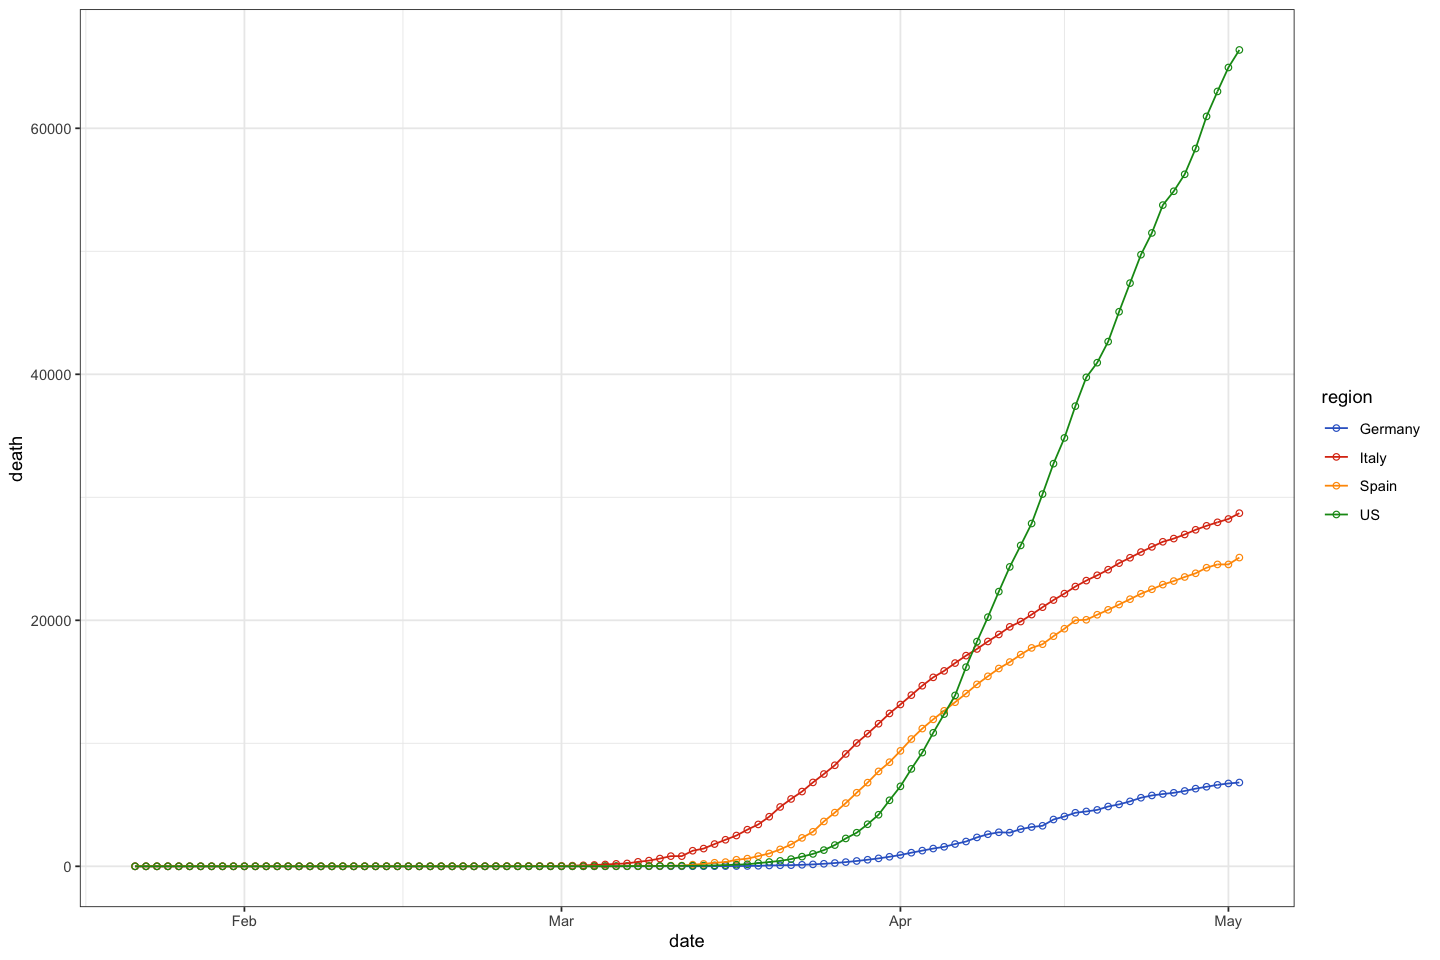

In [4]:
# plot trends in different countries

p <- ggplot(gdeath[gdeath$region %in% c('Italy', 'US', 'Germany', 'Spain'), ], aes(date, death, col=region))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_point(shape=21)
p <- p + geom_line()
# p <- p + scale_y_continuous(trans='log10')
p

## NYTimes

Data source: [NYTimes Github repository](https://github.com/nytimes/covid-19-data)

```sh
pwd; date
# /Users/cchiang/research/chiang/projects/covid-19
# Tue May  5 16:52:32 EDT 2020

curl -s https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv \
    | gzip -c > data/nytimes/us-counties.csv.gz

```

In [5]:
# clean up data
nyt <- read_csv('data/nytimes/us-counties.csv.gz')

# Counties all have FIPS identifier except for NYC, which is empty because it's an aggregative of 5 boroughs
# we'll add a column "fips2", which is the same as fips except nyc is denoted with fips2=nyc
nyt$fips2 <- nyt$fips
nyt[nyt$county=="New York City" & nyt$state=="New York",]$fips2 <- 'nyc'

Parsed with column specification:
cols(
  date = col_date(format = ""),
  county = col_character(),
  state = col_character(),
  fips = col_character(),
  cases = col_double(),
  deaths = col_double()
)



## US Census

[County level population data from the US census website](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html#par_textimage_70769902)

Note that FIPS is concatenation of `STATE` and `COUNTY` identifiers in this table

```sh
pwd ; date
# /Users/cchiang/research/chiang/projects/covid-19
# Tue Apr 28 17:46:08 EDT 2020

curl -s https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv \
    | gzip -c \
    > data/us_census/co-est2019-alldata.csv.gz
```

In [6]:
# load data
read_csv('data/us_census/co-est2019-alldata.csv.gz') %>%
mutate(fips=paste0(STATE, COUNTY)) %>% # FIPS is concatenation of STATE and COUNTY identifiers in this table
select(c('fips', 'STNAME', 'CTYNAME', 'POPESTIMATE2019')) %>% # select useful columns
rename(state=STNAME, county=CTYNAME, pop=POPESTIMATE2019) -> census

Parsed with column specification:
cols(
  .default = col_double(),
  SUMLEV = col_character(),
  STATE = col_character(),
  COUNTY = col_character(),
  STNAME = col_character(),
  CTYNAME = col_character()
)

See spec(...) for full column specifications.



# SIR Model in Italy

Case reporting for COVID-19 infection prevalence is unreliable due to widespread testing shortages. Reported deaths are more reliable (although still likely to be undercounts) since available testing has been preferentially applied to critically ill patients.

To estimate epidemic trajectory from death reports alone, we'll use a SIR model (susceptible, infected, recovered) with additional category D = deceased.

$$\begin{align}
\frac{dS(t)}{dt} &= -\beta I(t) S(t) \\[10pt]
\frac{dI(t)}{dt} &= \beta S(t) I(t) - (\gamma + \mu) I(t) \\[10pt]
\frac{dR(t)}{dt} &= \gamma I(t) \\[10pt]
\frac{dD(t)}{dt} &= \mu I(t)
\end{align}$$

We'll look at Italy data first, since it offers several advantages

- Affected early, mature trajectory of deaths
- First severely affected Western country, data fairly reliable
- Aggressive testing

## Fit 1: Random Guesses

##### Model

In [504]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [505]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [506]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [507]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

# time zero of virus introduction
t0 <- as.Date('2020-01-23')

##### Observed

In [75]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

ERROR: Error in select(., date, death): unused arguments (date, death)


In [509]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta, gamma, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


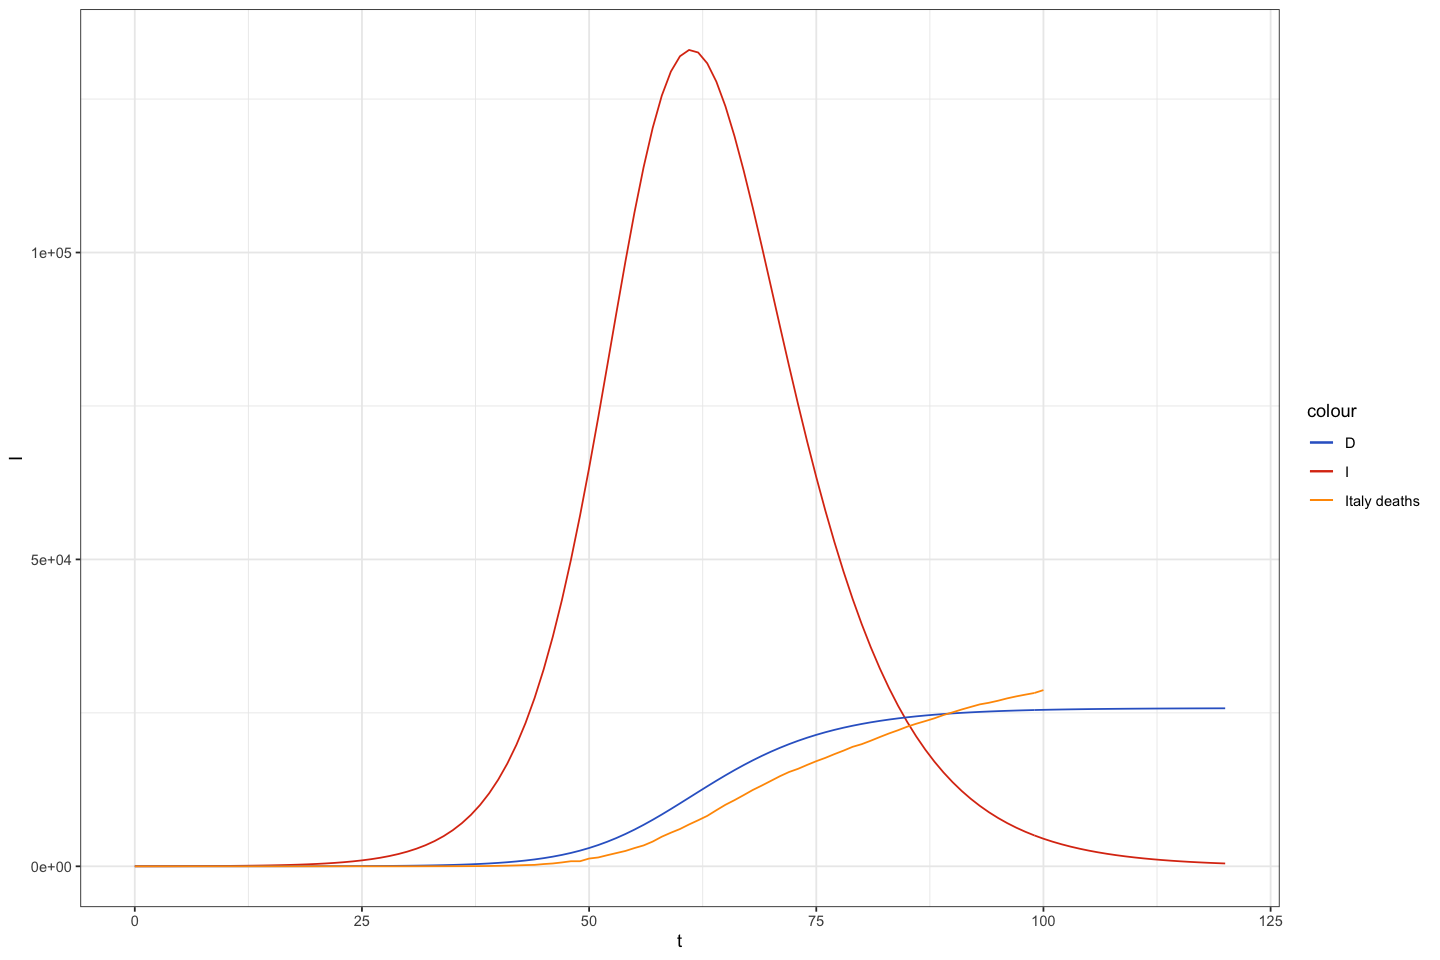

In [510]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p

## Fit 2: Normal (beta optimization)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$, fixed $\mu$ and $\gamma$

##### Model

In [511]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [512]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [513]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [514]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [515]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [516]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [517]:
# parameter iterative function
f1 <- function (beta) {
    params <- c(beta=beta, gamma=gamma, mu=mu, sigma=sigma)
    loglik.normal(params)
}

##### Optimization

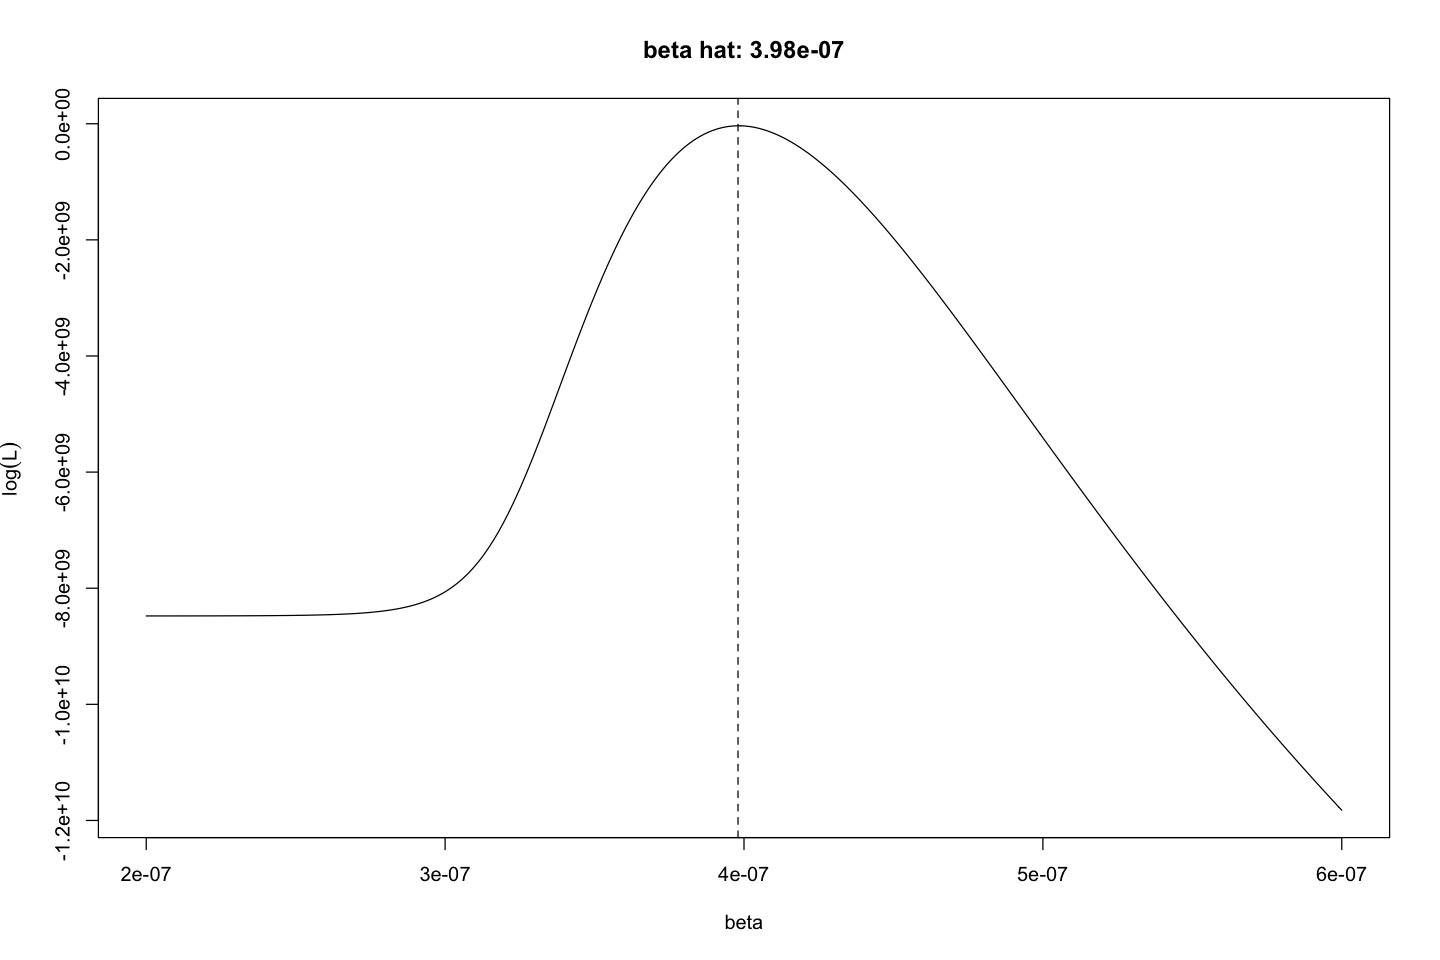

In [518]:
# plot log-likelihood as function of beta
beta <- seq(from=2e-7,to=6e-7,by=1e-9)
ll <- sapply(beta,f1)

beta.hat <- beta[which.max(ll)]
plot(beta, ll, type='l',ylab=expression(log(L)), main=paste0('beta hat: ', beta.hat))
abline(v=beta.hat,lty=2)

##### Trajectory with optimized beta

In [519]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta.hat, gamma, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


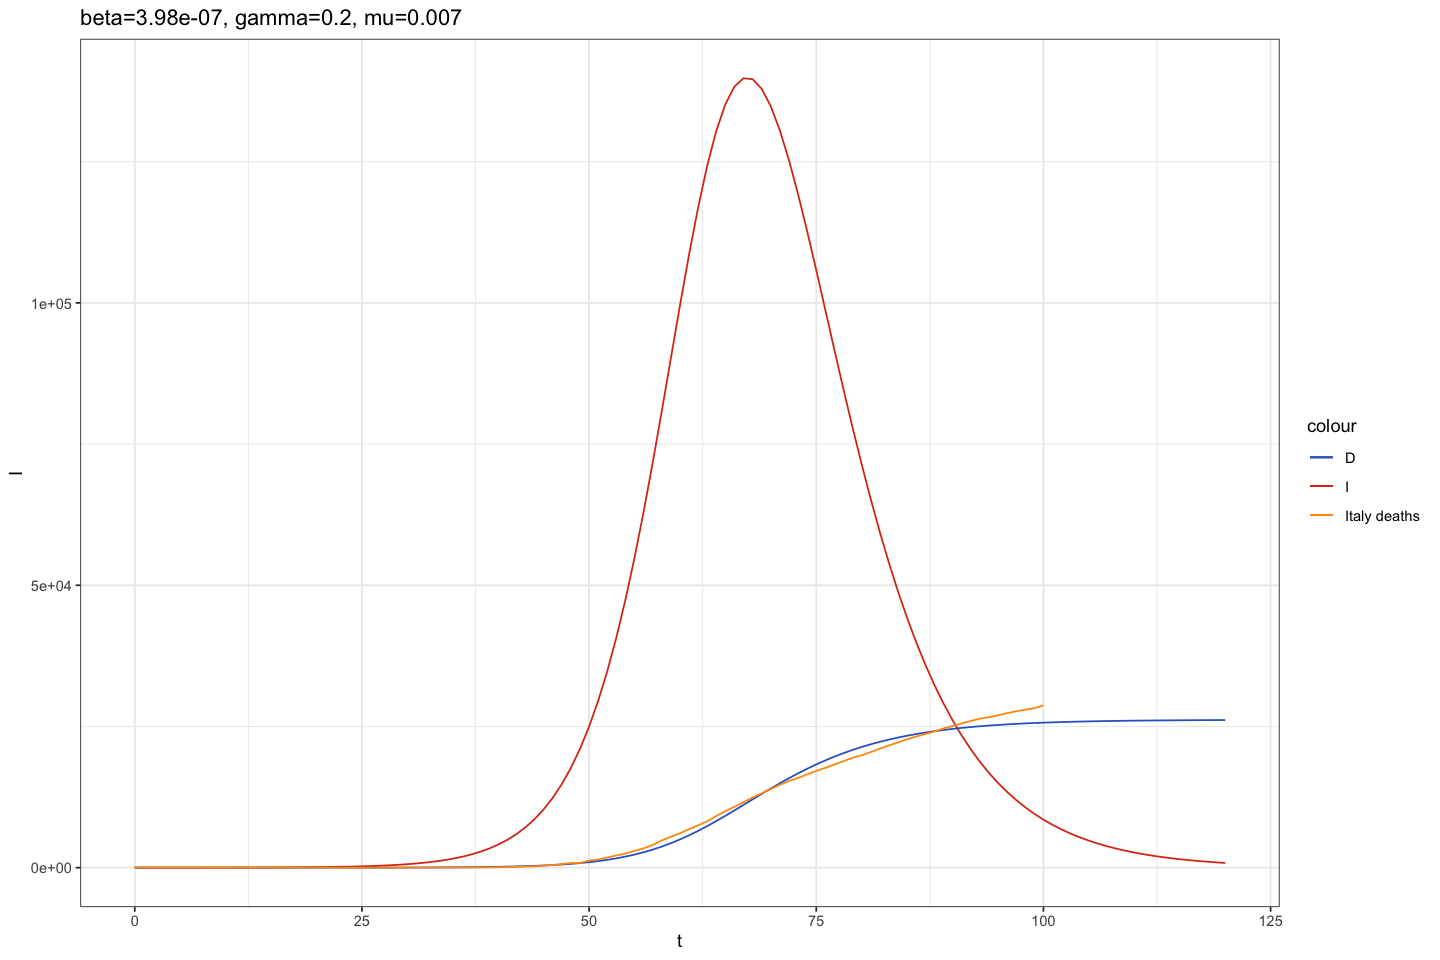

In [520]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('beta=', beta.hat, ', gamma=', gamma, ', mu=', mu))
p

## Fit 3: Normal (beta, gamma optimization)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$ and $\gamma$ simultaneously, fixed $\mu$

##### Model

In [521]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [522]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [523]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [524]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [525]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [526]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [527]:
# parameter iterative function
f2 <- function (log.beta, log.gamma) {
    params <- c(beta=exp(log.beta), gamma=exp(log.gamma), mu=mu, sigma=sigma)
    loglik.normal(params)
}

##### Optimization

In [528]:
grid <- expand.grid(log.beta=seq(from=-14.8,to=-14.65,length=50),
                    log.gamma=seq(from=-1.7,to=-1.5,length=50)
                   )
grid$ll <- unlist(do.call(Map, c(f = f2, grid)))

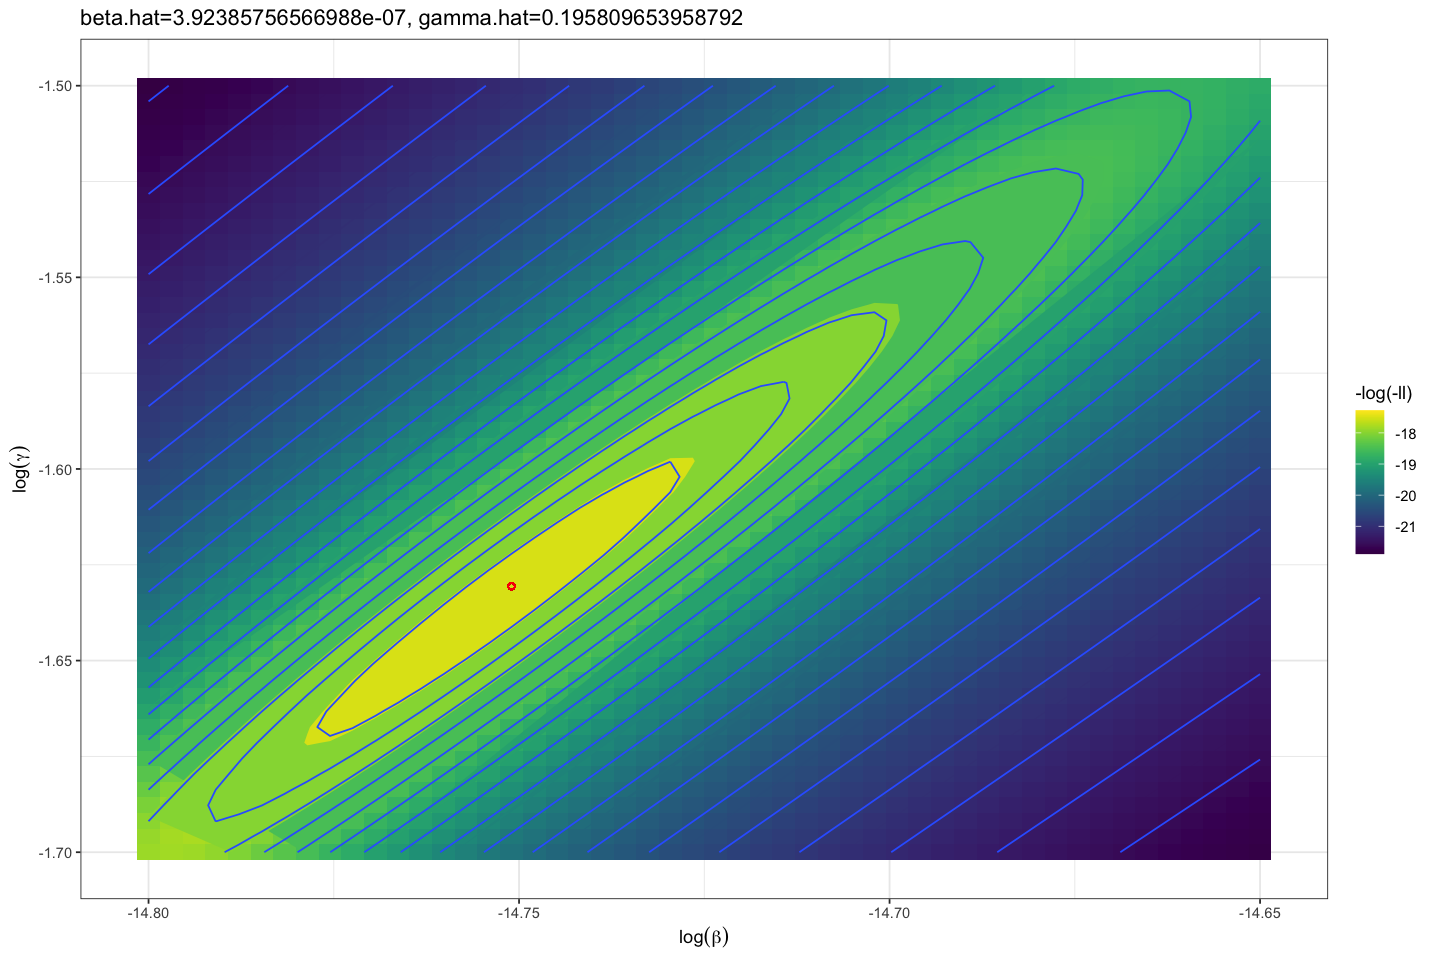

In [529]:
# Contour plot of beta and gamma

opt <- grid[which.max(grid$ll),]
beta.hat <- exp(opt$log.beta)
gamma.hat <- exp(opt$log.gamma)

p <- ggplot(grid, aes(x = log.beta, y = log.gamma, z = -log(-ll)))
p <- p + theme_bw() + scale_fill_viridis()
p <- p + geom_tile(aes(fill = -log(-ll)))
p <- p + stat_contour(geom = 'polygon', aes(fill = ..level..))
p <- p + stat_contour(bins = 20)
p <- p + xlab(expression(log(beta))) + ylab(expression(log(gamma)))
p <- p + ggtitle(paste0('beta.hat=', beta.hat, ', gamma.hat=', gamma.hat))
p <- p + geom_point(aes(x=log(beta.hat), y=log(gamma.hat)), col='red', shape=21)
p

##### Trajectory with optimized beta

In [530]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta.hat, gamma.hat, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


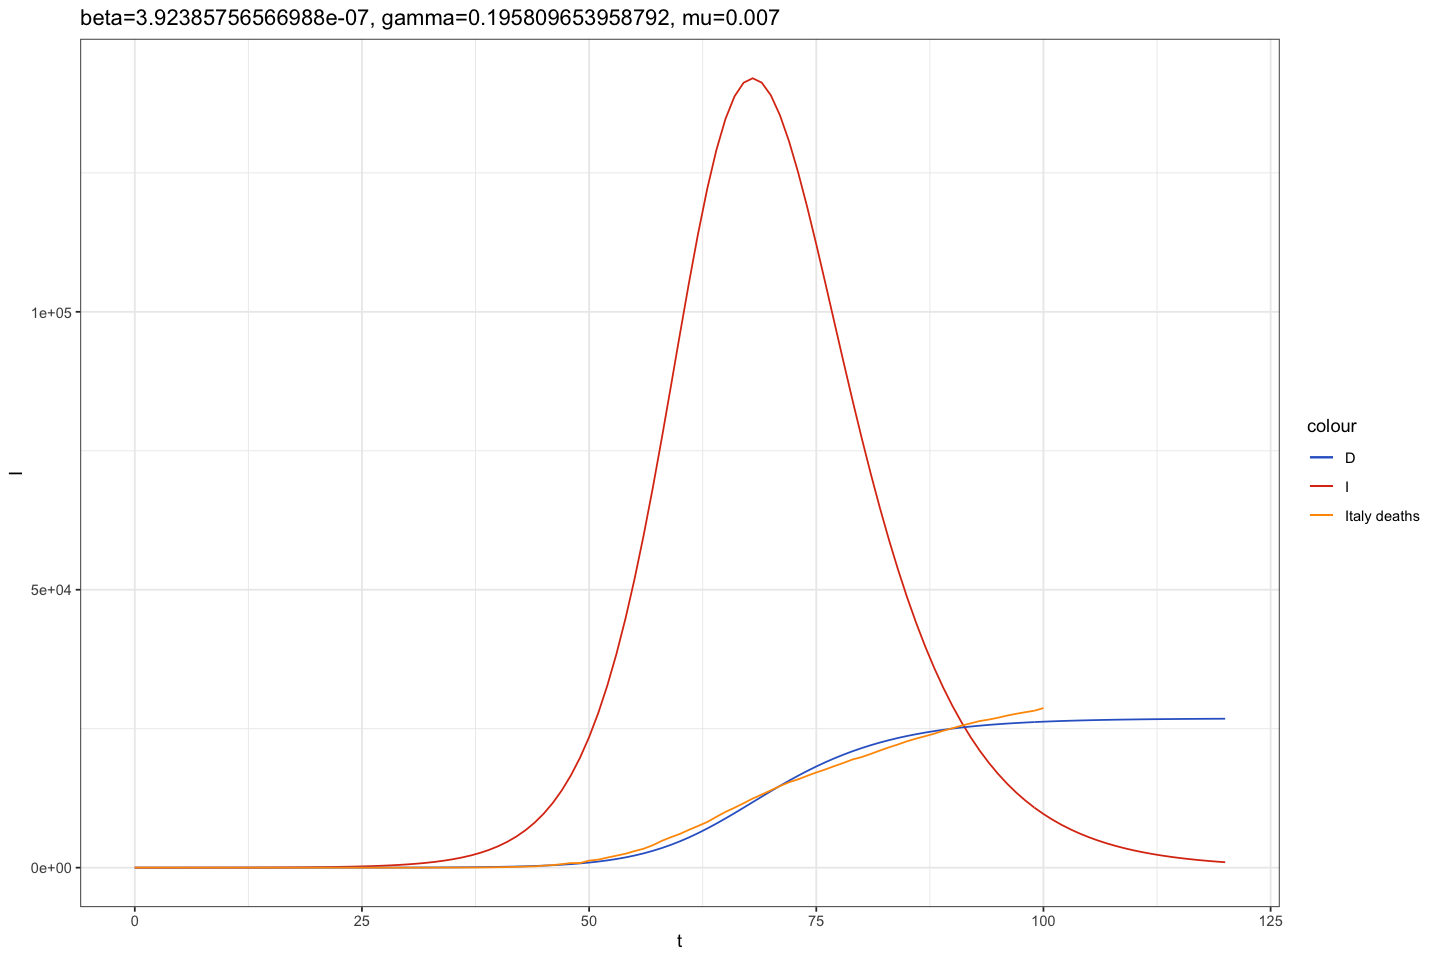

In [531]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('beta=', beta.hat, ', gamma=', gamma.hat, ', mu=', mu))
p

## Fit 4: Normal error (beta, gamma, mu)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$, $\gamma$, and $\mu$ simultaneously

##### Model

In [532]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [533]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [534]:
# Grid where to evaluate
max_time <- 150
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [535]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [536]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [537]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [538]:
# parameter iterative function
f3 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), sigma=sigma)
    -loglik.normal(params)
}

##### Optimization

In [539]:
fit3 <- optim(f3, par=c(-15, -2, -5))
fit3

opt <- fit3$par
R0 <- exp(opt[1]) * N / exp(opt[2])

$par
[1] -15.129698  -3.479118  -6.704314

$value
[1] 435802

$counts
function gradient 
     355       NA 

$convergence
[1] 0

$message
NULL

##### Trajectory with optimized beta

In [540]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 70 row(s) containing missing values (geom_path).”
Warning message:
“Removed 107 row(s) containing missing values (geom_path).”
Warning message:
“Removed 98 row(s) containing missing values (geom_path).”
Warning message:
“Removed 50 row(s) containing missing values (geom_path).”


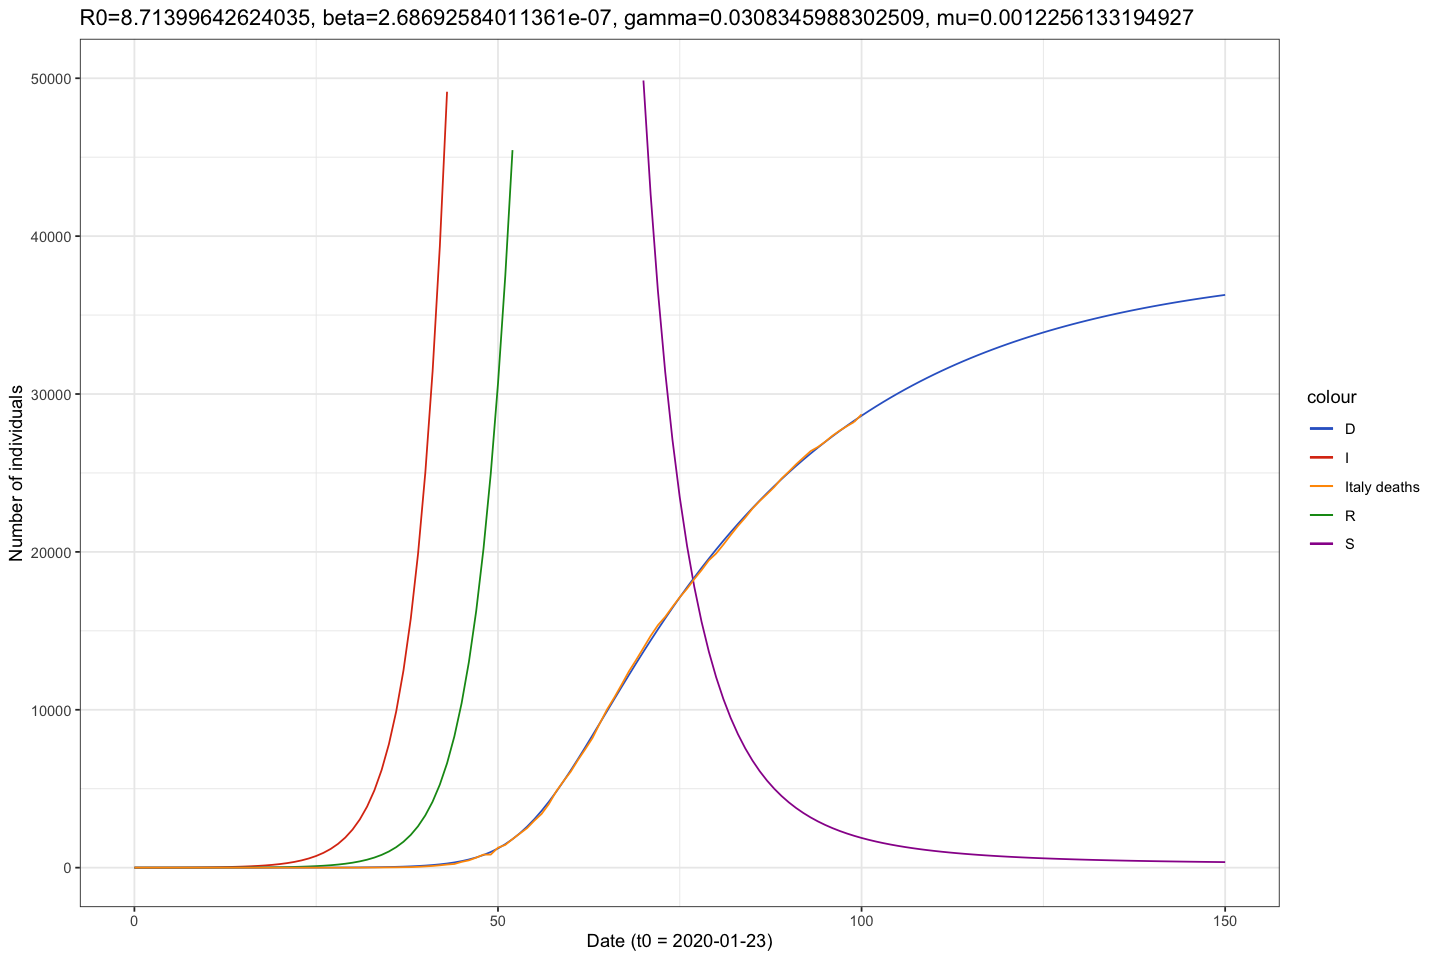

In [541]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(limits=c(0,5e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 50 row(s) containing missing values (geom_path).”


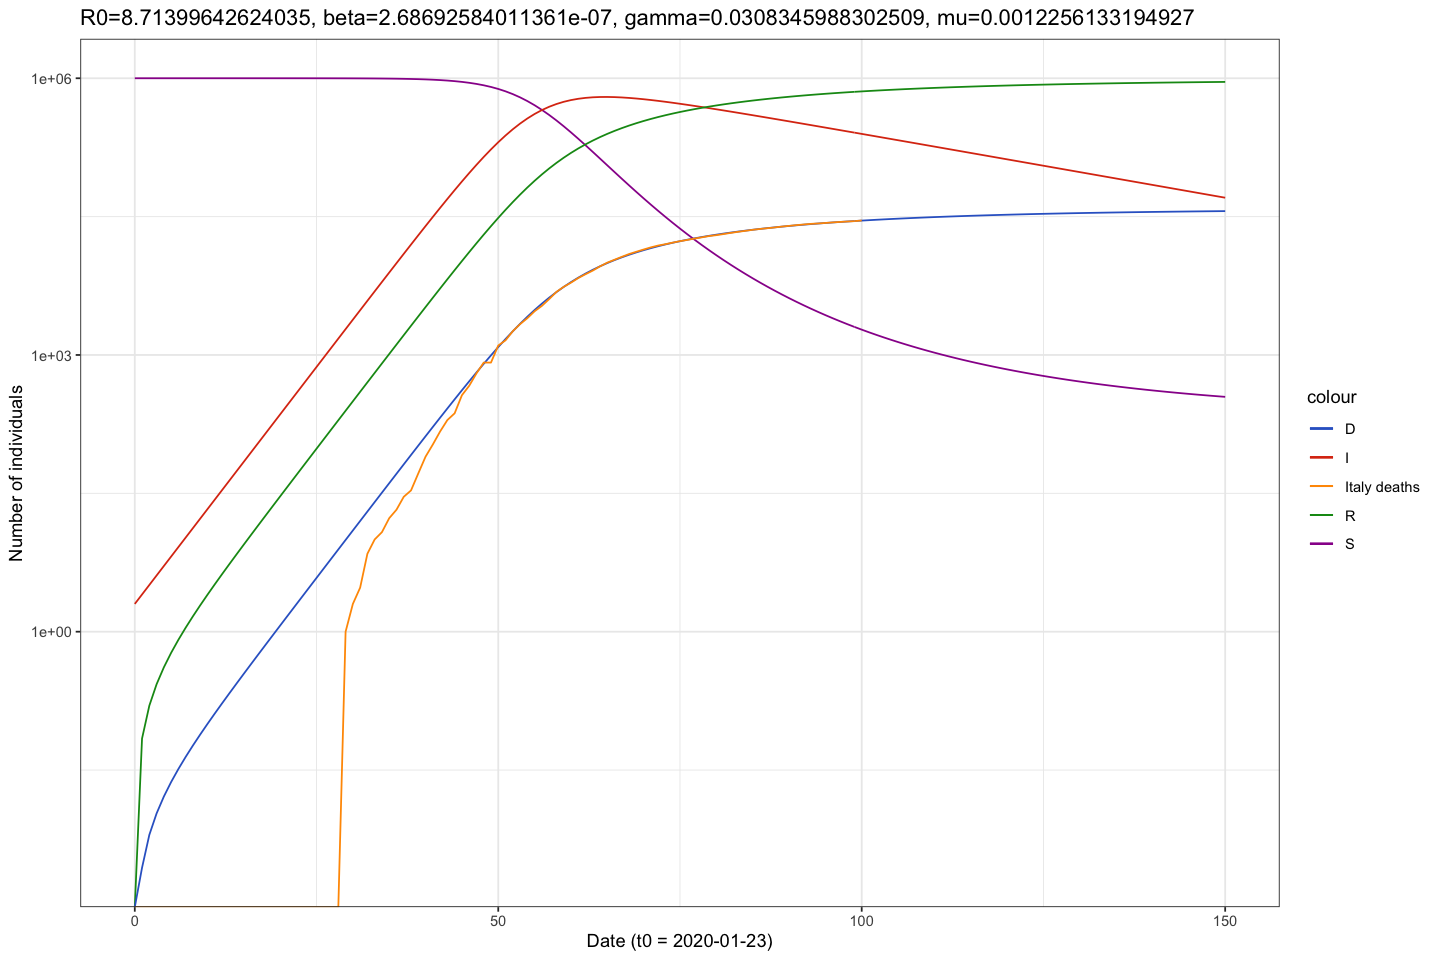

In [542]:
# plot the simulated data compared to the observed (italy) data (log transformed)
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

## Fit 5: Poisson error (beta, gamma, mu)

- Maximize log-likelihood (sum of poisson error)
- Optimize $\beta$, $\gamma$, and $\mu$ simultaneously

##### Poisson error distribution

Since data $y_t$ are a result of a sampling process, we can think of them as binomial samples

$$ y_t \sim \mathrm{Binomial}\left(I(t), \frac{n}{N} \right) $$

where $n$ is sample size, $N$ is population size, $I(t)$ is the true number of infections at time $t$. Alternatively, we might think of $y_t$ as Poisson samples

$$ y_t \sim \mathrm{Poisson}(p, I(t)) $$

where the parameter $p$ reflects a combination of sampling efficiency and the detectability of infections. The latter leads to the following log-likelihood function

##### Model

In [543]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [544]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [545]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [546]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1
p.scale <- 1 # lambda scaling coefficient for Poisson distribution

t0 <- as.Date('2020-01-23')
I0 <- 2


##### Observed

In [547]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [548]:
# log likelihood function
poisson.loglik <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dpois(x=italy$death, lambda=params["p.scale"]*subset(s, t >= min(italy$t) & t <= max(italy$t))$D, log=TRUE))
}

In [549]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f4 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), p.scale=p.scale)
    -poisson.loglik(params)
}

##### Optimization

In [550]:
# params: beta, gamma, mu
fit4 <- optim(f4, par=c(log(4e-7), log(1/30), log(1e-3)))
fit4

opt <- fit4$par
R0 <- exp(opt[1]) * N / exp(opt[2])

R0

$par
[1] -15.128863  -3.416808  -6.666106

$value
[1] 591.3724

$counts
function gradient 
     156       NA 

$convergence
[1] 0

$message
NULL

[1] 8.194438

In [551]:
mle1 <- c(beta=exp(opt[1]), gamma=exp(opt[2]), mu=exp(opt[3]))
signif(mle1,3)

beta    gamma       mu 
2.69e-07 3.28e-02 1.27e-03

In [552]:
opt

[1] -15.128863  -3.416808  -6.666106

##### Confidence intervals

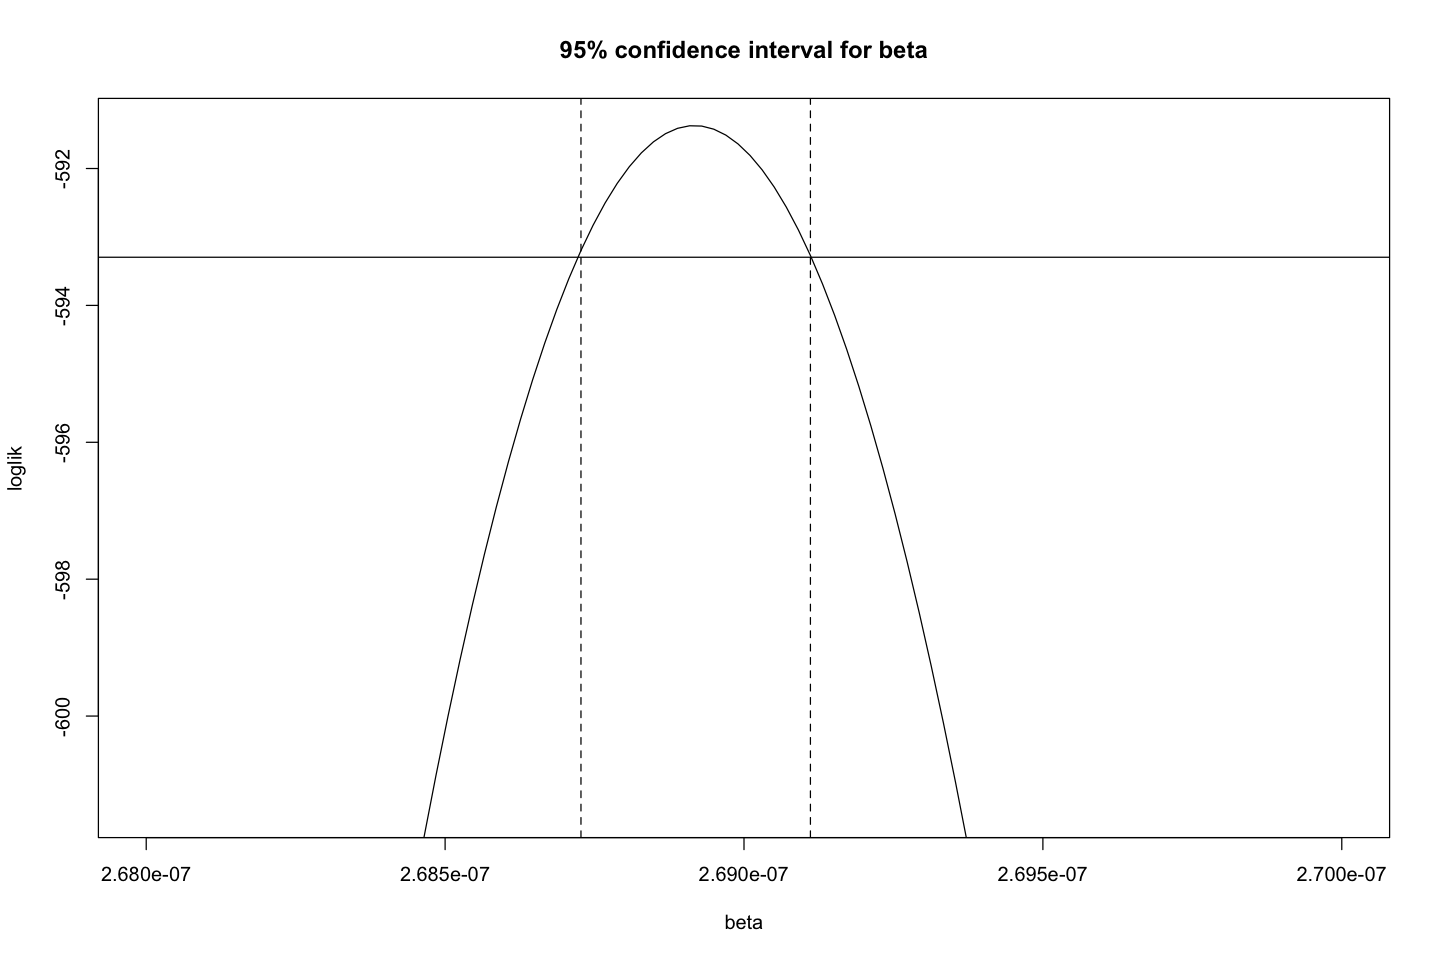

In [553]:
# profile over beta to estimate confidence intervals

prof2.beta <- expand.grid(beta=seq(2.68e-7,2.7e-7,length=100))
fitfn <- function (dat) {
    fit <- optim(fn=function(beta) f4(c(log(dat$beta), opt[2], opt[3], opt[4])),
                 par=mle1[2],method="Brent",lower=0,upper=1)
    c(p=expit(fit$par),loglik=-fit$value)
}

library(plyr)
ddply(prof2.beta,~beta,fitfn) -> prof2.beta
maxloglik <- max(prof2.beta$loglik)
plot(loglik~beta,data=prof2.beta,type="l",ylim=maxloglik+c(-10,0), main='95% confidence interval for beta')
cutoff <- maxloglik-qchisq(p=0.95,df=1)/2
abline(h=c(0,cutoff))
abline(v=range(subset(prof2.beta,loglik>cutoff)$beta),lty=2)

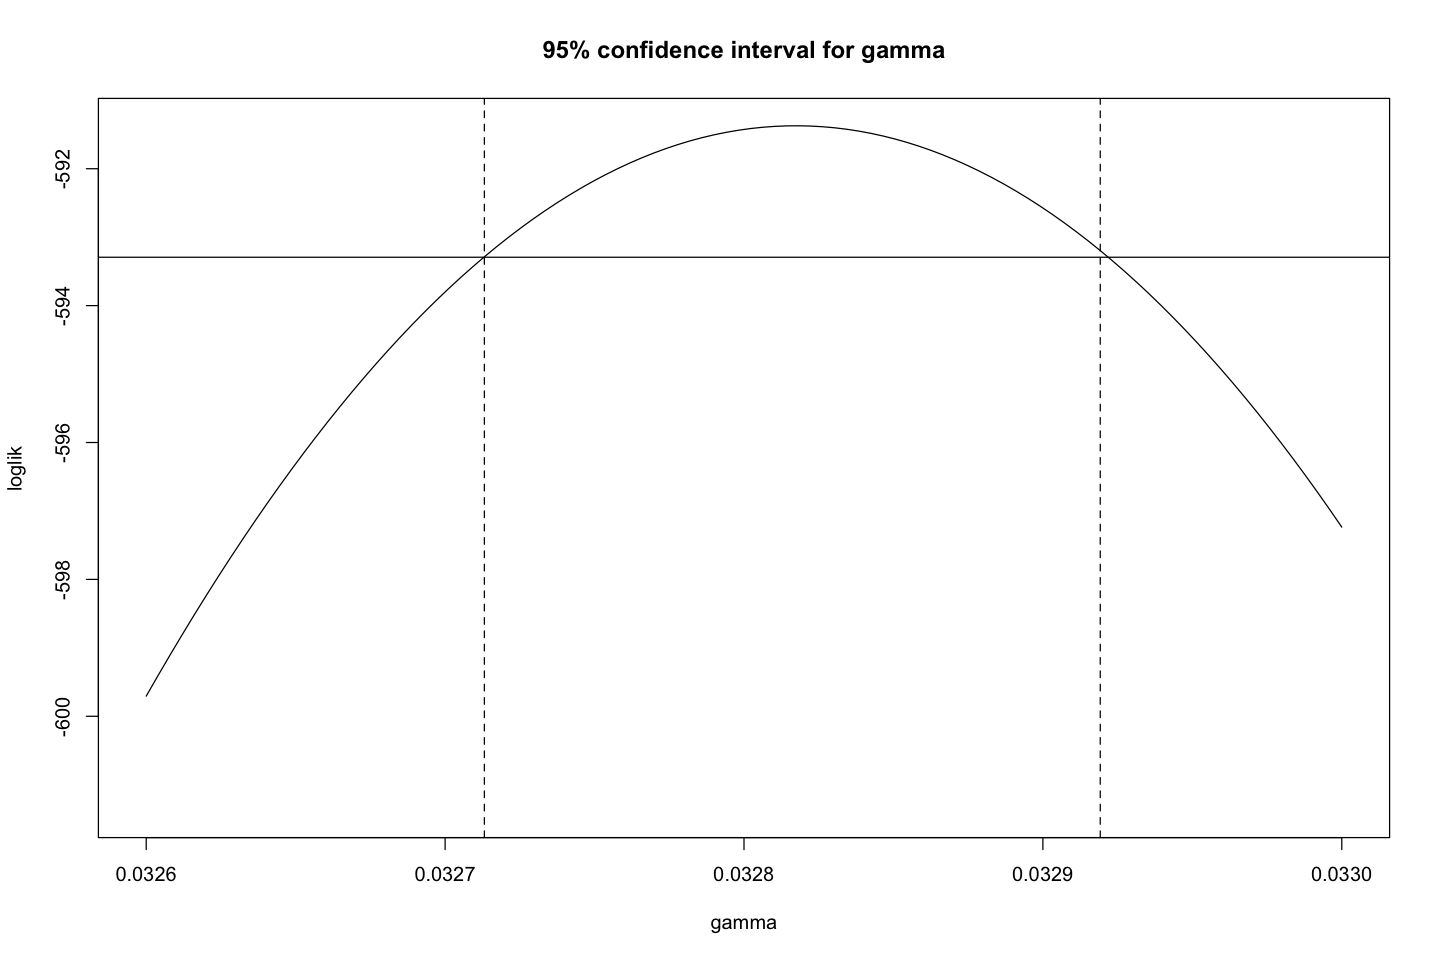

In [557]:
# profile over gamma to estimate confidence intervals

prof2.gamma <- expand.grid(gamma=seq(3.26e-2,3.3e-2,length=100))
fitfn <- function (dat) {
    fit <- optim(fn=function(gamma) f4(c(opt[1], log(dat$gamma), opt[3], opt[4])),
                 par=mle1[2],method="Brent",lower=0,upper=1)
    c(p=expit(fit$par),loglik=-fit$value)
}

library(plyr)
ddply(prof2.gamma,~gamma,fitfn) -> prof2.gamma
maxloglik <- max(prof2.gamma$loglik)
plot(loglik~gamma,data=prof2.gamma,type="l",ylim=maxloglik+c(-10,0), main='95% confidence interval for gamma')
cutoff <- maxloglik-qchisq(p=0.95,df=1)/2
abline(h=c(0,cutoff))
abline(v=range(subset(prof2.gamma,loglik>cutoff)$gamma),lty=2)

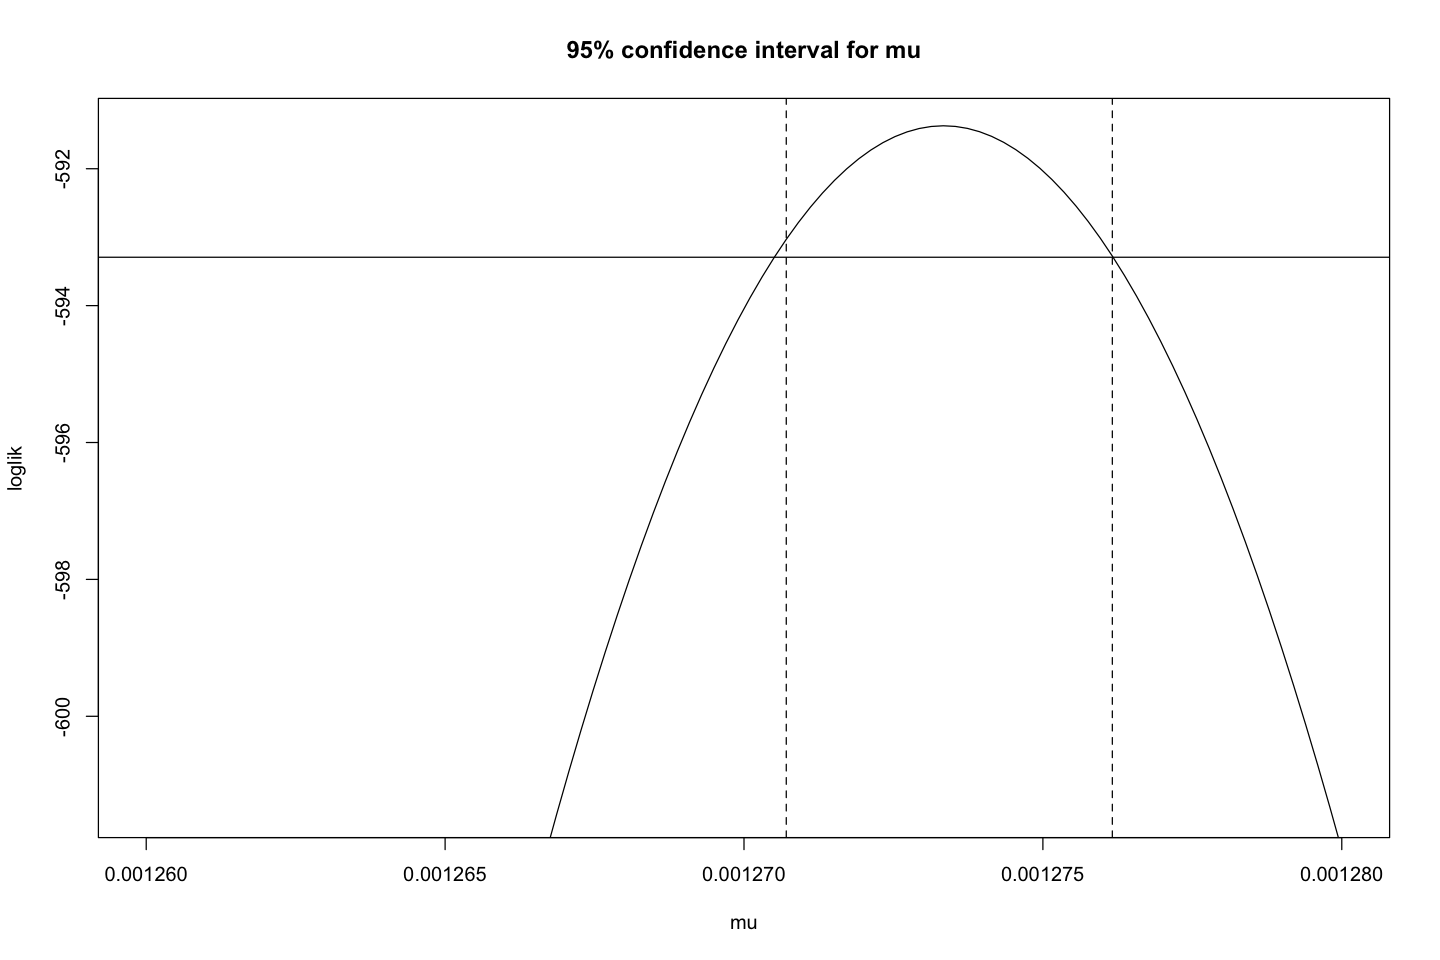

In [558]:
# profile over mu to estimate confidence intervals

prof2.mu <- expand.grid(mu=seq(1.26e-3,1.28e-3,length=100))
fitfn <- function (dat) {
    fit <- optim(fn=function(mu) f4(c(opt[1], opt[2], log(dat$mu), opt[4])),
                 par=mle1[2],method="Brent",lower=0,upper=1)
    c(p=expit(fit$par),loglik=-fit$value)
}

library(plyr)
ddply(prof2.mu,~mu,fitfn) -> prof2.mu
maxloglik <- max(prof2.mu$loglik)
plot(loglik~mu,data=prof2.mu,type="l",ylim=maxloglik+c(-10,0), main='95% confidence interval for mu')
cutoff <- maxloglik-qchisq(p=0.95,df=1)/2
abline(h=c(0,cutoff))
abline(v=range(subset(prof2.mu,loglik>cutoff)$mu),lty=2)

In [559]:
mle1

beta        gamma           mu 
2.689169e-07 3.281701e-02 1.273347e-03

##### Trajectory with optimized beta

In [560]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> pred

Warning message:
“Removed 71 row(s) containing missing values (geom_path).”
Warning message:
“Removed 77 row(s) containing missing values (geom_path).”
Warning message:
“Removed 68 row(s) containing missing values (geom_path).”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


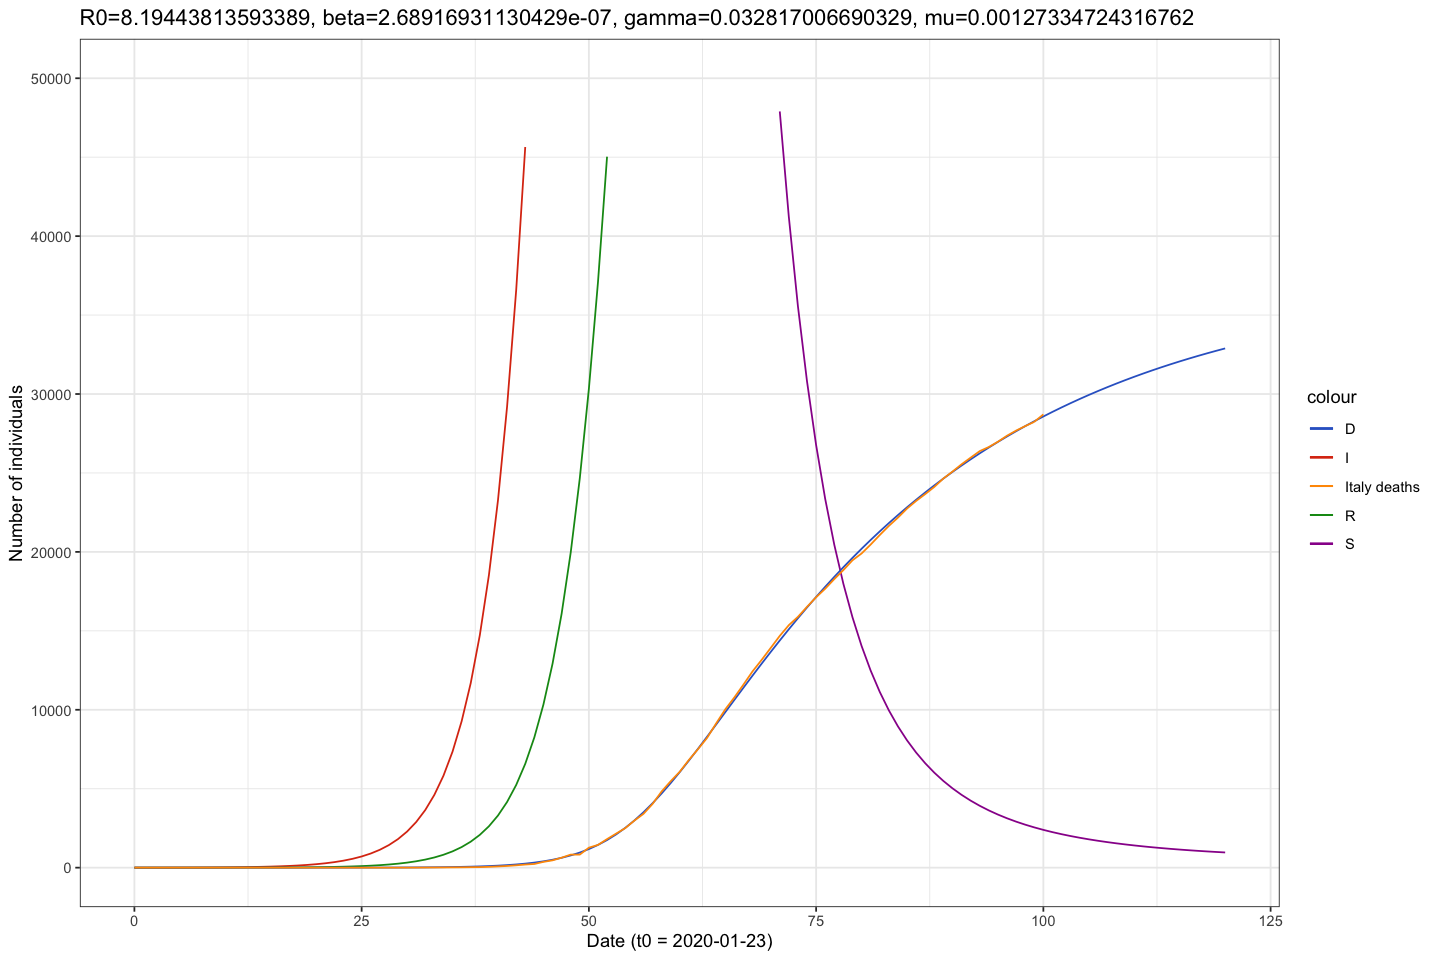

In [561]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(pred, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(limits=c(0,5e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


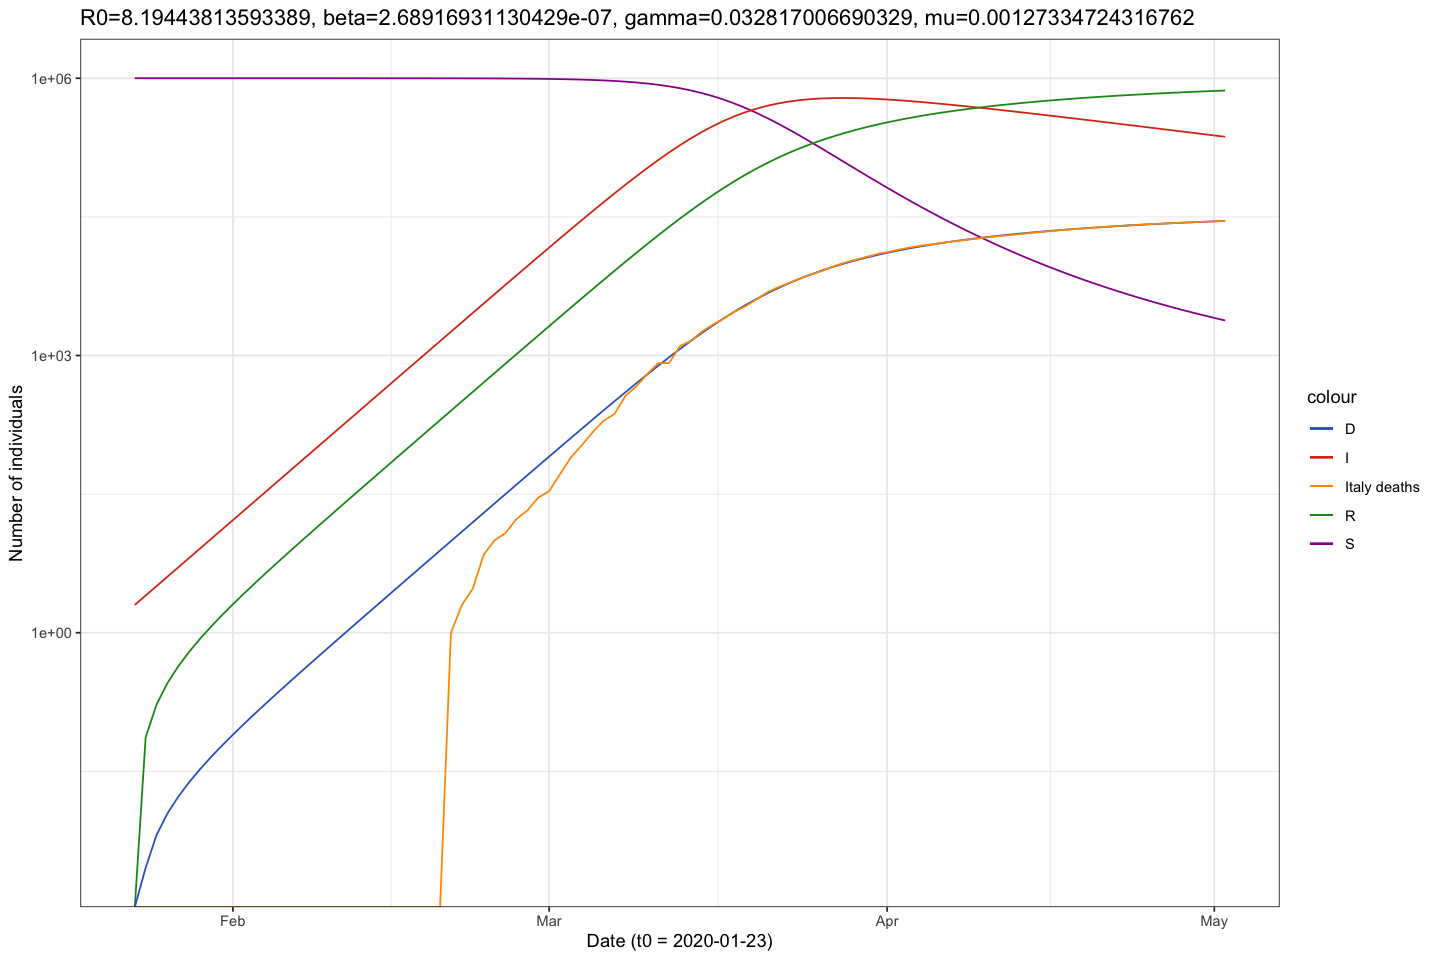

In [562]:
# plot the simulated data compared to the observed (italy) data (log transformed)
p <- ggplot(join(pred, italy, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

##### Predicted probability distribution plot

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


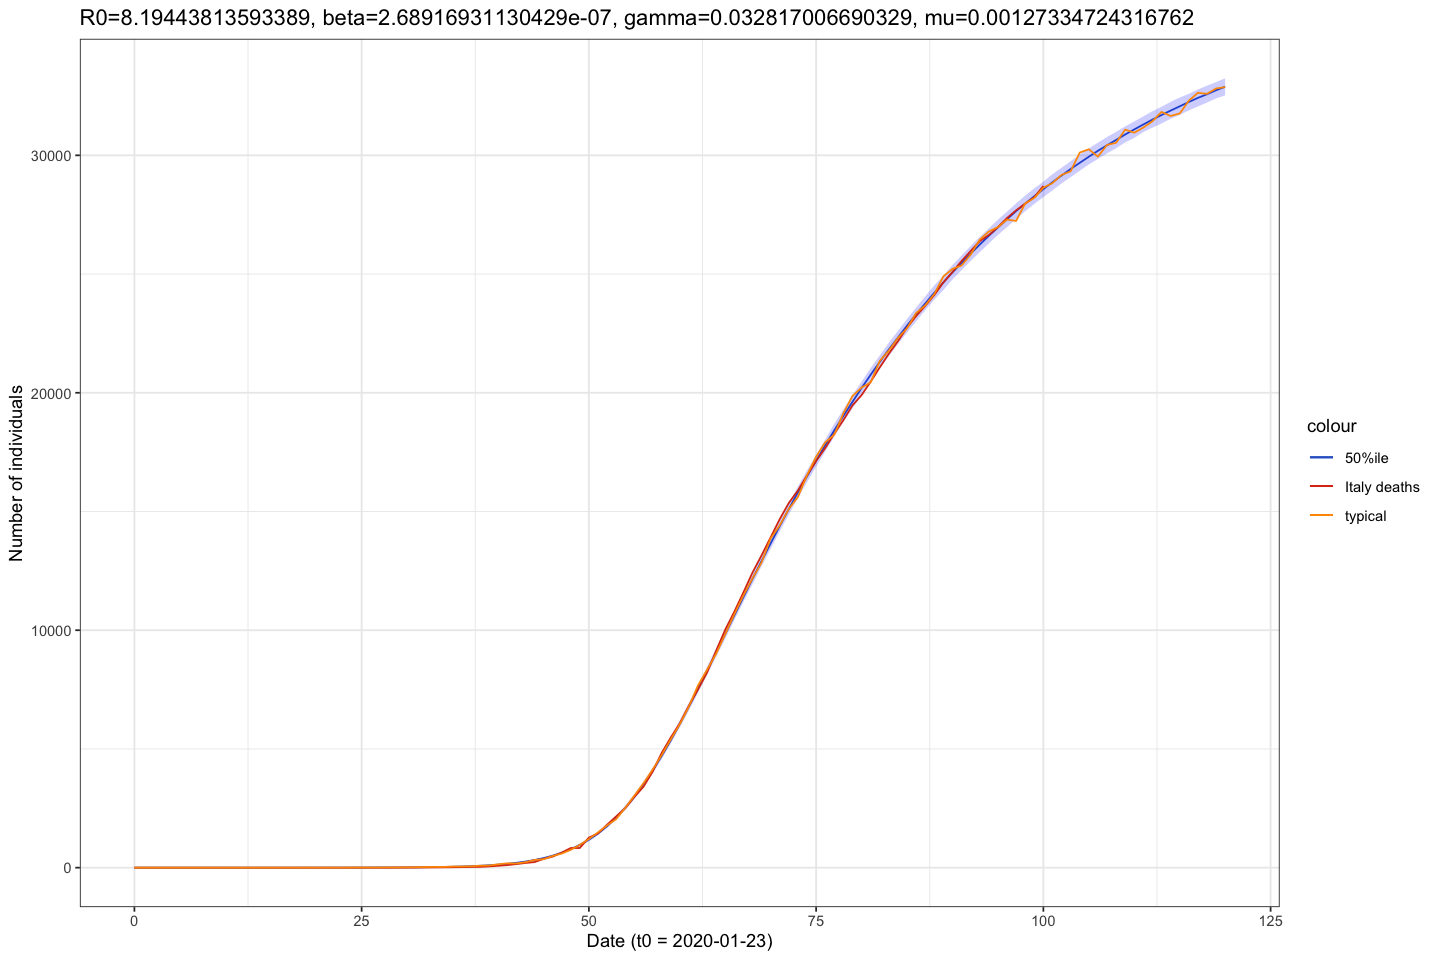

In [563]:
# run 2000 simulations of optimized parameters

raply(2000,rpois(n=length(pred$D),lambda=p.scale * pred$D)) -> simdat
aaply(simdat,2,quantile,probs=c(0.025,0.5,0.975)) -> quantiles

typ <- sample(nrow(simdat),1)

p <- ggplot(data=cbind(join(pred, italy, by='t'),
                       quantiles,
                       typical=simdat[typ,]),
            mapping=aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=`50%`, col='50%ile'))
p <- p + geom_ribbon(aes(ymin=`2.5%`,ymax=`97.5%`), fill='blue', alpha=0.2)
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + geom_line(aes(y=typical, col='typical'))
p <- p + labs(y="Deaths",x="t")
# p <- p + scale_x_continuous(limit=c(70,80))
# p <- p + scale_y_continuous(limit=c(1.2e4,1.7e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

## Fit 6: Vary N with Poisson error (N, beta, gamma, mu)

I'm not sure how choice of $N$ (population size) affects these estimates, and choice of 1e6 was arbitrary.

Let's allow $N$ to vary and evaluate how this changes our results. We'll continue to use the same Poisson error model in Fit 5.

The actual population of Italy is 60.3 million [[source](https://en.wikipedia.org/wiki/Demographics_of_Italy)]. This might not be the effective population, but let's allow this to vary and see what happens.

- Maximize log-likelihood (sum of poisson error)
- Optimize $S_0$, $\beta$, $\gamma$, and $\mu$ simultaneously
- We're probably in danger of overfitting here

Results of this seem to show that when $N \gt 20,000,000$, it struggles to achieve good fit with reasonable parameter values ($R_0$ goes to ~30, $1/\gamma$ approaches 100 days)

Several possible causes:
- Actual susceptible population is much less than total population of Italy
- Infection spreading through population via semi-isolated communities, leading to $e^{e^e}$ order spread

One solution might be to use more isolated populations, such as county or province-level data.

##### Model

In [782]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [783]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [784]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [785]:
# Variables

# Population size 
N <- 40e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/14
# Infectious contact rate: beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 2.5/N*gamma
mu <- 1e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1
p.scale <- 1 # lambda scaling coefficient for Poisson distribution

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [786]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [787]:
# log likelihood function
poisson.loglik <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(params['N'] - I0, I0, 0, 0)) -> s

    sum(dpois(x=italy$death, lambda=params["p.scale"]*subset(s, t >= min(italy$t) & t <= max(italy$t))$D, log=TRUE))
}

In [788]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f4 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), N=N, p.scale=p.scale)
    -poisson.loglik(params)
}

##### Optimization

In [789]:
# params: beta, gamma, mu
fit4 <- optim(f4, par=c(log(beta), log(gamma), log(mu)))
fit4

opt <- fit4$par
R0 <- exp(opt[1]) * N / exp(opt[2])

R0

$par
[1] -17.945641  -0.932053  -7.990361

$value
[1] 6806.771

$counts
function gradient 
     109       NA 

$convergence
[1] 0

$message
NULL

[1] 1.633626

In [790]:
mle1 <- c(beta=exp(opt[1]), gamma=exp(opt[2]), mu=exp(opt[3]))
signif(mle1,3)

beta    gamma       mu 
1.61e-08 3.94e-01 3.39e-04

In [791]:
opt

[1] -17.945641  -0.932053  -7.990361

##### Trajectory with optimized beta

In [792]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> pred

Warning message:
“Removed 121 row(s) containing missing values (geom_path).”
Warning message:
“Removed 84 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


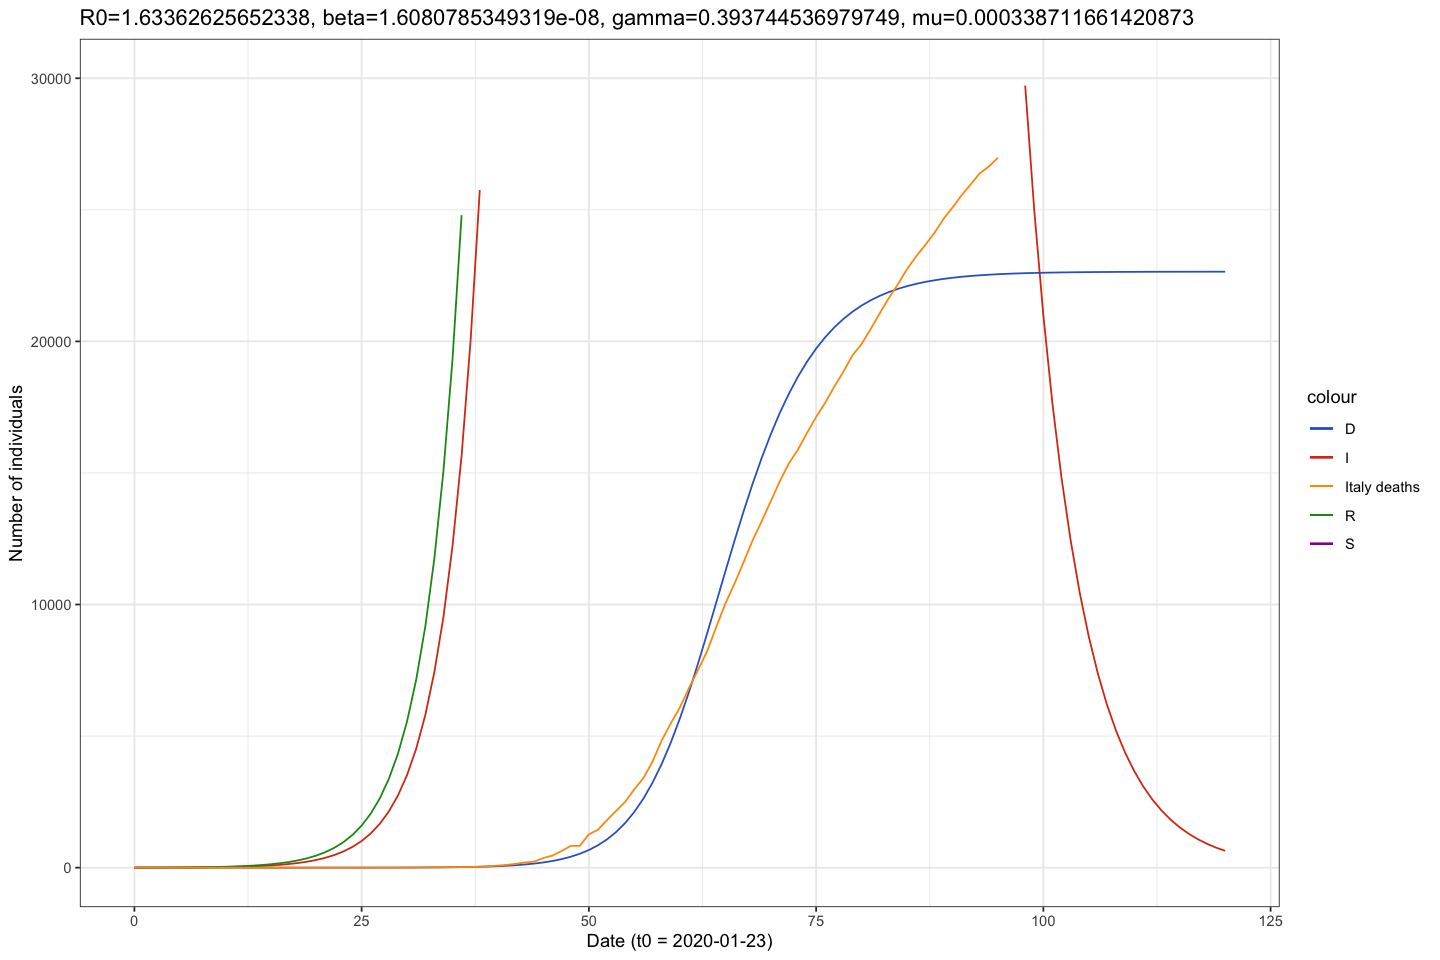

In [793]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(pred, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(limits=c(0,3e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


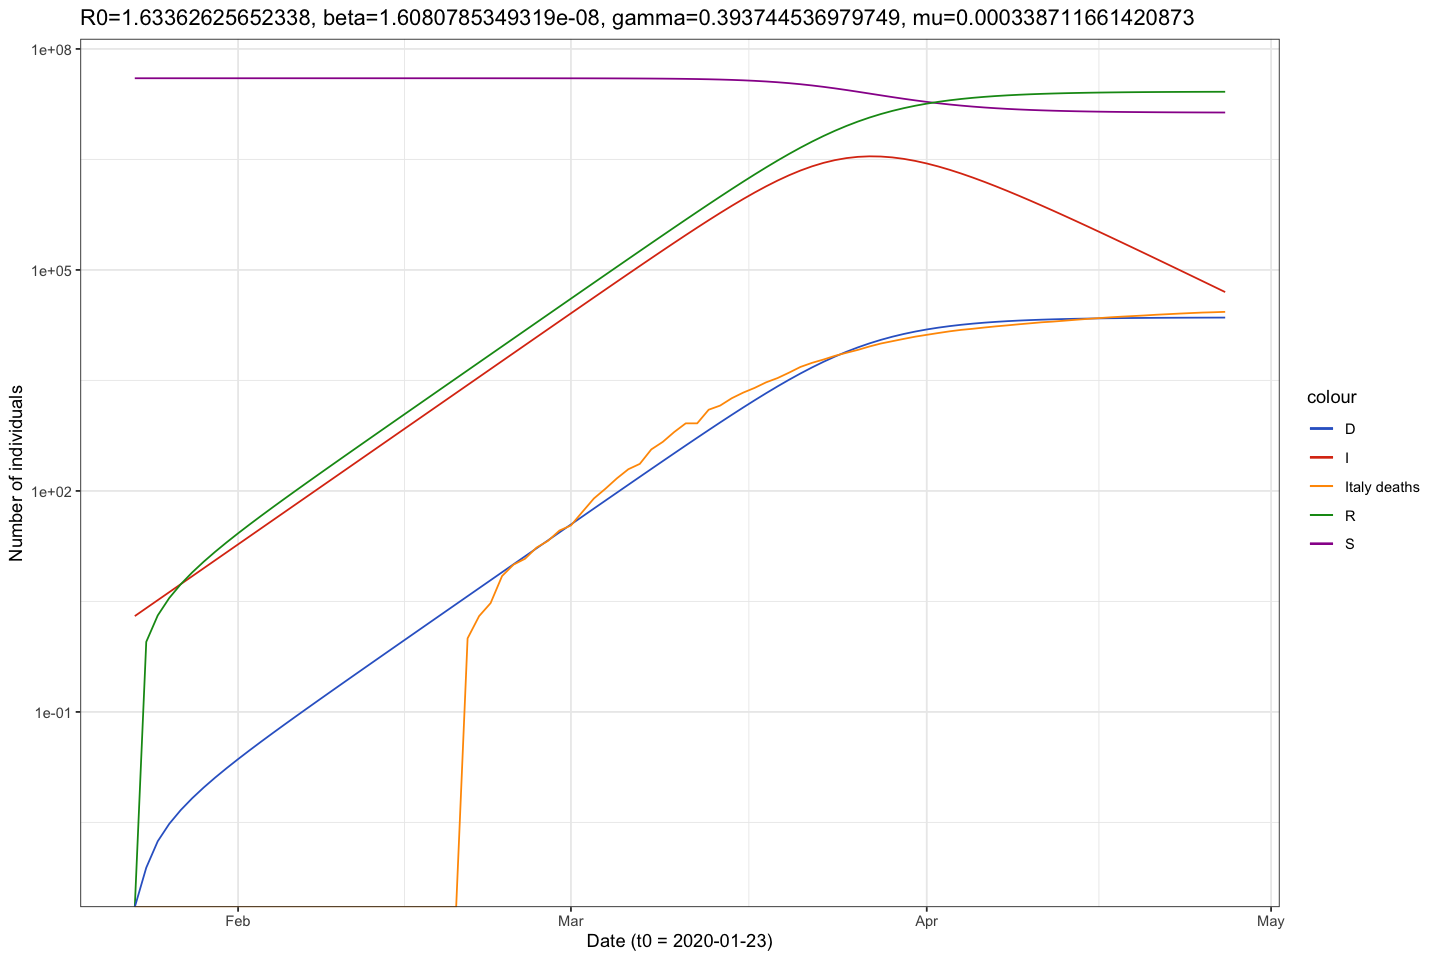

In [794]:
# plot the simulated data compared to the observed (italy) data (log transformed)
p <- ggplot(join(pred, italy, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

## Fit 7: Negative binomial model

- Maximize log-likelihood (sum of negbin error)
- Optimize $\beta$, $\gamma$, and $\mu$ simultaneously

##### Negative binomial distribution

Poisson assumes that the variance of the error is equal to the mean $\lambda$. The **negative binomial distribution** allows for more variability than Poisson. Let's assume that $y_t$ is negative-binomially distributed with mean $p I(t)$ (as before), but with larger variance, $p I(t) (1 + \theta p I(t))$:

$$ y_t \sim \mathrm{Negbin}\left( \mathrm{mean} = p I(t) \text{, size = } \frac{1}{\theta} \right) $$

In [380]:
# to do

# Other geographic sites

So far we've been looking at Italy because the early outbreak provides a more mature dataset for infection dynamics. We'd like to refine our estimation using addition sites, treating them as independent trials that are bound by similar parameters ($\mu$, $\gamma$, $\beta$).

In reality, this is an oversimplification, since these sites are not truly independent (due to intermixing between communities) and differences in population demographics, healthcare systems, social distancing regulation may affect parameters. However, this strategy also has several advantages (easier to estimate effective population size, assumptions of homogenous mixing are more valid, multiple datasets reduce overfitting) and can inform some of the yet unknown underlying characteristics of SARS-CoV-2.

## Spain

- Poisson error model
- Max log-likelihood of $\beta$, $\mu$, $\gamma$

##### Model

In [564]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [565]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [566]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-31, as this was the date of first confirmed positive case (German tourist in the Canary Islands).

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Spain#First_cases_(31_January_%E2%80%93_25_February)

In [567]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1
p.scale <- 1 # lambda scaling coefficient for Poisson distribution

t0 <- as.Date('2020-01-31')
I0 <- 2


##### Observed

In [568]:
# Select data from JHU dataset

subset(gdeath, region=='Spain') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> mysite
mysite.name <- 'Spain'

##### Functions

In [569]:
# log likelihood function
poisson.loglik <- function (params, site) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    
    sum(dpois(x=site$death,
              lambda=params["p.scale"]*subset(s, t >= min(site$t) & t <= max(site$t))$D,
              log=TRUE))
}

In [570]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f5 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), p.scale=p.scale)
    -poisson.loglik(params, mysite)
}

##### Optimization

In [571]:
# params: beta, gamma, mu
fit5 <- optim(f5, par=c(log(3e-7), log(1/30), log(1e-3)))
fit5

opt <- fit5$par
R0 <- exp(opt[1]) * N / exp(opt[2])

R0

$par
[1] -14.996843  -2.630619  -6.182142

$value
[1] 1657.878

$counts
function gradient 
     202       NA 

$convergence
[1] 0

$message
NULL

[1] 4.260076

In [572]:
mle1 <- c(beta=exp(opt[1]), gamma=exp(opt[2]), mu=exp(opt[3]))
signif(mle1,3)

beta    gamma       mu 
3.07e-07 7.20e-02 2.07e-03

In [573]:
opt

[1] -14.996843  -2.630619  -6.182142

##### Trajectory with optimized beta

In [574]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> pred

Warning message:
“Removed 81 row(s) containing missing values (geom_path).”
Warning message:
“Removed 72 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


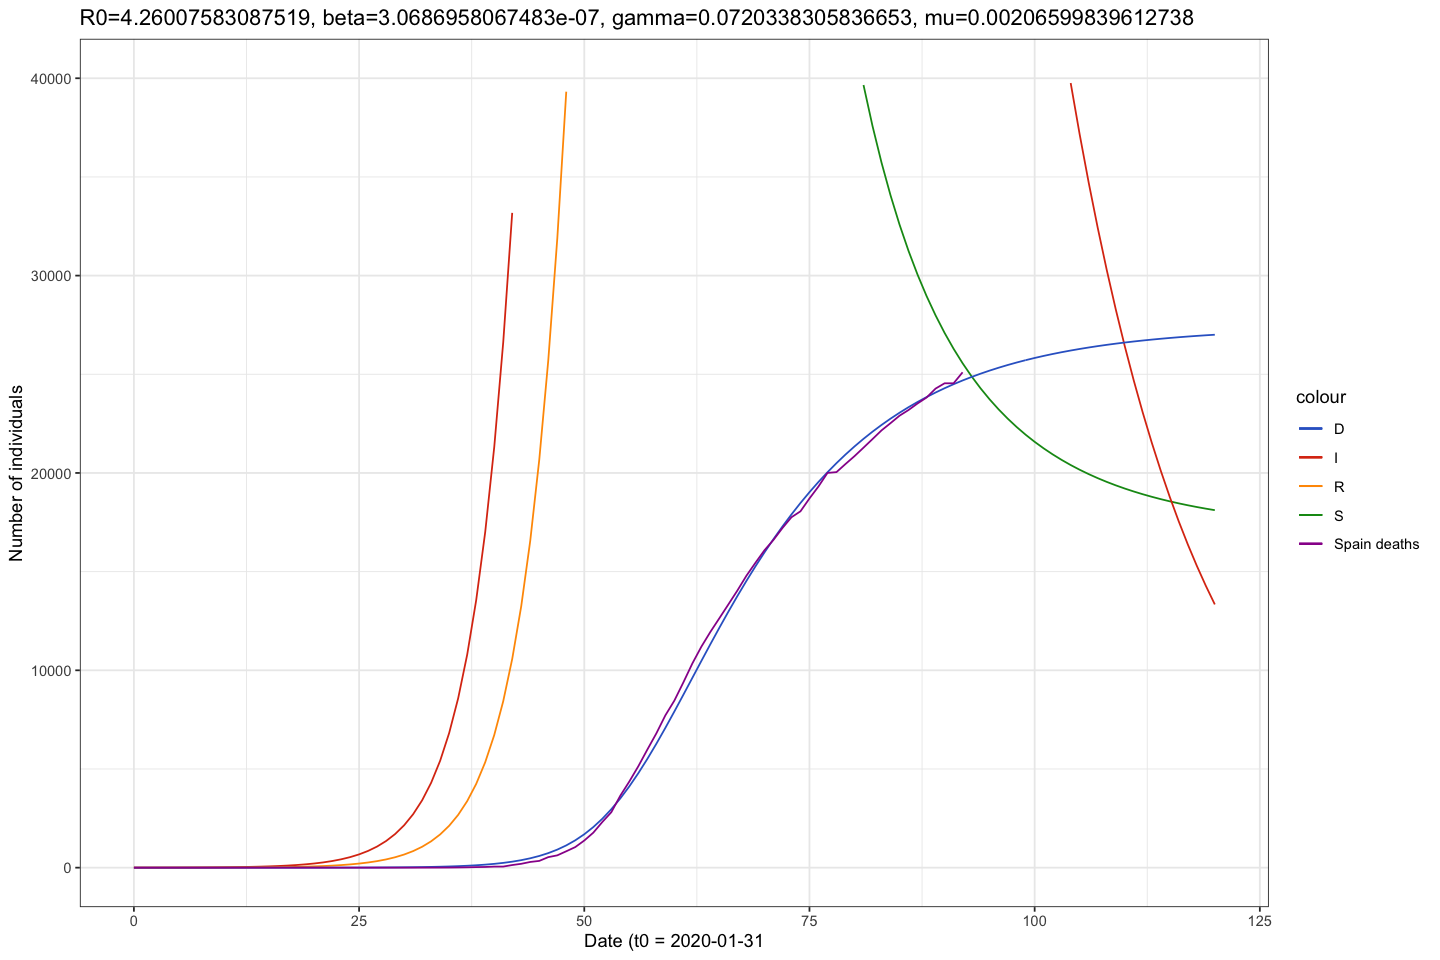

In [575]:
# plot the simulated data compared to the observed data
p <- ggplot(join(pred, mysite, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + scale_y_continuous(limits=c(0,4e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


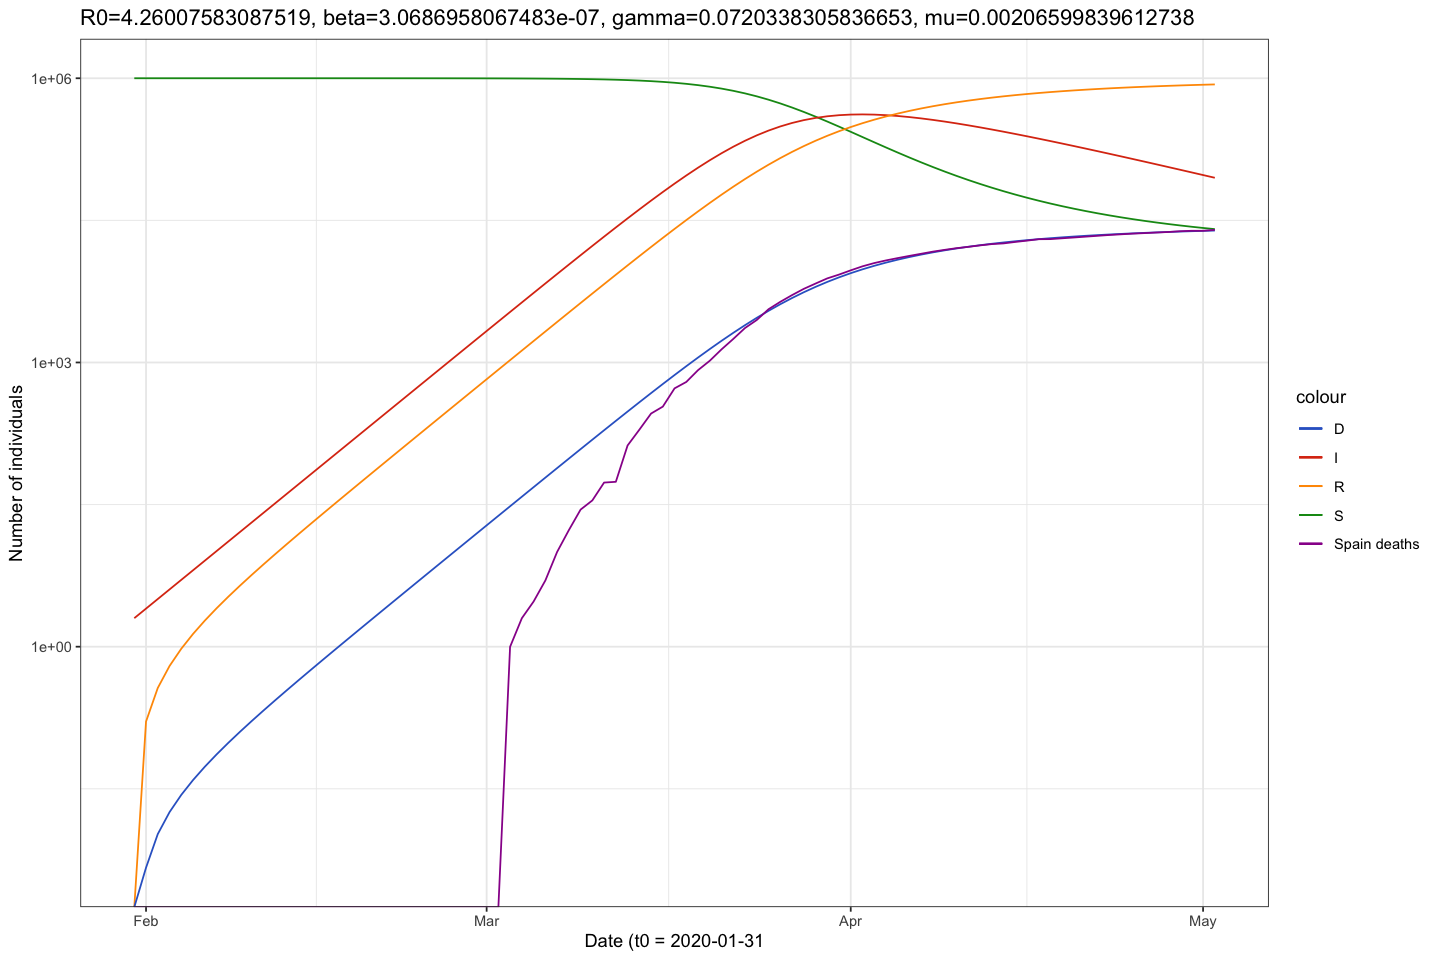

In [576]:
# plot the simulated data compared to the observed data (log transformed)
p <- ggplot(join(pred, mysite, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

##### Predicted probability distribution plot

Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


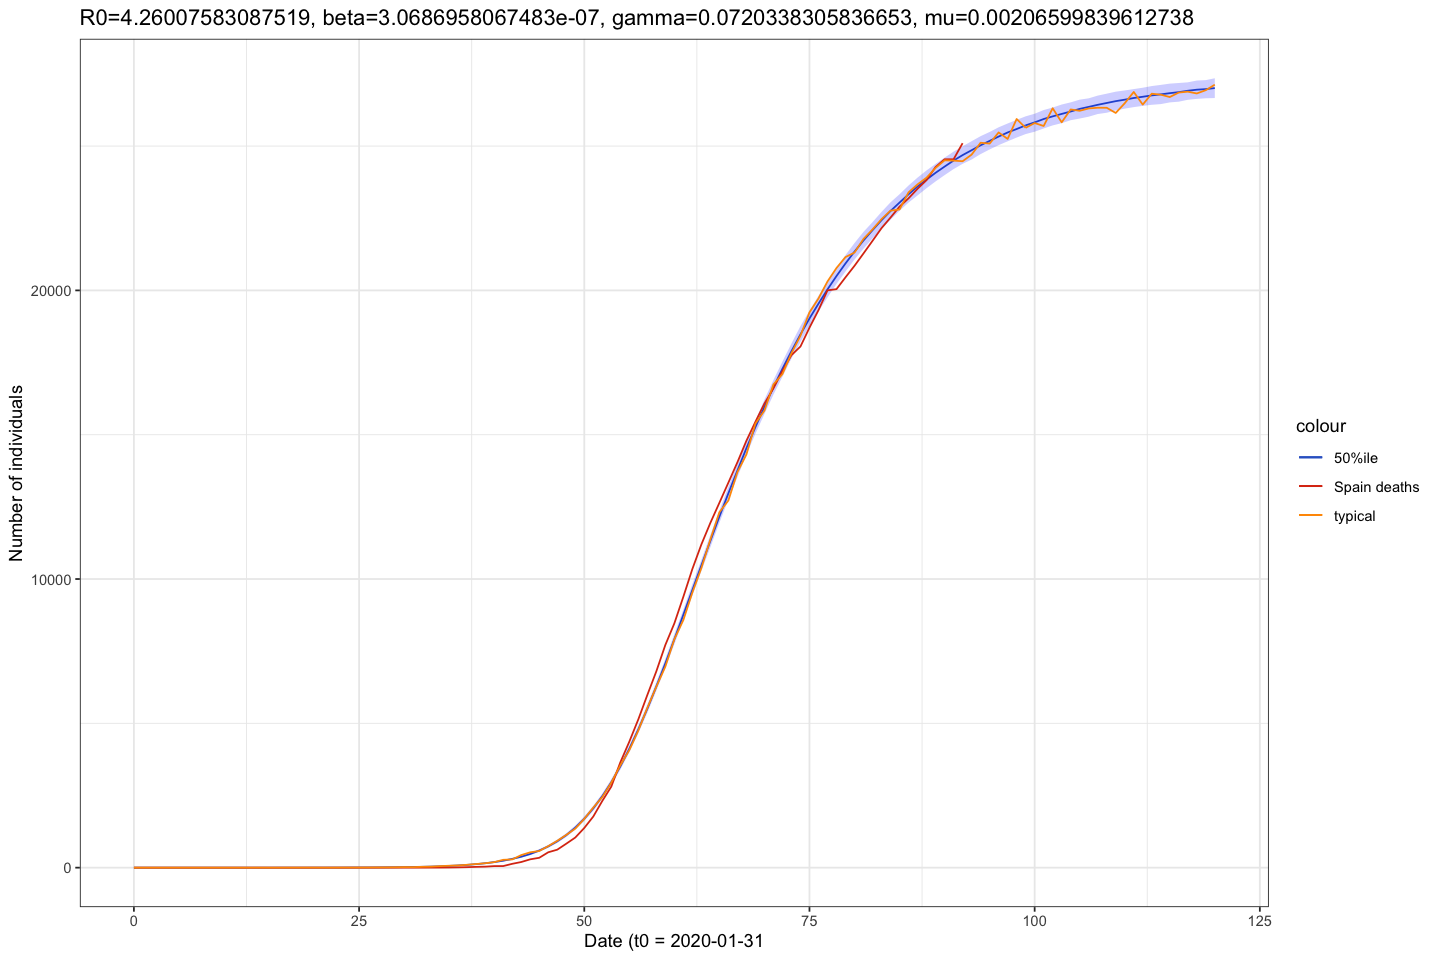

In [577]:
# run 2000 simulations of optimized parameters

raply(2000,rpois(n=length(pred$D),lambda=p.scale * pred$D)) -> simdat
aaply(simdat,2,quantile,probs=c(0.025,0.5,0.975)) -> quantiles

typ <- sample(nrow(simdat),1)

p <- ggplot(data=cbind(join(pred, mysite, by='t'),
                       quantiles,
                       typical=simdat[typ,]),
            mapping=aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=`50%`, col='50%ile'))
p <- p + geom_ribbon(aes(ymin=`2.5%`,ymax=`97.5%`), fill='blue', alpha=0.2)
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + geom_line(aes(y=typical, col='typical'))
p <- p + labs(y="Deaths",x="t")
# p <- p + scale_x_continuous(limit=c(70,80))
# p <- p + scale_y_continuous(limit=c(1.2e4,1.7e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

## Germany

- Poisson error model
- Max log-likelihood of $\beta$, $\mu$, $\gamma$

##### Model

In [578]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [579]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [580]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-31, as this was the date of first confirmed positive case (German tourist in the Canary Islands).

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Spain#First_cases_(31_January_%E2%80%93_25_February)

In [581]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1
p.scale <- 1 # lambda scaling coefficient for Poisson distribution

t0 <- as.Date('2020-01-31')
I0 <- 2


##### Observed

In [582]:
# Select data from JHU dataset

subset(gdeath, region=='Germany') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> mysite
mysite.name <- 'Germany'

##### Functions

In [583]:
# log likelihood function
poisson.loglik <- function (params, site) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    
    sum(dpois(x=site$death,
              lambda=params["p.scale"]*subset(s, t >= min(site$t) & t <= max(site$t))$D,
              log=TRUE))
}

In [584]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f5 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), p.scale=p.scale)
    -poisson.loglik(params, mysite)
}

##### Optimization

In [585]:
# params: beta, gamma, mu
fit5 <- optim(f5, par=c(log(3e-7), log(1/30), log(1e-3)))
fit5

opt <- fit5$par
R0 <- exp(opt[1]) * N / exp(opt[2])

R0

$par
[1] -15.234104  -3.401773  -7.841767

$value
[1] 492.6652

$counts
function gradient 
     280       NA 

$convergence
[1] 0

$message
NULL

[1] 7.265808

In [586]:
mle1 <- c(beta=exp(opt[1]), gamma=exp(opt[2]), mu=exp(opt[3]))
signif(mle1,3)

beta    gamma       mu 
2.42e-07 3.33e-02 3.93e-04

In [587]:
opt

[1] -15.234104  -3.401773  -7.841767

##### Trajectory with optimized beta

In [588]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> pred

Warning message:
“Removed 82 row(s) containing missing values (geom_path).”
Warning message:
“Removed 73 row(s) containing missing values (geom_path).”
Warning message:
“Removed 63 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


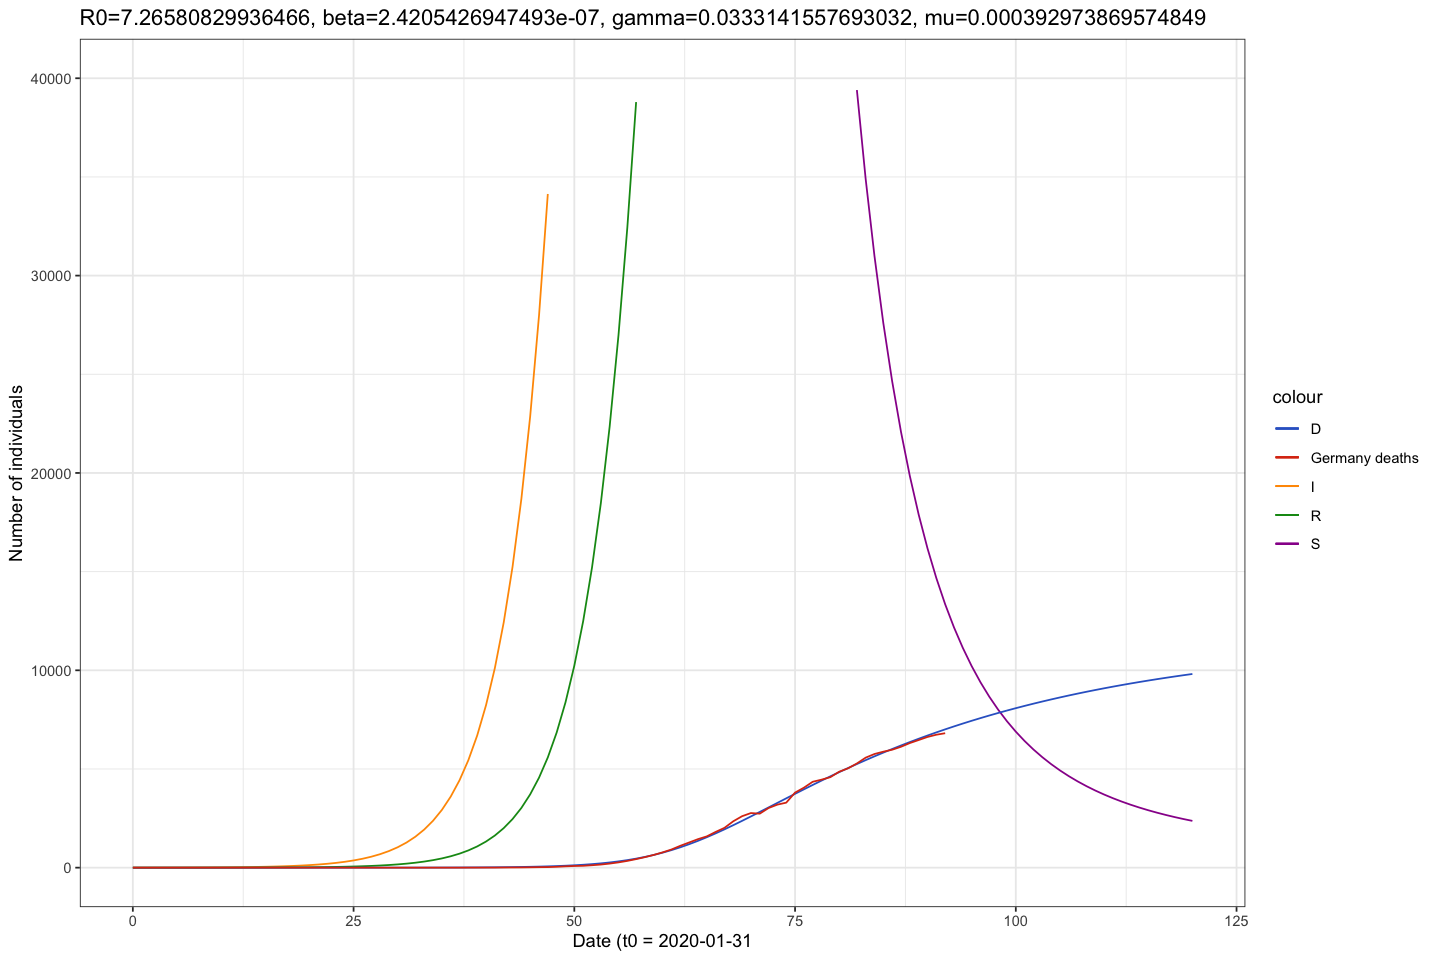

In [589]:
# plot the simulated data compared to the observed data
p <- ggplot(join(pred, mysite, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + scale_y_continuous(limits=c(0,4e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”
Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


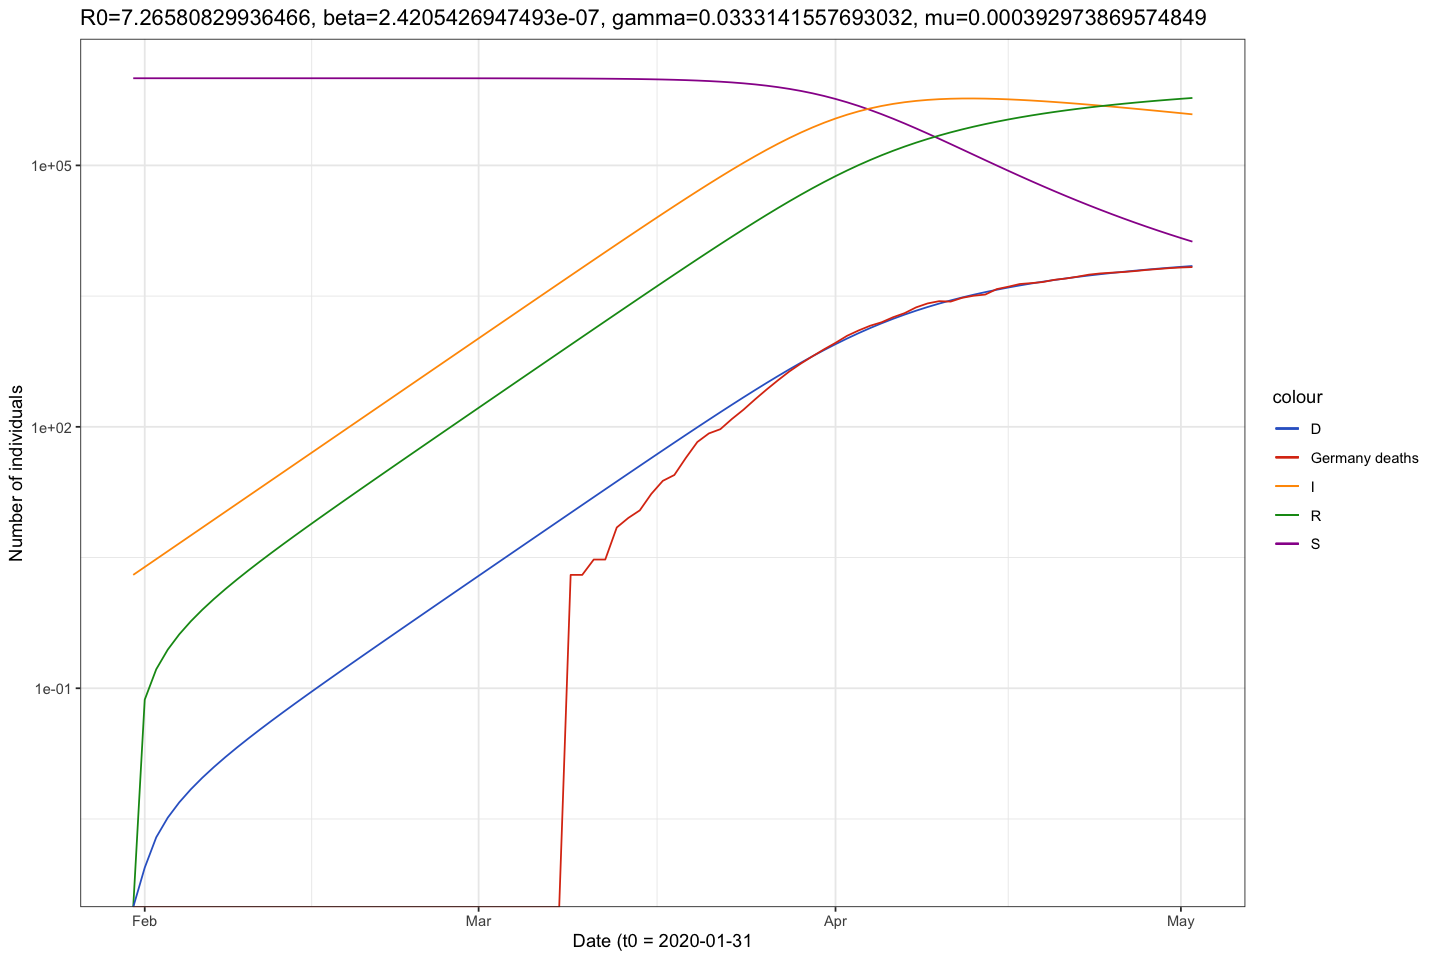

In [590]:
# plot the simulated data compared to the observed data (log transformed)
p <- ggplot(join(pred, mysite, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

##### Predicted probability distribution plot

Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


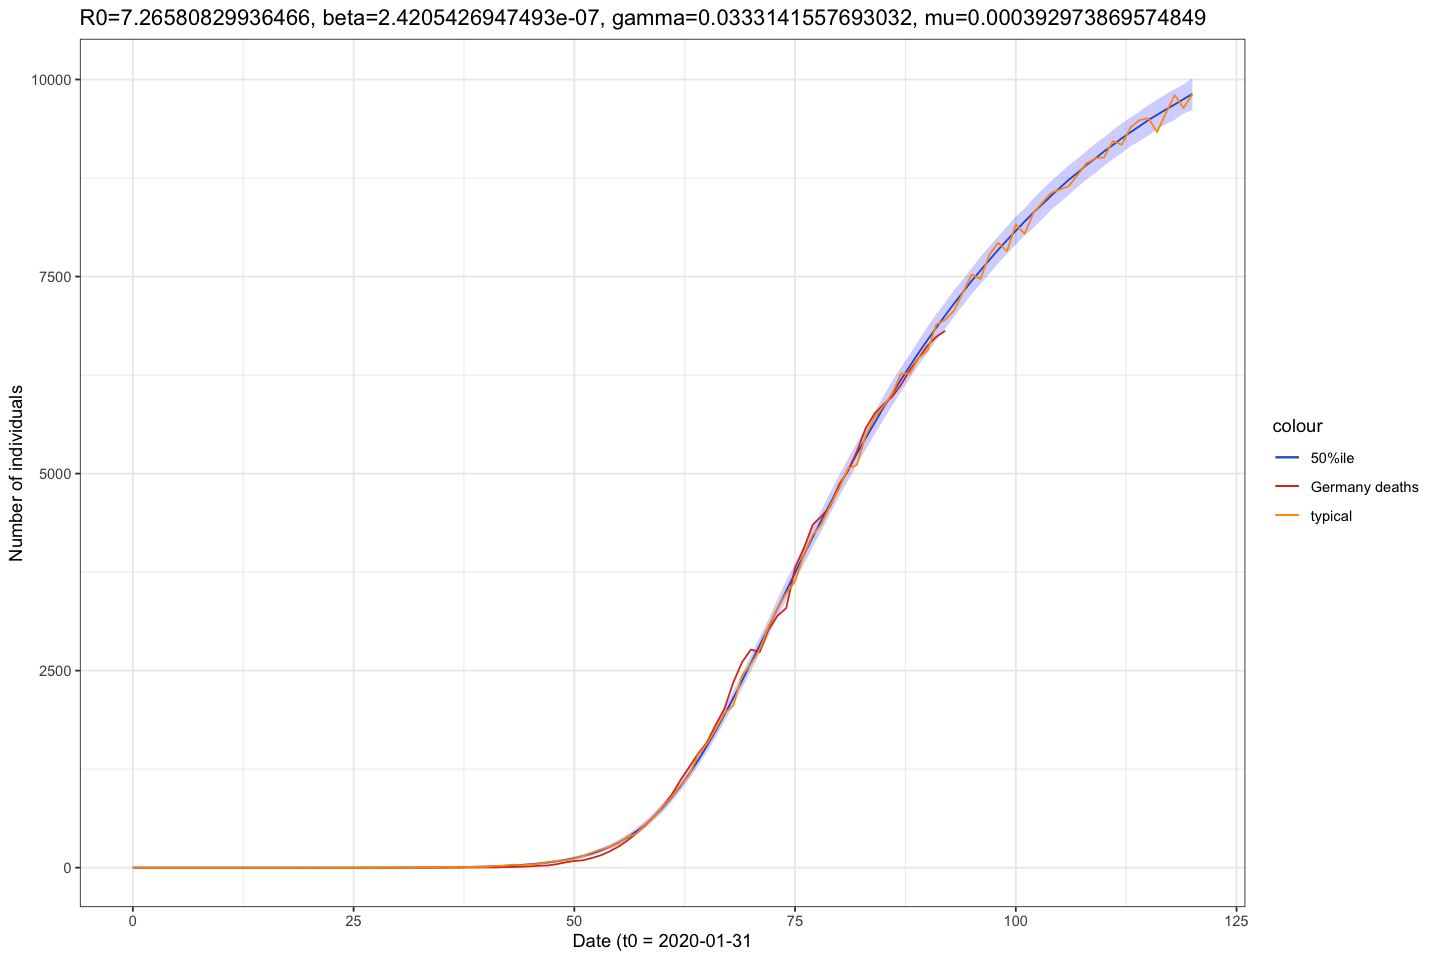

In [591]:
# run 2000 simulations of optimized parameters

raply(2000,rpois(n=length(pred$D),lambda=p.scale * pred$D)) -> simdat
aaply(simdat,2,quantile,probs=c(0.025,0.5,0.975)) -> quantiles

typ <- sample(nrow(simdat),1)

p <- ggplot(data=cbind(join(pred, mysite, by='t'),
                       quantiles,
                       typical=simdat[typ,]),
            mapping=aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=`50%`, col='50%ile'))
p <- p + geom_ribbon(aes(ymin=`2.5%`,ymax=`97.5%`), fill='blue', alpha=0.2)
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + geom_line(aes(y=typical, col='typical'))
p <- p + labs(y="Deaths",x="t")
# p <- p + scale_x_continuous(limit=c(70,80))
# p <- p + scale_y_continuous(limit=c(1.2e4,1.7e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

# Multiple sites for simultaneous parameter estimation

Here, we'll assess multiple local sites simultaneously while fixing disease specific variable ($\beta$, $\gamma$, $\mu$) across all settings. This model makes the assumption that mortality, infectious period, and infectivity are stable across cultural/geographic boundaries. While this is somewhat unrealistic, it may inform some underlying characteristics of SARS-CoV-2.

##### Dataset choice

- $\ge$ 5 sites
- Sites should be relatively isolated
- Death data must be reliable
- Prefer mature curve (past inflection point)
- Similar access to healthcare, population demographics, ?climate

Also note that Johns Hopkins data is based on state-reported deaths. On 2020-04-05, the Council of State and Territorial Epidemiologists Centers advised states to include both confirmed and probable deaths. This leads to discrete jumps in the data (~4000 deaths added to NYC in 1 day) that may complicate analysis of the death trajectory (see [NYTimes vs JHU data](https://github.com/spencerwoody/covid19-data-comparsion)).

We'll start by fitting to U.S. cities based on the NYTimes data

Cities
- Detroit (Wayne County)
- Boston (Suffolk)
- New York City
- Philadelphia
- New Orleans
- Miami
- Chicago

Start at 10 deaths?


FIPS: https://www.rdocumentation.org/packages/maps/versions/3.3.0/topics/county.fips


In [7]:
# select cities

city.list <- c('Detroit', 'Boston', 'New York City', 'Philadelphia', 'New Orleans', 'Miami', 'Chicago')
fips2.list <- c('26163', '25025', 'nyc', '42101', '22071', '12086', '17031')

# join to nytimes data
cbind(city=city.list, fips2=fips2.list) %>%
as.data.frame() %>%
join(nyt, by='fips2') -> usdat
# mutate(t=as.numeric(date - t0)) %>%
# select(t, date, fips2, city, county, state, cases, deaths) %>%
# subset(t >=0 & t <= max_time) -> usdat

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


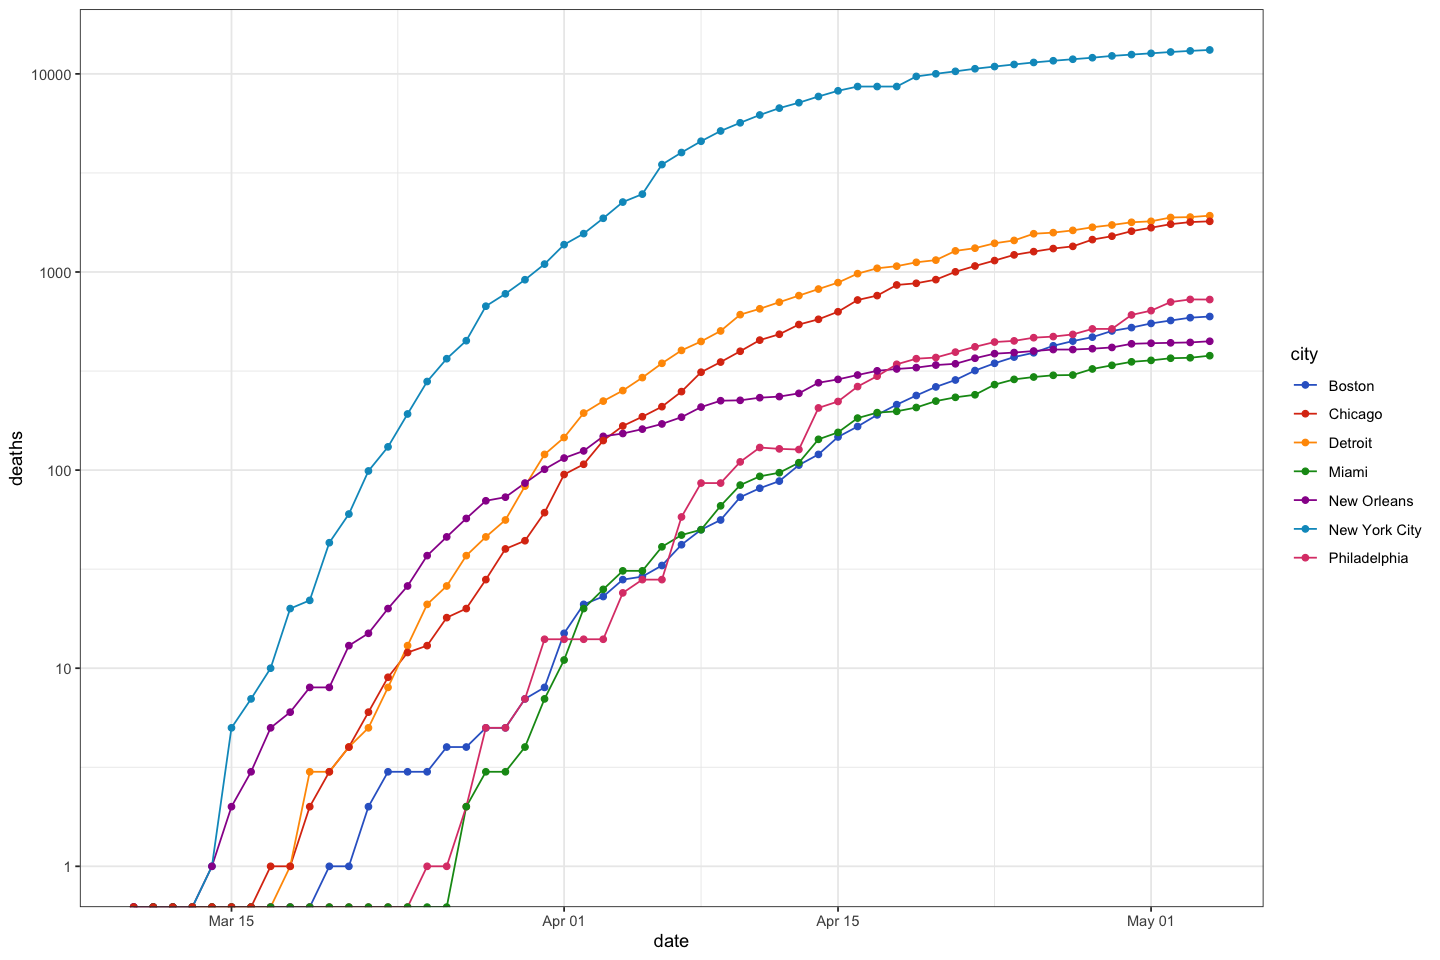

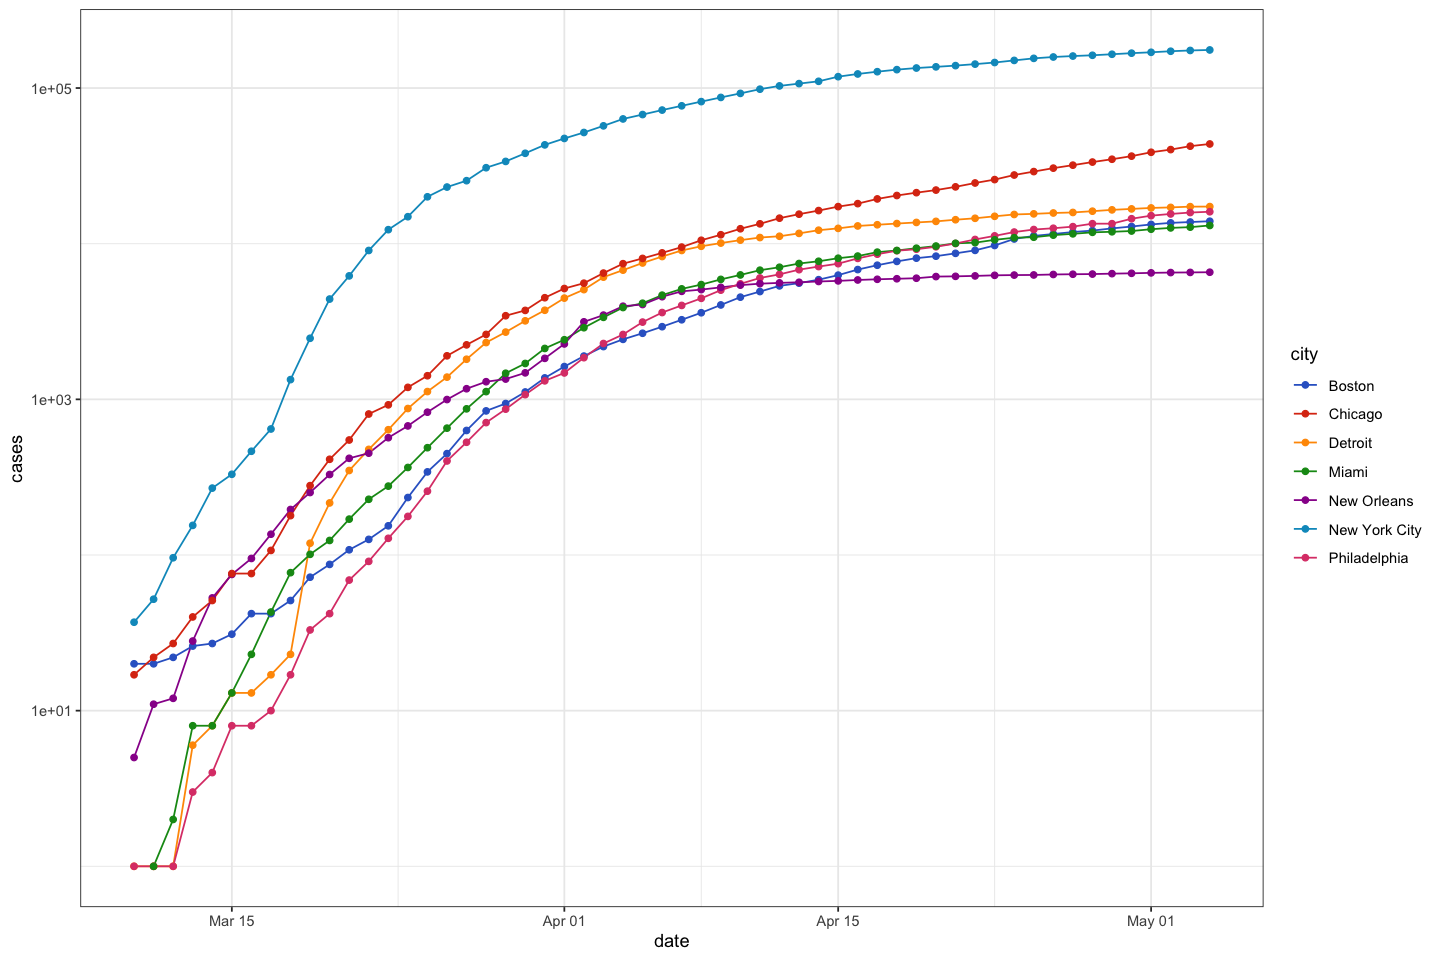

In [8]:
# Death and cases plots

# deaths
p <- ggplot(subset(usdat, date >= '2020-03-10'), aes(x=date, y=deaths, col=city))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line() + geom_point()
p <- p + scale_y_continuous(trans='log10')
p

# cases
p <- ggplot(subset(usdat, date >= '2020-03-10'), aes(x=date, y=cases, col=city))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line() + geom_point()
p <- p + scale_y_continuous(trans='log10')
p

##### Population data

NYC data is comprised of New York, Kings, Queens, Bronx and Richmond Counties [[source](https://en.wikipedia.org/wiki/Boroughs_of_New_York_City)]

| Borough  | County  | FIPS  |
|---|---|---|
| Bronx  | Bronx   | 36005  |
| Brooklyn | Kings | 36047 |
| Queens  | Queens  | 36081  | 
| Manhattan  | New York  |  36061 |
| Staten Island  | Richmond  | 36085  |   |

fips2 state         county              pop    
1 12086 Florida       Miami-Dade County   2716940
2 17031 Illinois      Cook County         5150233
3 22071 Louisiana     Orleans Parish       390144
4 25025 Massachusetts Suffolk County       803907
5 26163 Michigan      Wayne County        1749343
6 42101 Pennsylvania  Philadelphia County 1584064
7 nyc   New York      NA                  8336817

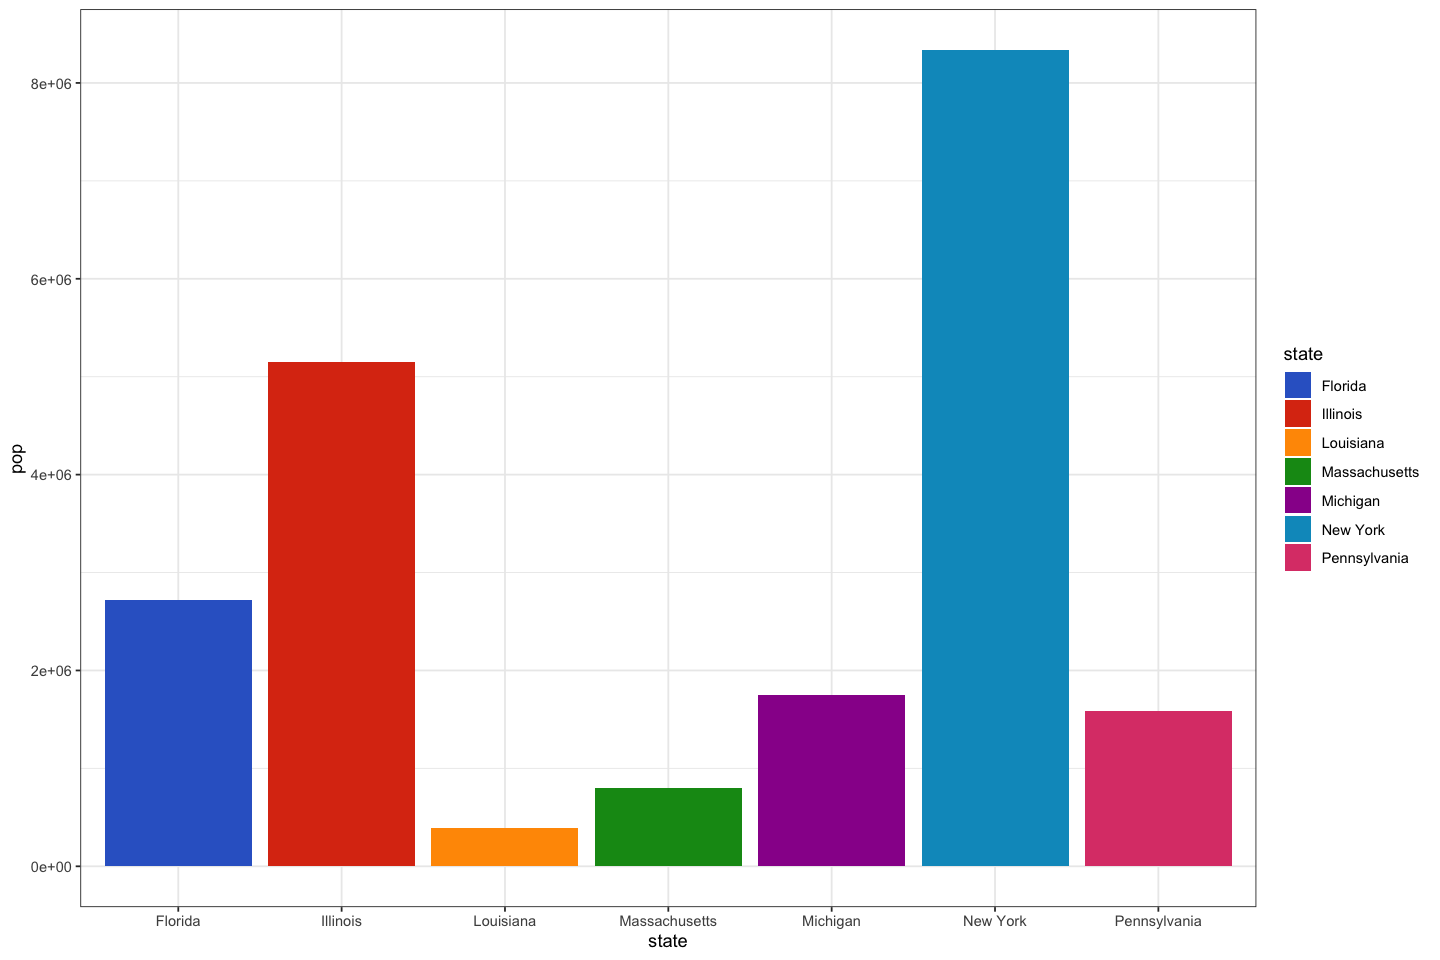

In [9]:
# Create pops data frame containing population data from the US census
nyc.fips <- c('36005', '36047', '36081', '36061', '36085')

census[census$fips %in% usdat$fips2,] %>%
rename(fips2=fips) %>%
rbind(data.frame(fips2='nyc', state='New York', county=NA, pop=sum(subset(census, fips %in% nyc.fips)$pop))) -> pops

pops

p <- ggplot(pops, aes(x=state, y=pop, fill=state))
p <- p + theme_bw() + scale_fill_gdocs()
p <- p + geom_bar(stat='identity')
p

## Fit 1: Varying t0

##### Model

In [10]:
m1 <- function(t, y, params) {
    beta <- params['beta']
    gamma <- params['gamma']
    mu <- params['mu']
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [11]:
# Solve ODE system using Runge-Kutta numerical method.
trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Functions

In [12]:
# extend the simulated data to match length of observed data
reconcile_sim <- function(sim, obs_start_t, obs_end_t) {
    # trim sim to not extend beyond obs
    sim <- subset(sim, t >= obs_start_t & t <= obs_end_t)
    
    # extend sim to span entirety of obs
    sim_start_t <- sim[1,'t']
    sim_start_deaths <- sim[1,'D']
    sim_end_t <- tail(sim, 1)$t
    sim_end_deaths <- tail(sim, 1)$D
    
    append_start <- NULL
    append_end <- NULL
    
    if (sim_start_t > obs_start_t)
        append_start <- data.frame(t=obs_start_t:(sim_start_t-1), D=sim_start_deaths)
    if (sim_end_t < obs_end_t)
        append_end <- data.frame(t=(sim_end_t+1):obs_end_t, D=sim_end_deaths)
    
    return(rbind.fill(append_start, sim, append_end))
    
}

# reconcile_sim(pred, 10, 200) -> a
# a %>% head()
# a %>% tail()

In [13]:
# log likelihood function
poisson.loglik <- function (dat, N, params) {
    trajectory(
        model=m1,
        params=params,
        times=times + floor(params[["t_offset"]]),
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    s <- reconcile_sim(s, min(dat$t), max(dat$t))
    
    dpois(x=dat$deaths,
      lambda=params[["p.scale"]]*s$D,
      log=TRUE) %>%
    sum()
}

##### Variables

In [23]:
# Grid where to evaluate
max_time <- 200
resolution <- 1
times <- seq(0, max_time, by=resolution)

t_offset_min <- -50
t_offset_max <- 50
step <- 1

t0 <- as.Date('2020-01-20')
I0 <- 10

##### Observed

In [24]:
# select cities
city.list <- c('Detroit', 'Boston', 'New York City', 'Philadelphia', 'New Orleans', 'Miami', 'Chicago')
fips2.list <- c('26163', '25025', 'nyc', '42101', '22071', '12086', '17031')

# join to nytimes data
cbind(city=city.list, fips2=fips2.list) %>%
as.data.frame() %>%
join(nyt, by='fips2') %>%
mutate(t=as.numeric(date - t0)) %>%
select(t, date, fips2, city, county, state, cases, deaths) %>%
subset(t >=0 & t <= max_time) -> usdat

##### Optimization

For each city, estimate the optimal $t_0$ (time at which $I(t) = 10$) for fixed $R_0=2.5$, $\gamma = 0.1$, $\mu = 1 \times 10^{-4}$. $\beta$ varies according to population size $N$ for each city, given $R_0$.

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 152 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 row(s) containing missing values (geom_path).”


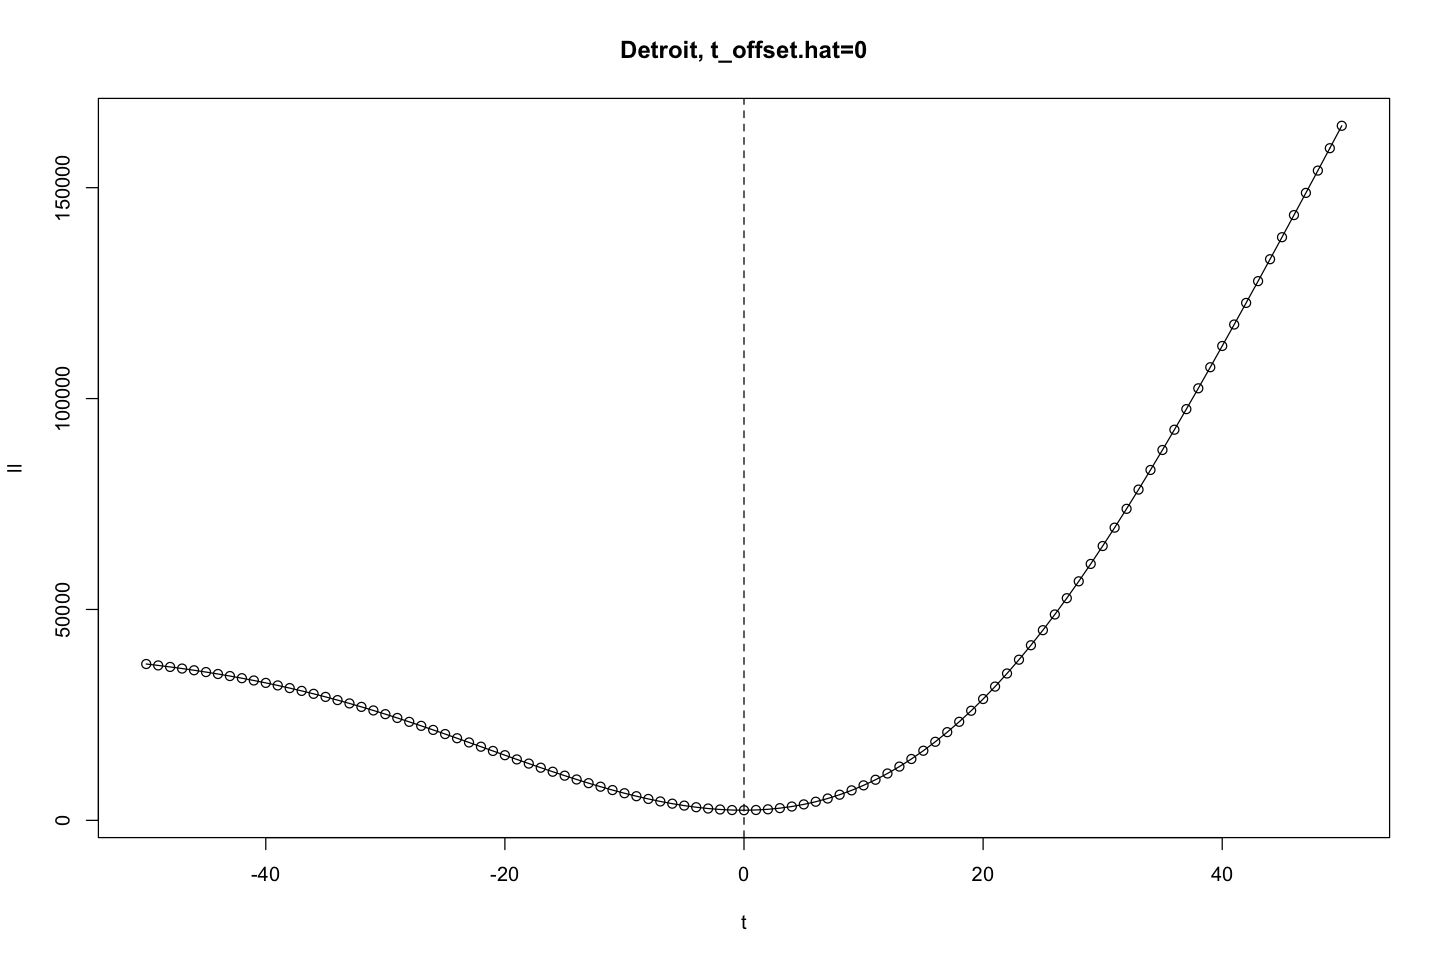

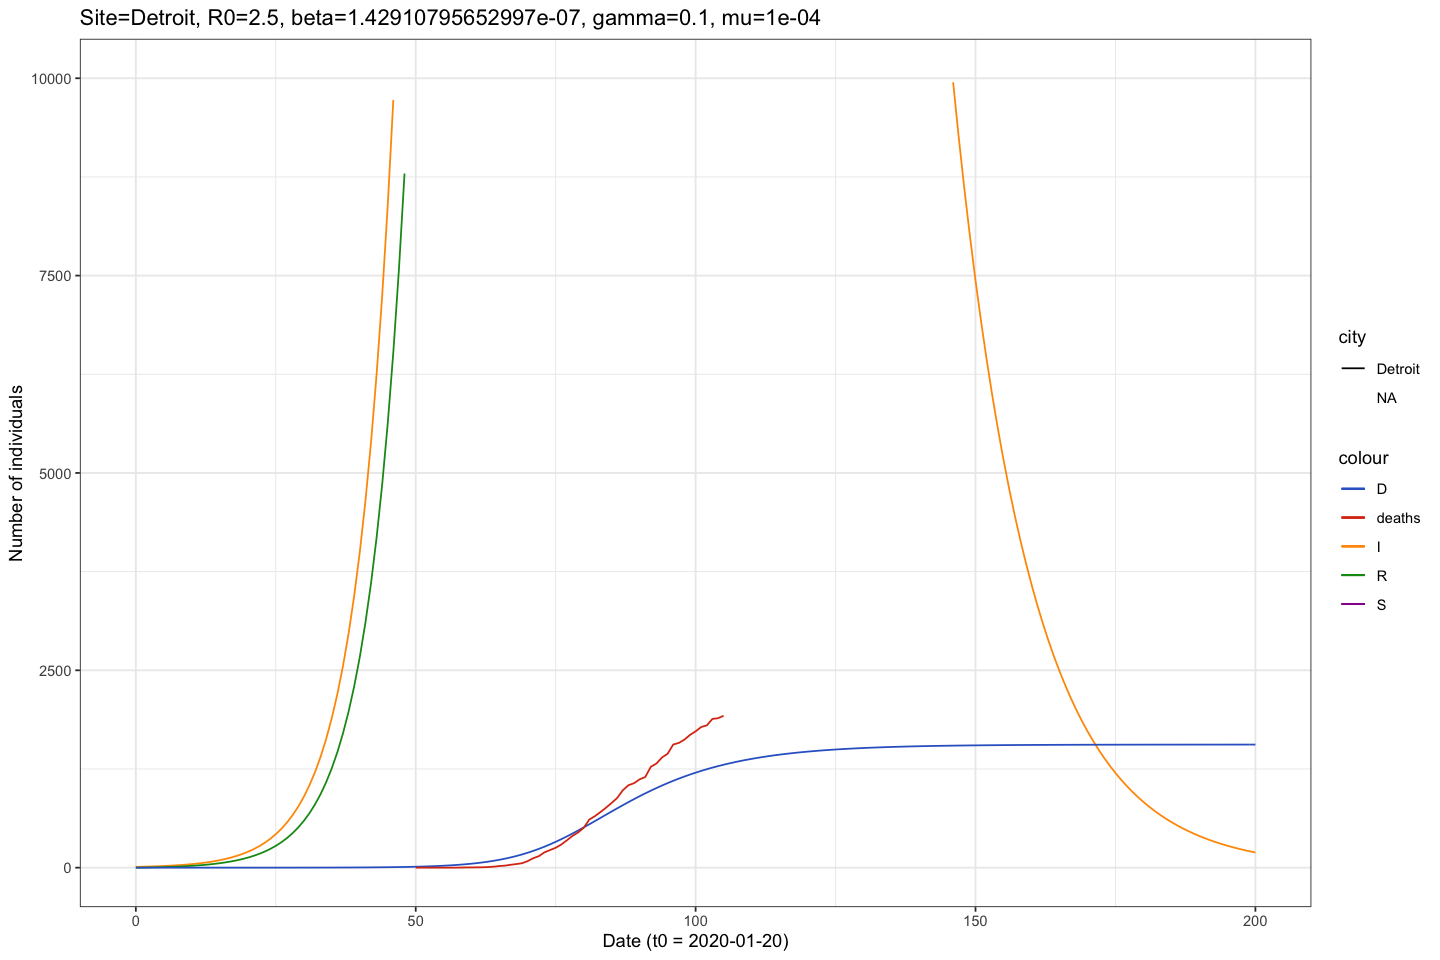

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 152 row(s) containing missing values (geom_path).”
Warning message:
“Removed 111 row(s) containing missing values (geom_path).”


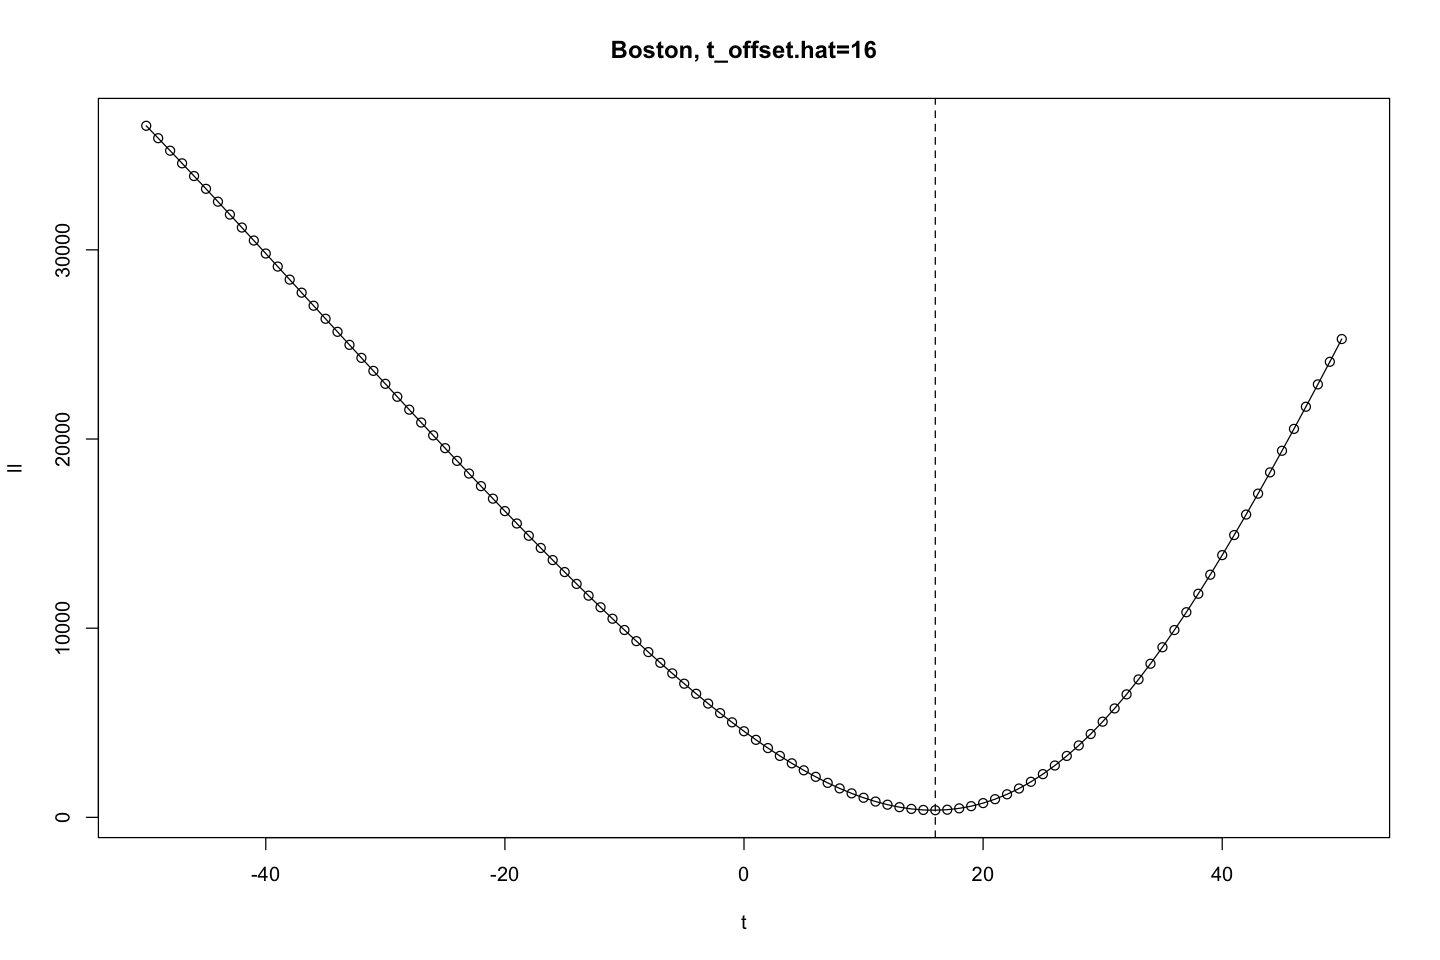

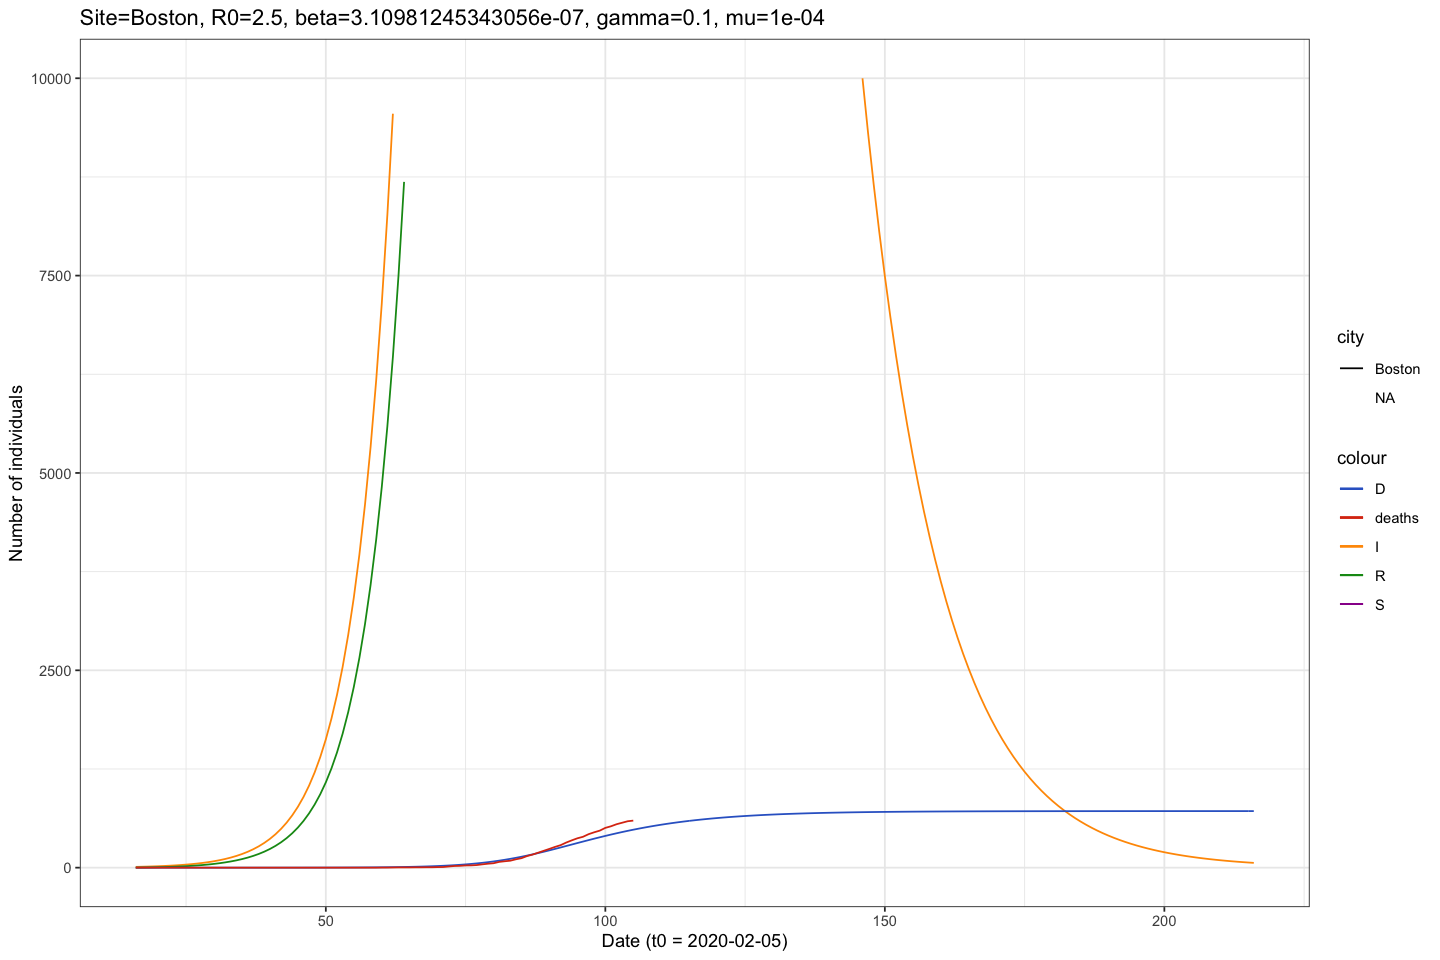

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 152 row(s) containing missing values (geom_path).”
Warning message:
“Removed 151 row(s) containing missing values (geom_path).”


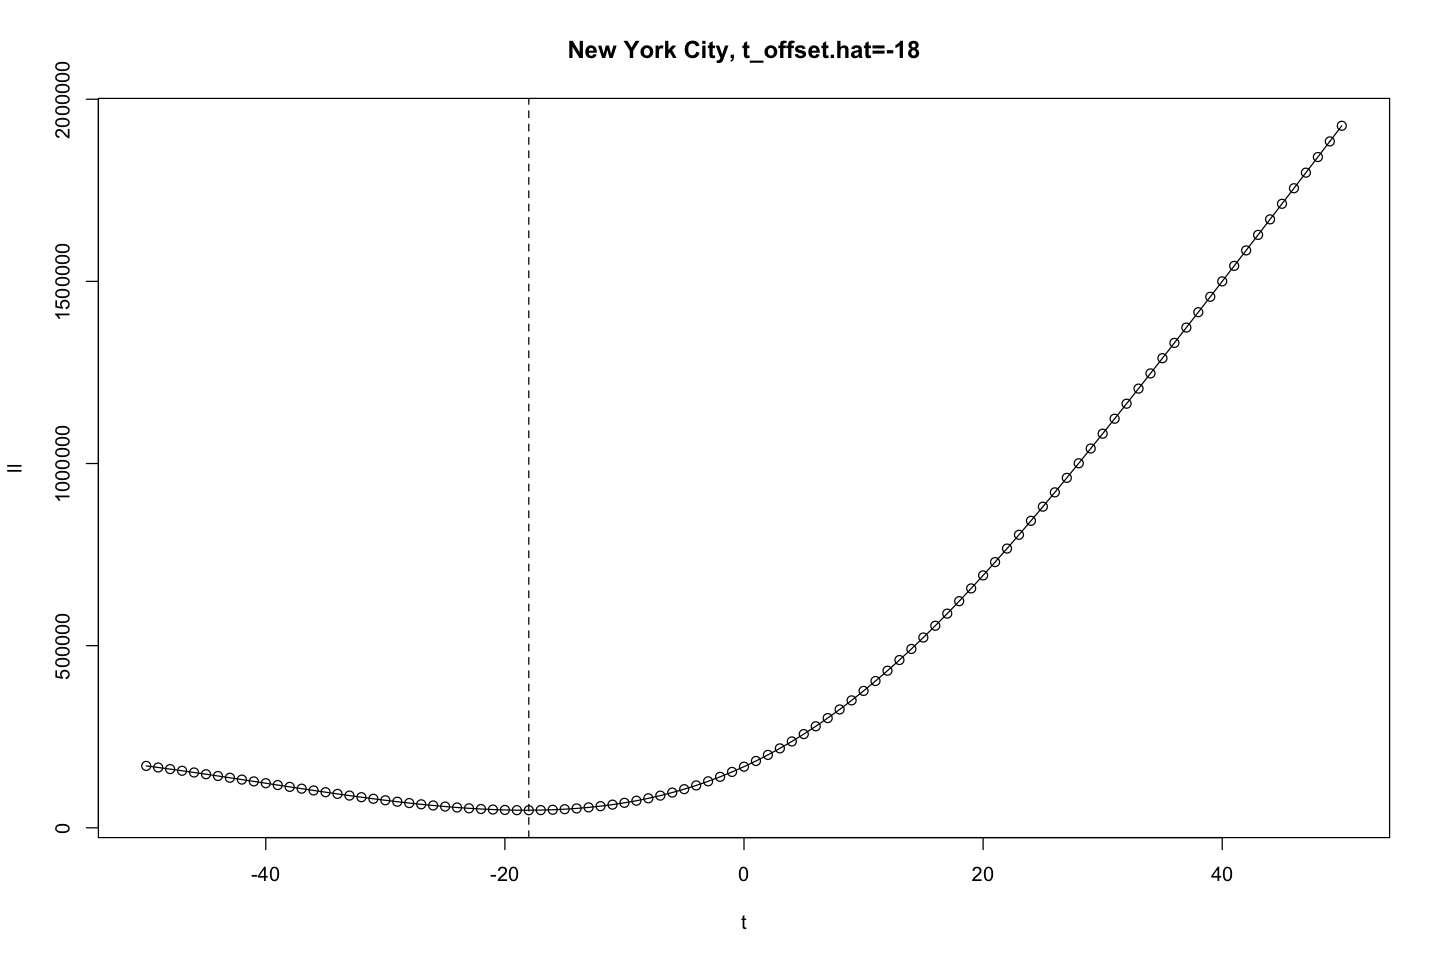

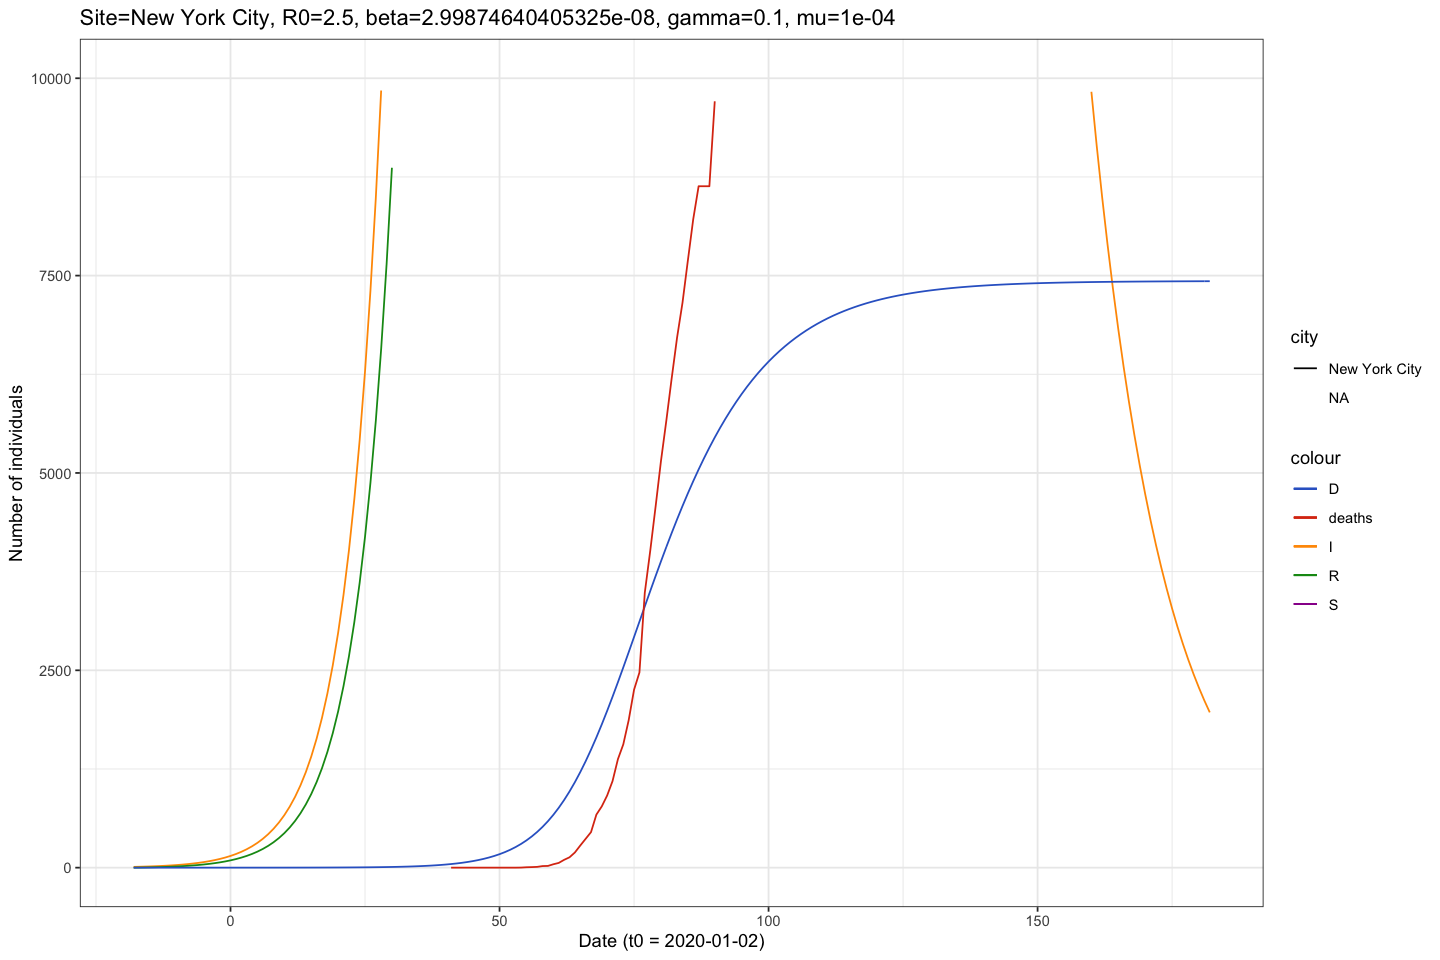

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 152 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 row(s) containing missing values (geom_path).”


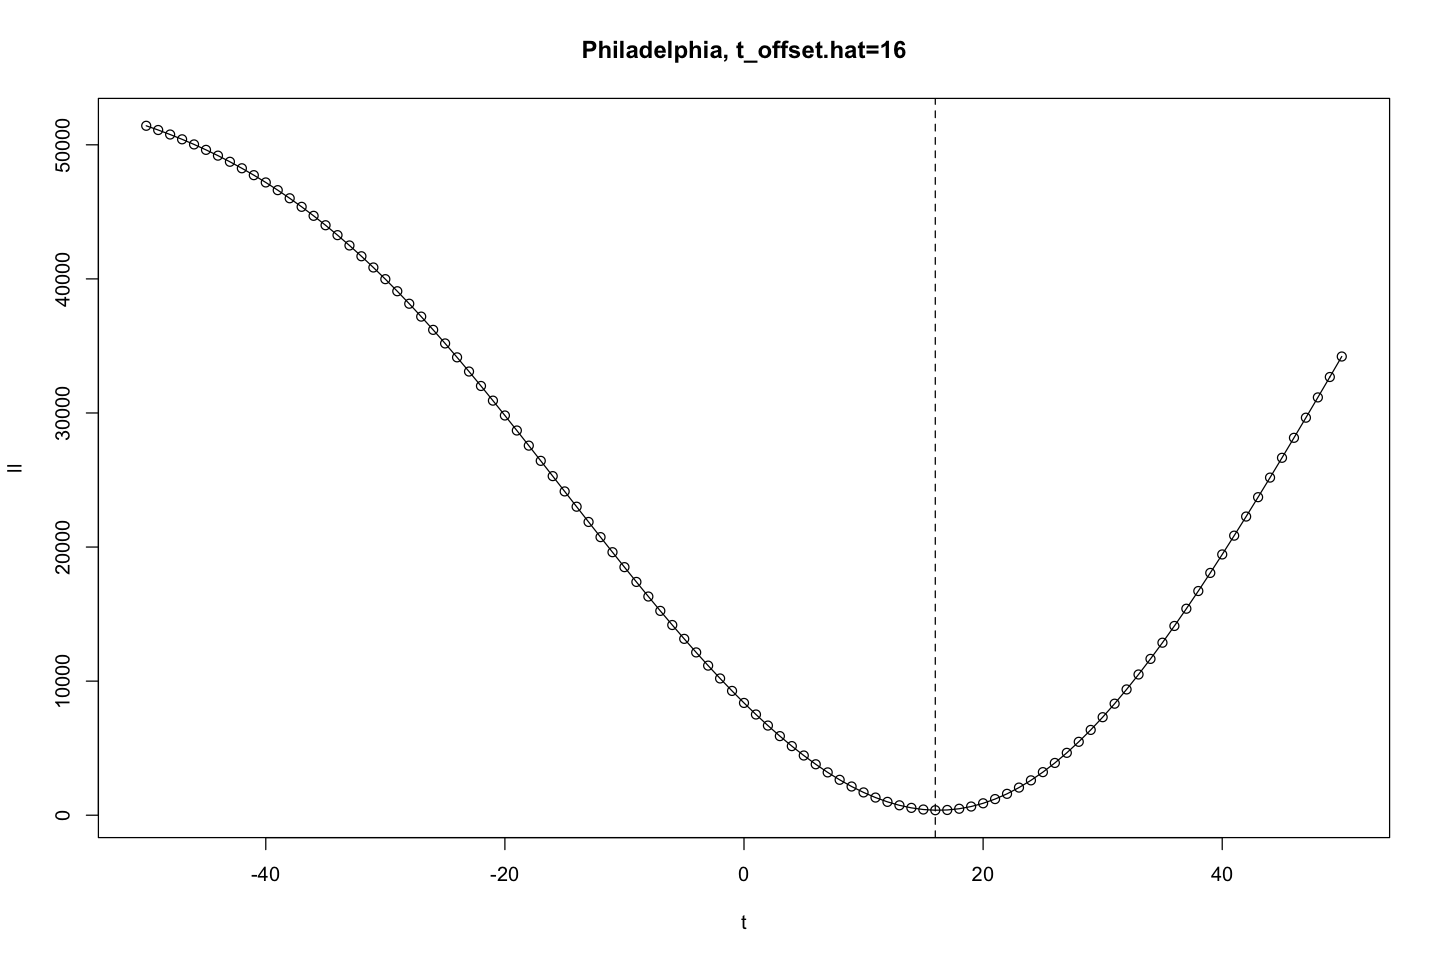

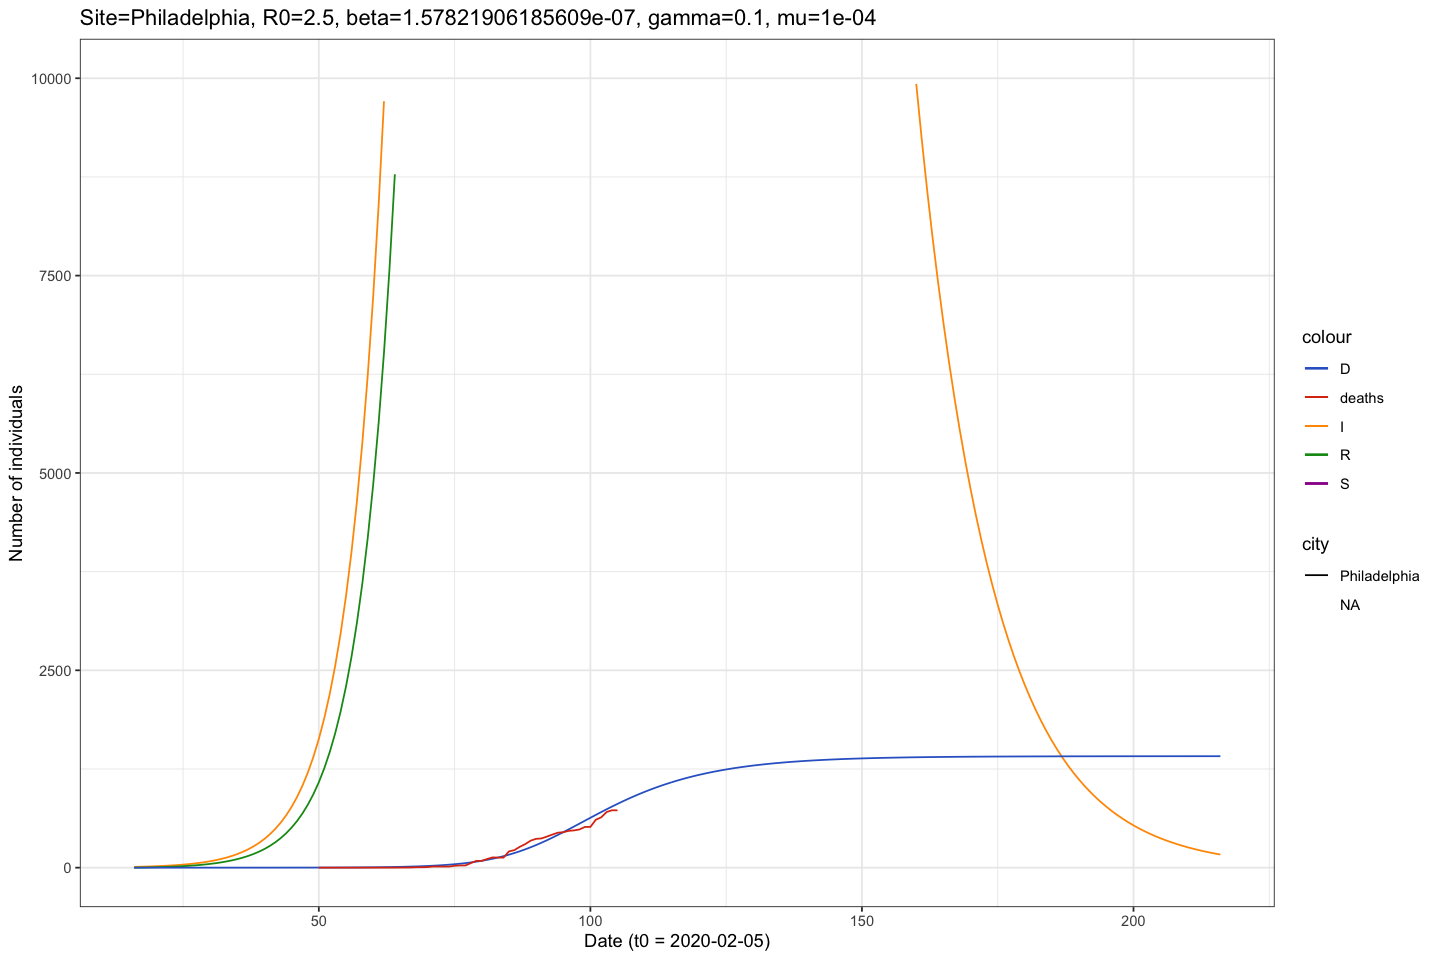

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 row(s) containing missing values (geom_path).”


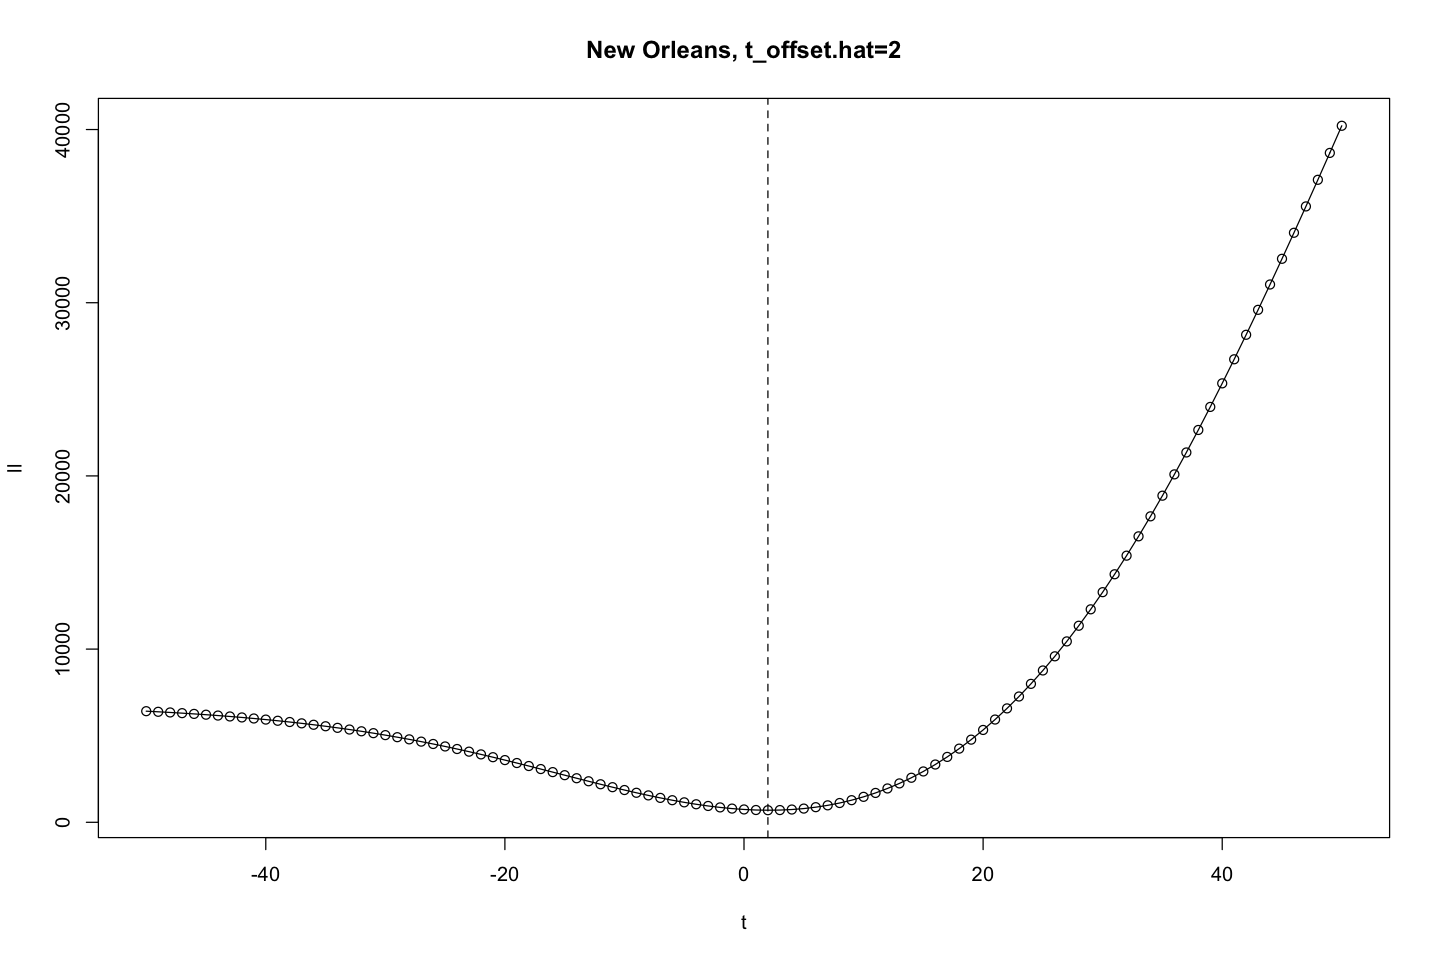

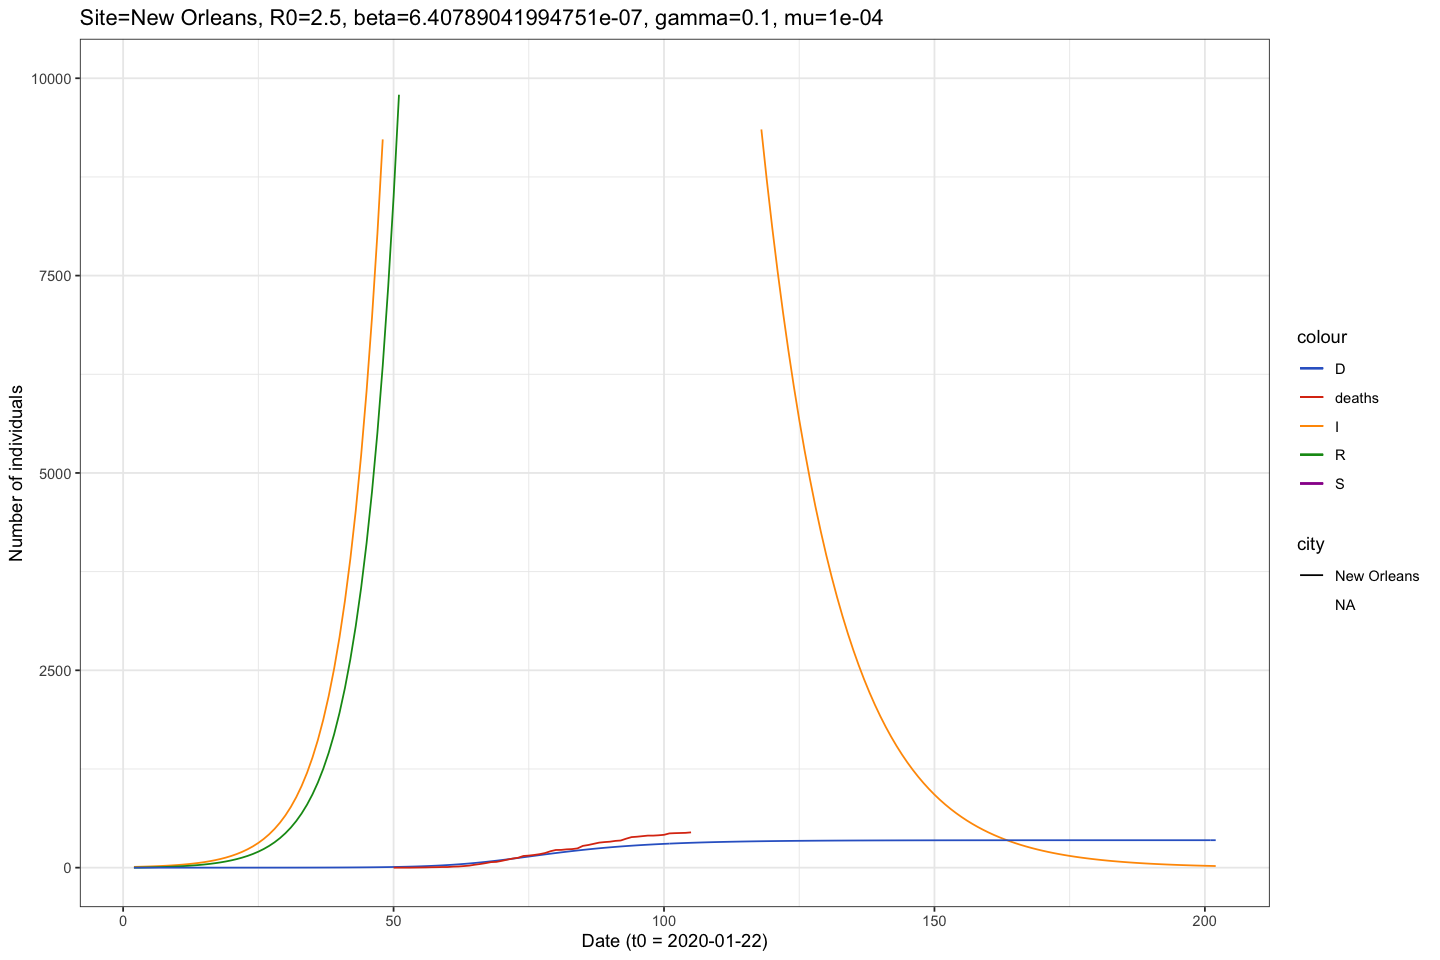

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 152 row(s) containing missing values (geom_path).”
Warning message:
“Removed 146 row(s) containing missing values (geom_path).”


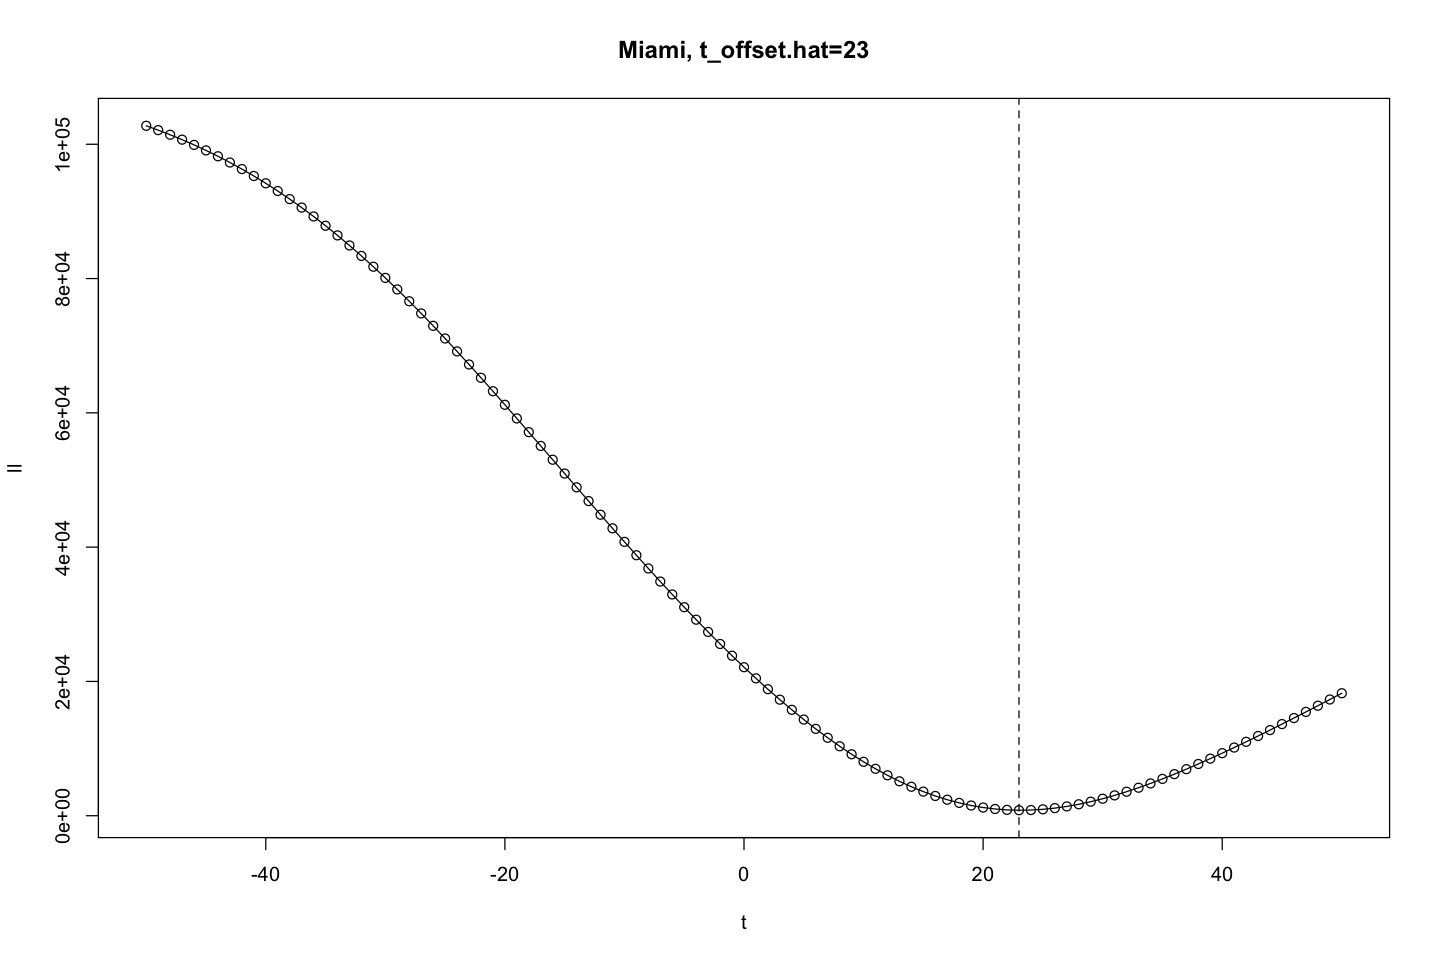

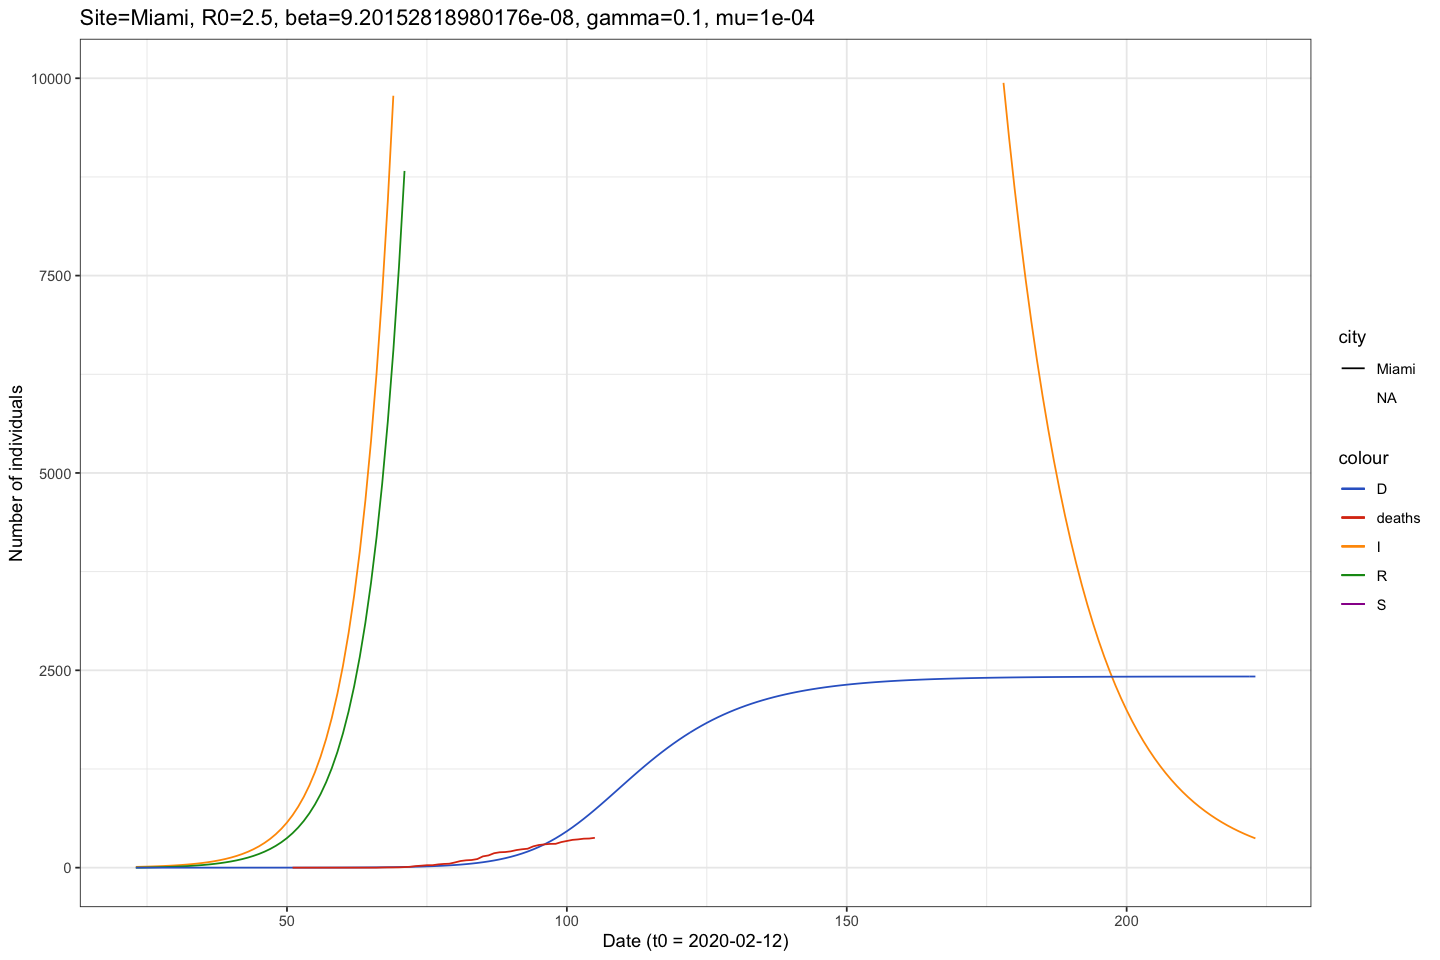

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 152 row(s) containing missing values (geom_path).”
Warning message:
“Removed 105 row(s) containing missing values (geom_path).”


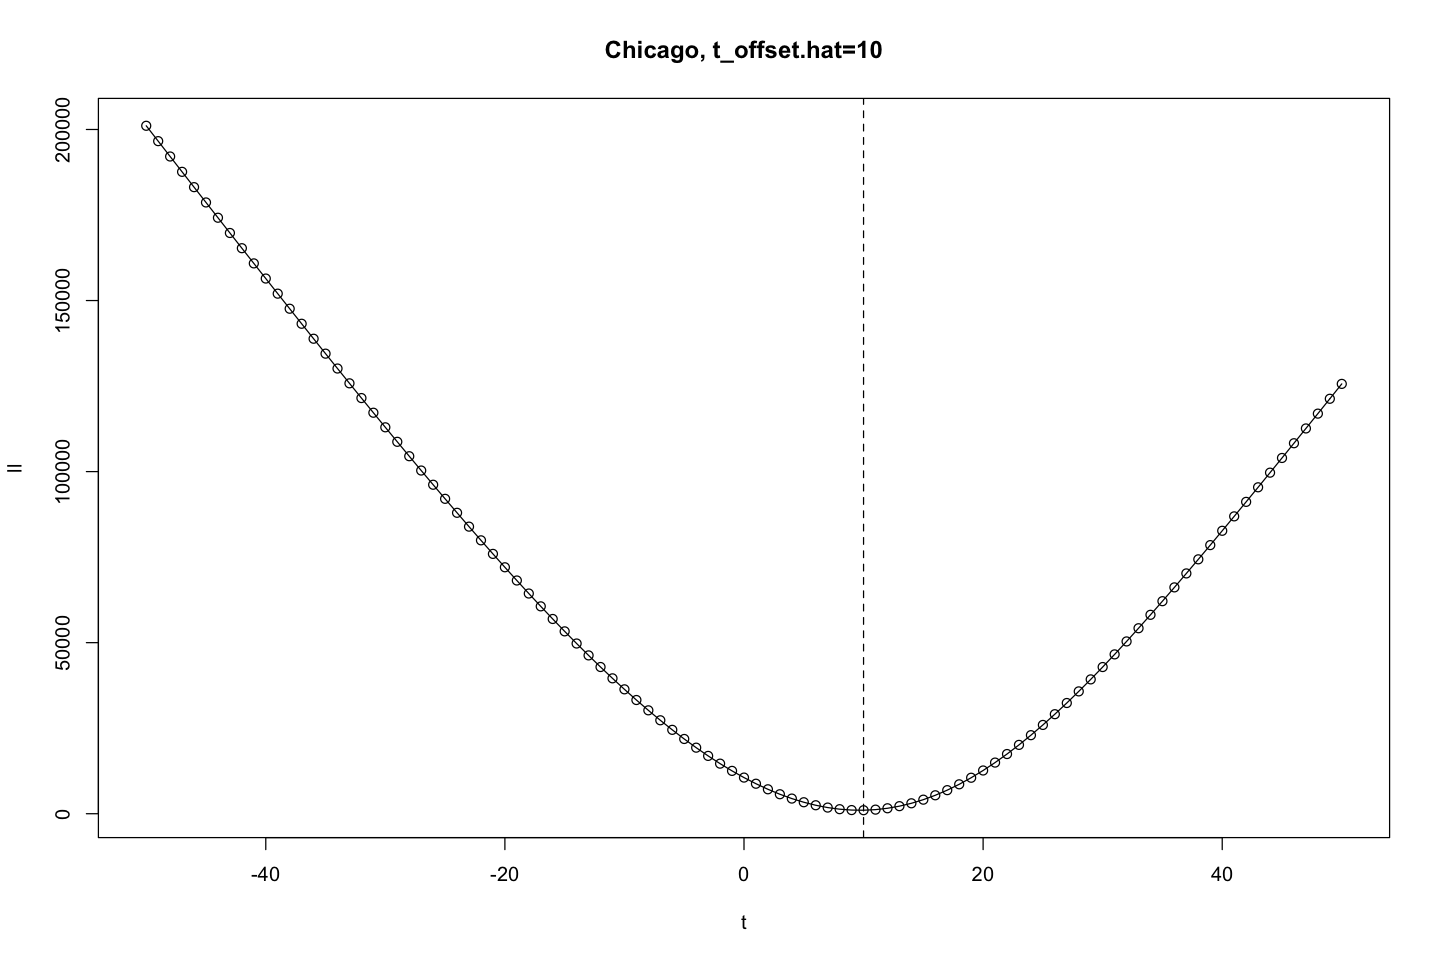

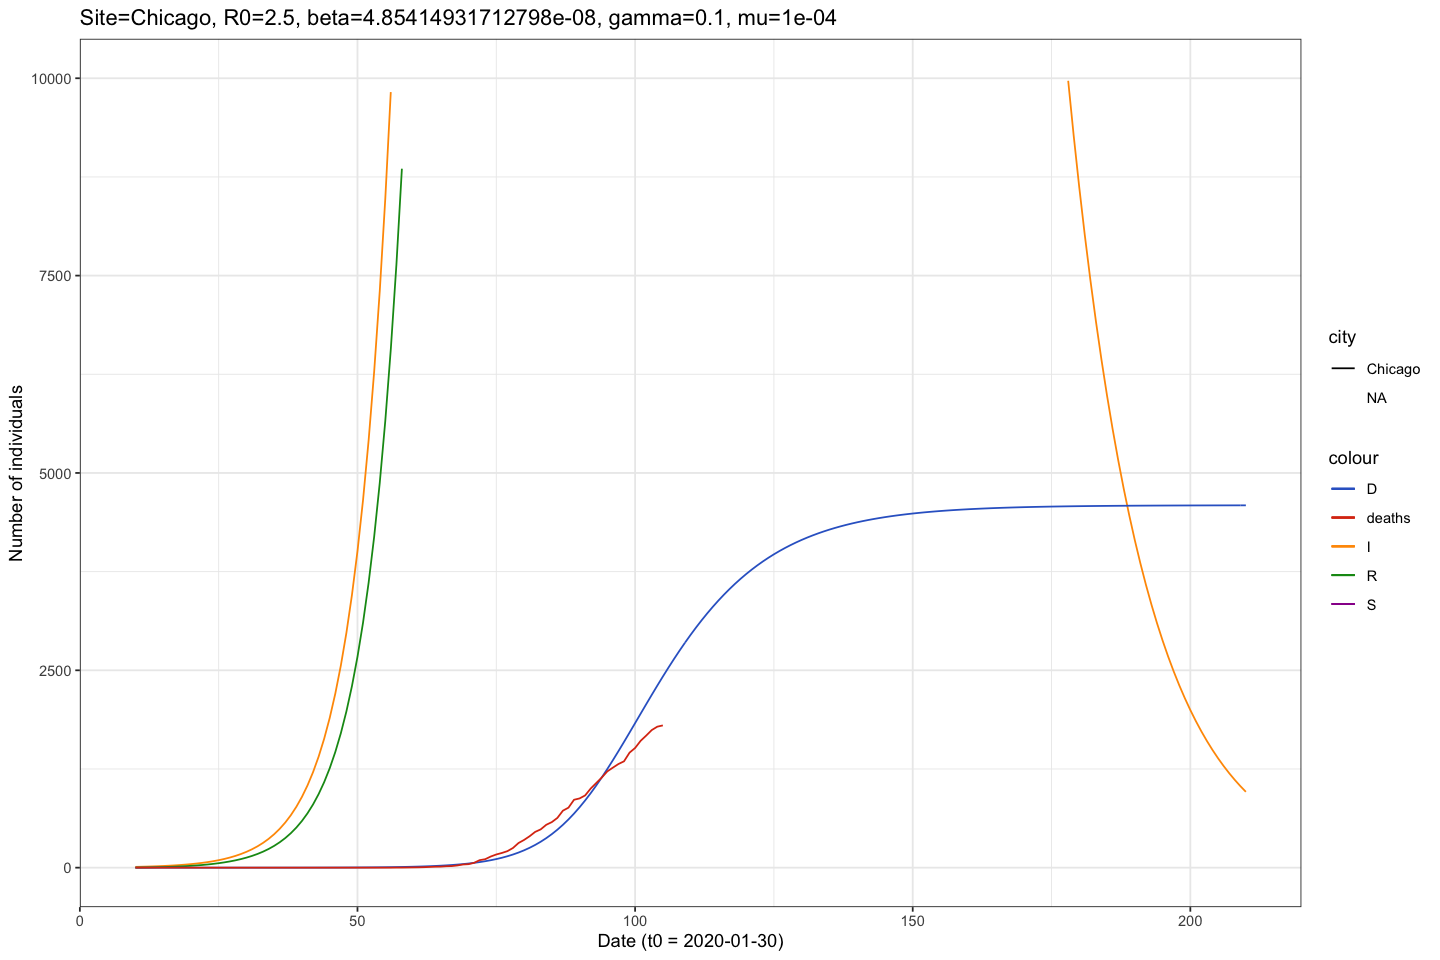

In [34]:
city.list <- c('Detroit', 'Boston', 'New York City', 'Philadelphia', 'New Orleans', 'Miami', 'Chicago')
fips2.list <- c('26163', '25025', 'nyc', '42101', '22071', '12086', '17031')

for (s in fips2.list) {
    city <- subset(usdat, fips2==s)[1, 'city']
    N <- pops[pops$fips2==s,]$pop

    R0 <- 2.5
    gamma0 <- 1e-1
    mu0 <- 1e-4
    beta0 <- R0*gamma0/N
    p.scale <- 1 # lambda scaling coefficient for Poisson distribution

    t_opt <- function(t_offset) {
        params <- c(beta=beta0, gamma=gamma0, mu=mu0, p.scale=1)
        params <- c(params, t_offset=t_offset)

        -poisson.loglik(subset(usdat, fips2==s), pops[pops$fips2==s,]$pop, params)
    }

    t <- seq(t_offset_min,t_offset_max,step)
    ll <- unlist(lapply(t, function(x) t_opt(x)))
    t_offset.hat <- t[which.min(ll)]

    beta.hat <- beta0
    gamma.hat <- gamma0
    mu.hat <- mu0
    R0.hat <- beta.hat*N/gamma.hat

    # plot t_offset curve
    plot(t, ll, type='o', main=paste0(city, ', t_offset.hat=', t_offset.hat))
    abline(v=t_offset.hat, lty=2)

    # get optimized trajectory
    trajectory(
        model=m1,
        params=c(beta=beta.hat, gamma=gamma.hat, mu=mu.hat),
        times=times + t_offset.hat,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> pred

    # plot the simulated data compared to the observed data
    p <- ggplot(join(pred, subset(usdat, fips2==s), by='t'), aes(x=t))
    p <- p + theme_bw() + scale_color_gdocs()
    p <- p + geom_line(aes(y=S, col='S'))
    p <- p + geom_line(aes(y=I, col='I'))
    p <- p + geom_line(aes(y=R, col='R'))
    p <- p + geom_line(aes(y=D, col='D'))
    p <- p + geom_line(aes(y=deaths, col='deaths', linetype=city))
    p <- p + scale_y_continuous(limits=c(0,1e4))
    # p <- p + scale_y_continuous(trans='log10')
    p <- p + ggtitle(paste0('Site=', city, ', R0=', R0.hat, ', beta=', beta.hat, ', gamma=', gamma.hat, ', mu=', mu.hat))
    p <- p + xlab(paste0('Date (t0 = ', t0 + t_offset.hat, ')')) + ylab('Number of individuals')
    print(p)
}

## Fit 2: Optim - Estimating t0, beta, gamma, mu simultaneously

Our ultimate goal is to simultaneously estimate $\beta$ and $t_0$ for each city while estimating $\gamma$ and $\mu$ globally, since we might reasonable expect infectious period and mortality rate to be consistent across regions.

One challenge is that stimating discrete parameters ($t_0$) and continuous parameters ($\beta$, $\gamma$, $\mu$) simultaneously is difficult. Known as "mixed continous discrete nonlinear programming," and only a handful of optimization algorithms available.

Possible solutions
- `CEoptim` package for R uses cross-entropy optimization and can take both discrete and continuous parameters
- `optim` package (used above) works well for single variable discrete variable (falls apart with multiple). Can recursively use `optim` to solve for $t_0$, then other parameters (or vice versa). The downside is that this is quite slow
- [Other optimization packages in R](https://cran.r-project.org/web/views/Optimization.html)

For starters, we'll see if we can accomplish simultaneous estimation on a single city.

##### Model

In [35]:
m1 <- function(t, y, params) {
    beta <- params['beta']
    gamma <- params['gamma']
    mu <- params['mu']
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [36]:
# Solve ODE system using Runge-Kutta numerical method.
trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Functions

In [37]:
# extend the simulated data to match length of observed data
reconcile_sim <- function(sim, obs_start_t, obs_end_t) {
    # trim sim to not extend beyond obs
    sim <- subset(sim, t >= obs_start_t & t <= obs_end_t)
    
    # extend sim to span entirety of obs
    sim_start_t <- sim[1,'t']
    sim_start_deaths <- sim[1,'D']
    sim_end_t <- tail(sim, 1)$t
    sim_end_deaths <- tail(sim, 1)$D
    
    append_start <- NULL
    append_end <- NULL
    
    if (sim_start_t > obs_start_t)
        append_start <- data.frame(t=obs_start_t:(sim_start_t-1), D=sim_start_deaths)
    if (sim_end_t < obs_end_t)
        append_end <- data.frame(t=(sim_end_t+1):obs_end_t, D=sim_end_deaths)
    
    return(rbind.fill(append_start, sim, append_end))
    
}

# reconcile_sim(pred, 10, 200) -> a
# a %>% head()
# a %>% tail()

In [38]:
# log likelihood function
poisson.loglik <- function (dat, N, params) {
    trajectory(
        model=m1,
        params=params,
        times=times + floor(params[["t_offset"]]),
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    s <- reconcile_sim(s, min(dat$t), max(dat$t))
    
    dpois(x=dat$deaths,
      lambda=params[["p.scale"]]*s$D,
      log=TRUE) %>%
    sum()
}

##### Variables

In [67]:
# Grid where to evaluate
max_time <- 200
resolution <- 1
times <- seq(0, max_time, by=resolution)

t_offset_min <- -10
t_offset_max <- 50
step <- 1

t0 <- as.Date('2020-01-20')
I0 <- 10

##### Observed

In [68]:
# select cities
city.list <- c('Detroit', 'Boston', 'New York City', 'Philadelphia', 'New Orleans', 'Miami', 'Chicago')
fips2.list <- c('26163', '25025', 'nyc', '42101', '22071', '12086', '17031')

# join to nytimes data
cbind(city=city.list, fips2=fips2.list) %>%
as.data.frame() %>%
join(nyt, by='fips2') %>%
mutate(t=as.numeric(date - t0)) %>%
select(t, date, fips2, city, county, state, cases, deaths) %>%
subset(t >=0 & t <= max_time) -> usdat

##### Optimization

In [76]:
# optimization function
f6 <- function(params) {
    t_opt <- function(par.t_offset) {
        -poisson.loglik(dat = subset(usdat, fips2==s),
                   N = pops[pops$fips2==s,]$pop,
                   params = c(beta=beta0,
                              gamma=gamma0,
                              mu=mu0,
                              t_offset=par.t_offset,
                              p.scale=1))
    }

    fit9 <- optim(fn=t_opt,
                  par=t_offset0,
                  method='Brent',
                  lower=t_offset_min,
                  upper=t_offset_max)
    
#     fit9$par %>% print()
    -poisson.loglik(dat = subset(usdat, fips2==s),
               N = pops[pops$fips2==s,]$pop,
               params = c(beta=params[['beta']], gamma=params[['gamma']], mu=params[['mu']], t_offset=fit9$par, p.scale=1))
}

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 141 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 row(s) containing missing values (geom_path).”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x 

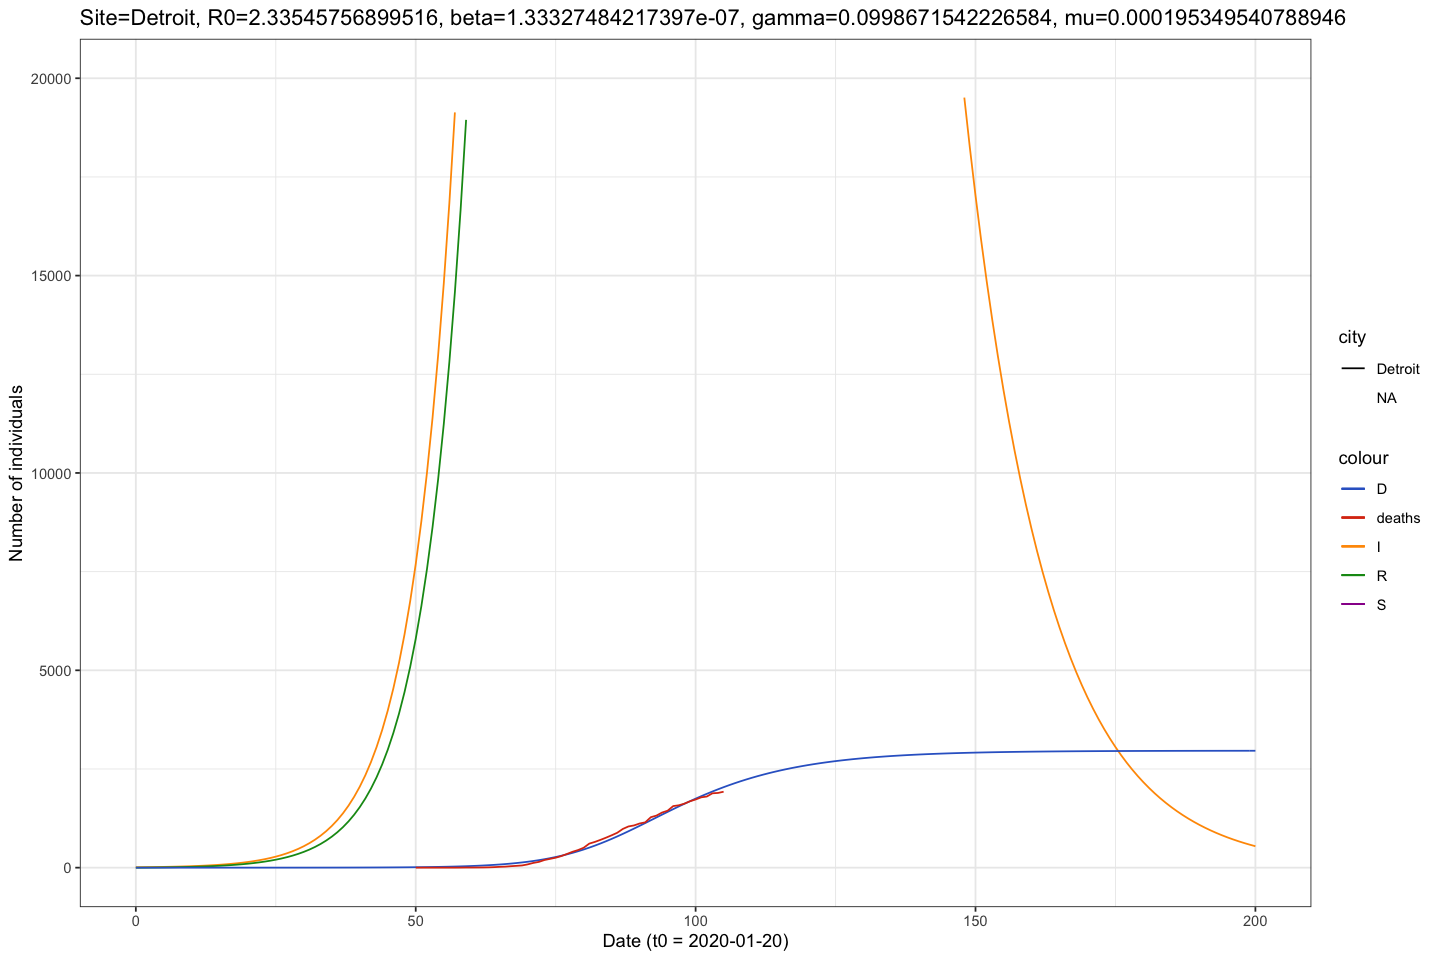

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 row(s) containing missing values (geom_path).”
Warning message:
“Removed 136 row(s) containing missing values (geom_path).”


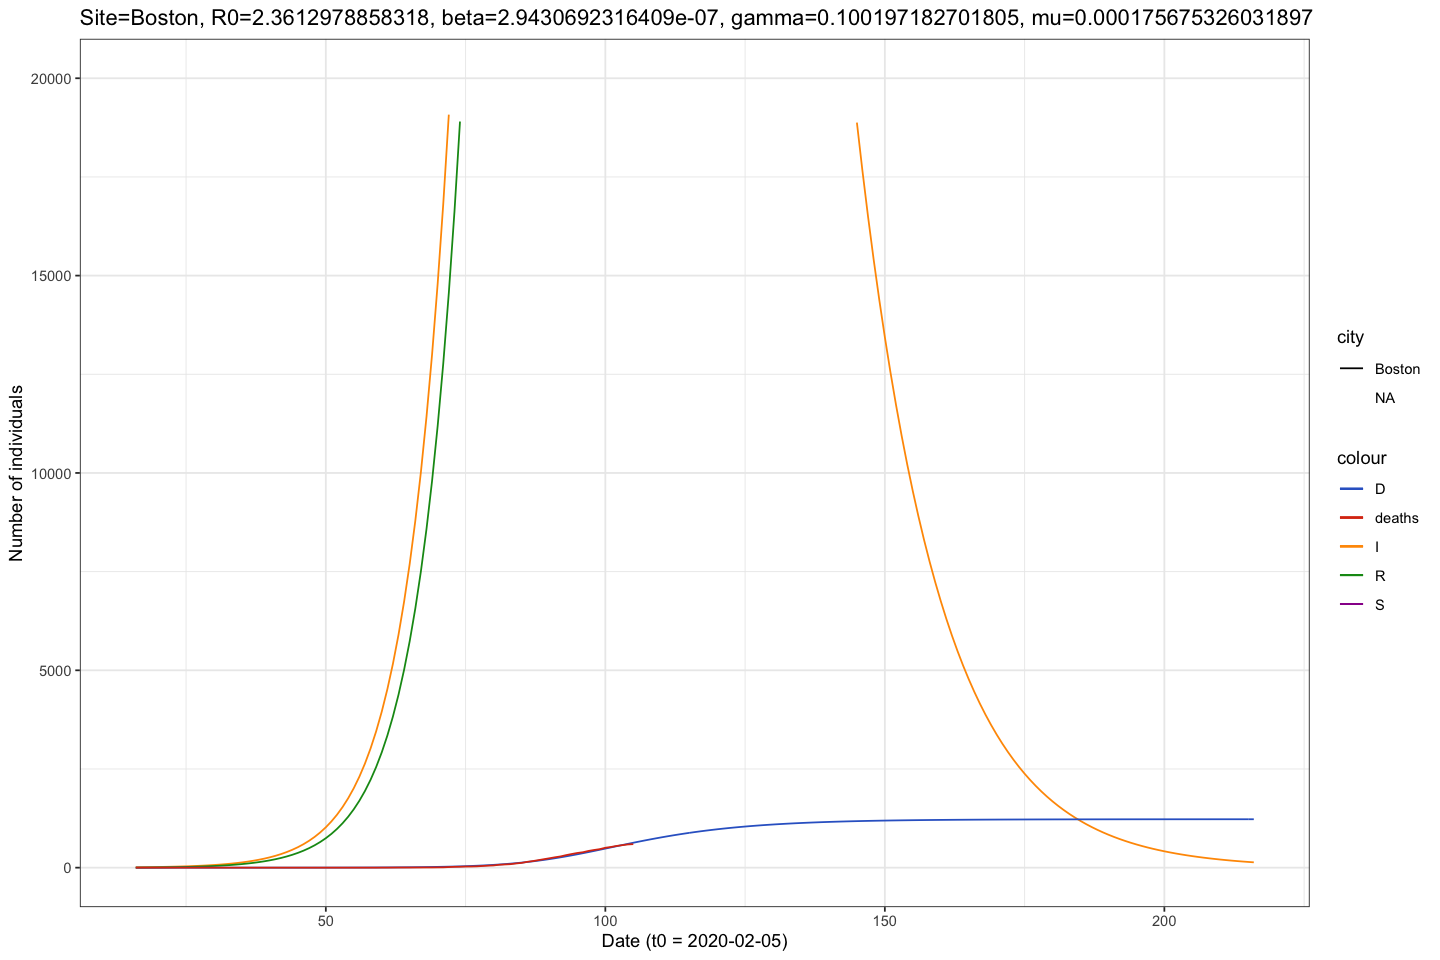

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 149 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 row(s) containing missing values (geom_path).”


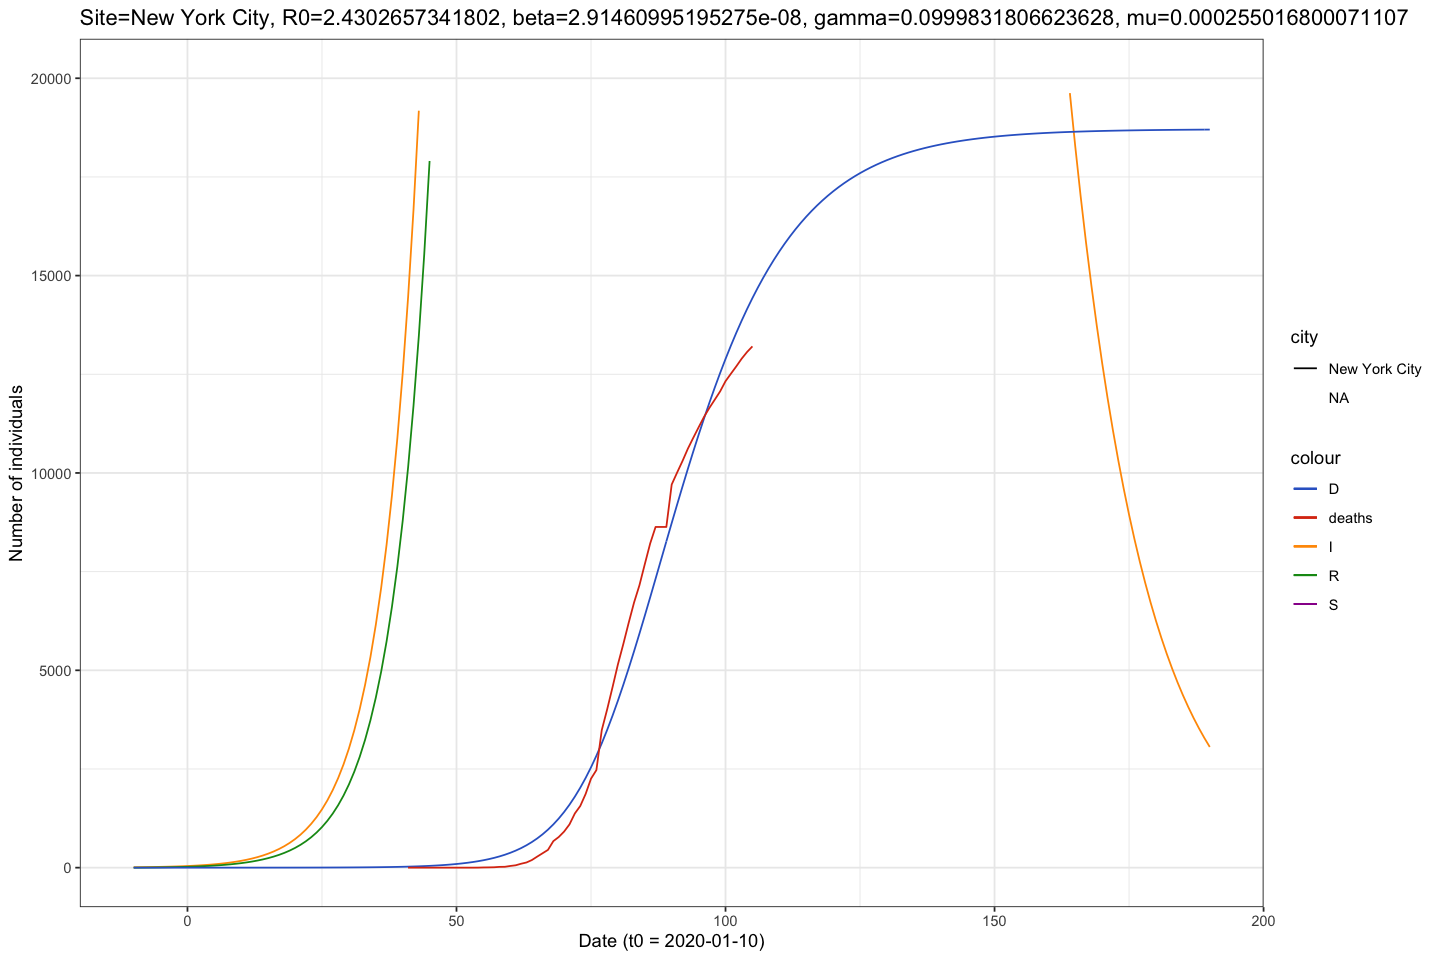

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 141 row(s) containing missing values (geom_path).”
Warning message:
“Removed 145 row(s) containing missing values (geom_path).”


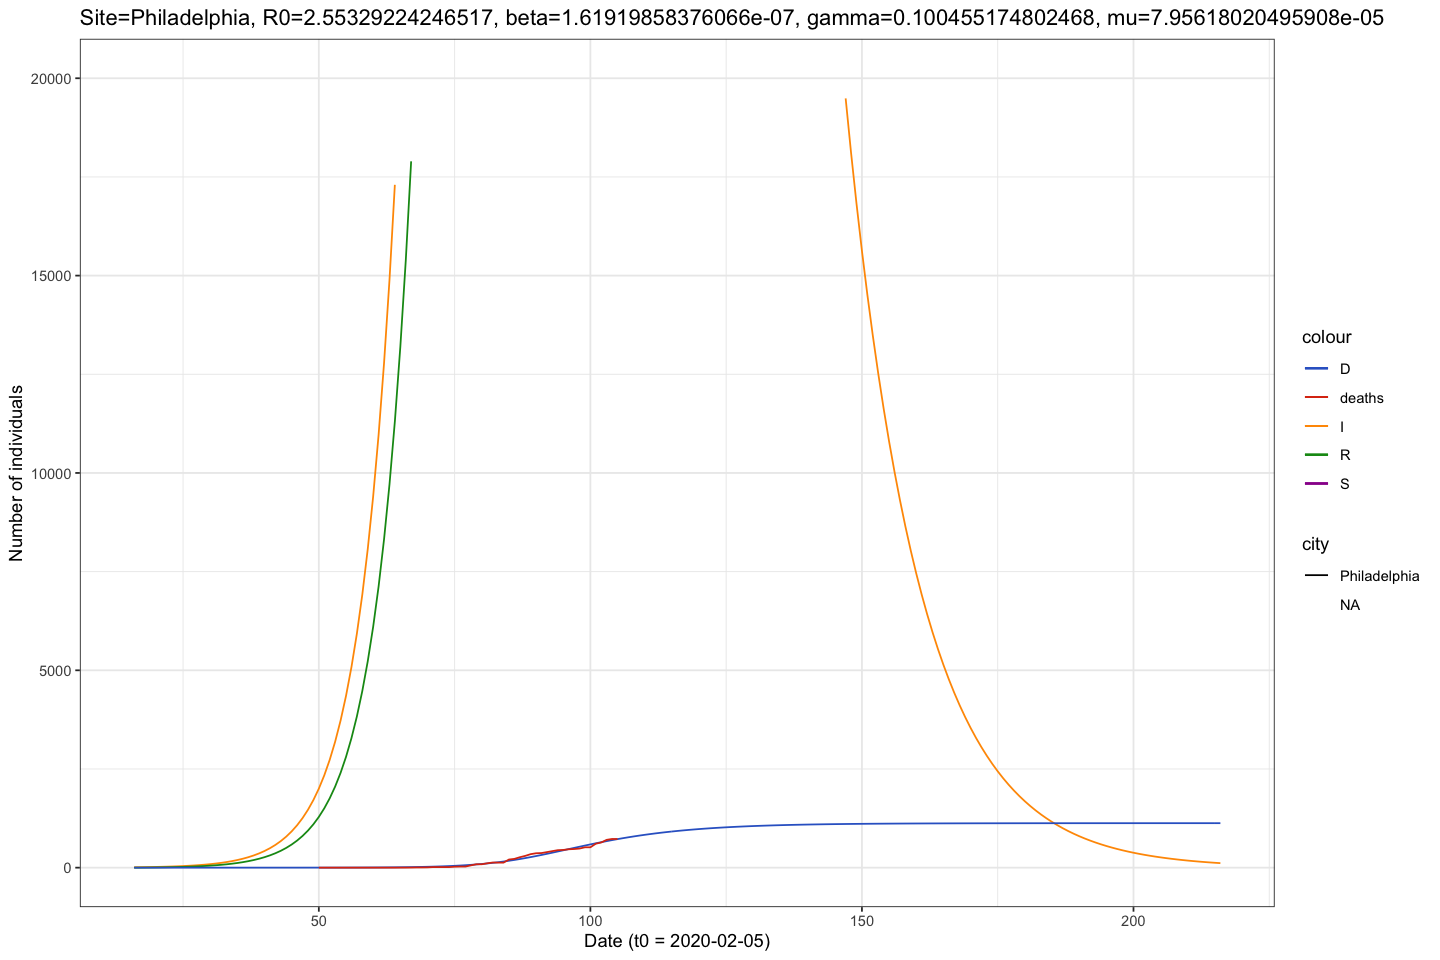

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 159 row(s) containing missing values (geom_path).”
Warning message:
“Removed 146 row(s) containing missing values (geom_path).”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”
Warning message in dpois(x 

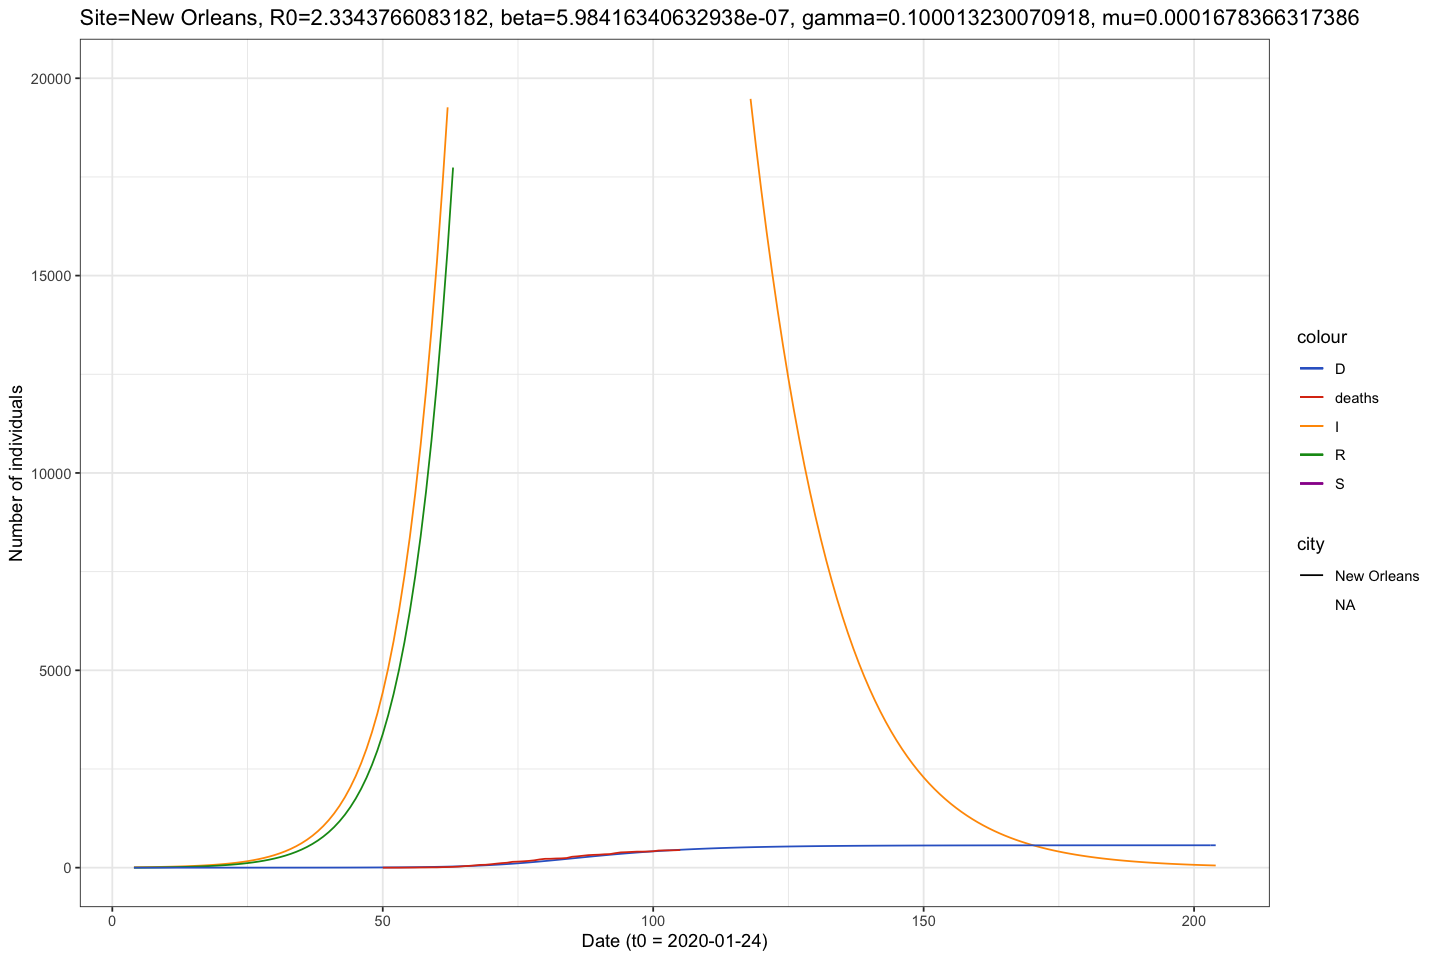

Warning message:
“Removed 201 row(s) containing missing values (geom_path).”
Warning message:
“Removed 152 row(s) containing missing values (geom_path).”
Warning message:
“Removed 105 row(s) containing missing values (geom_path).”


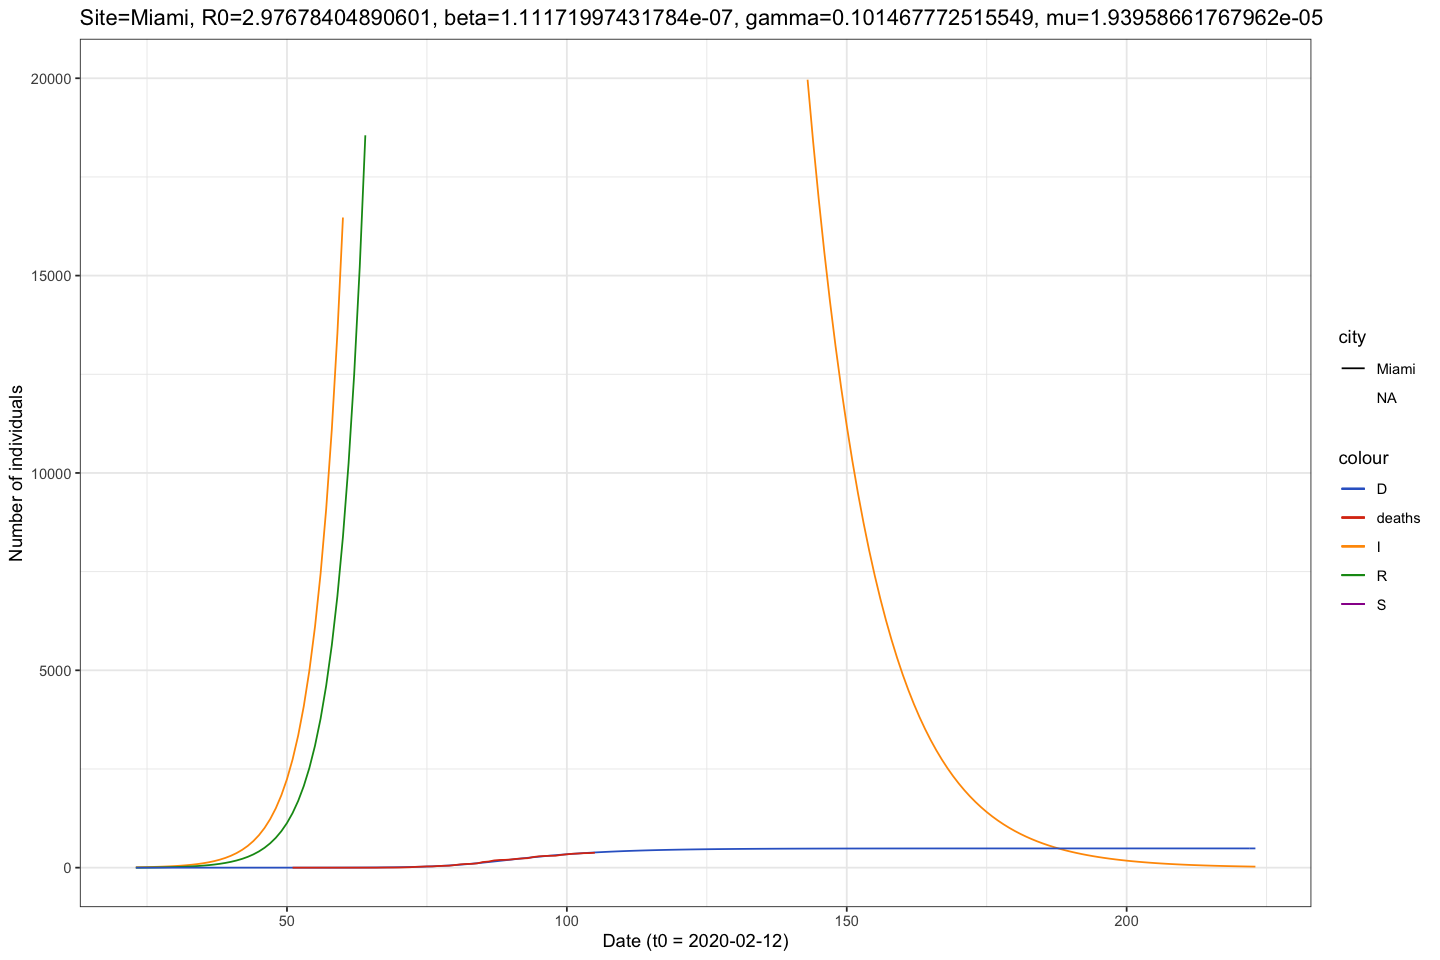

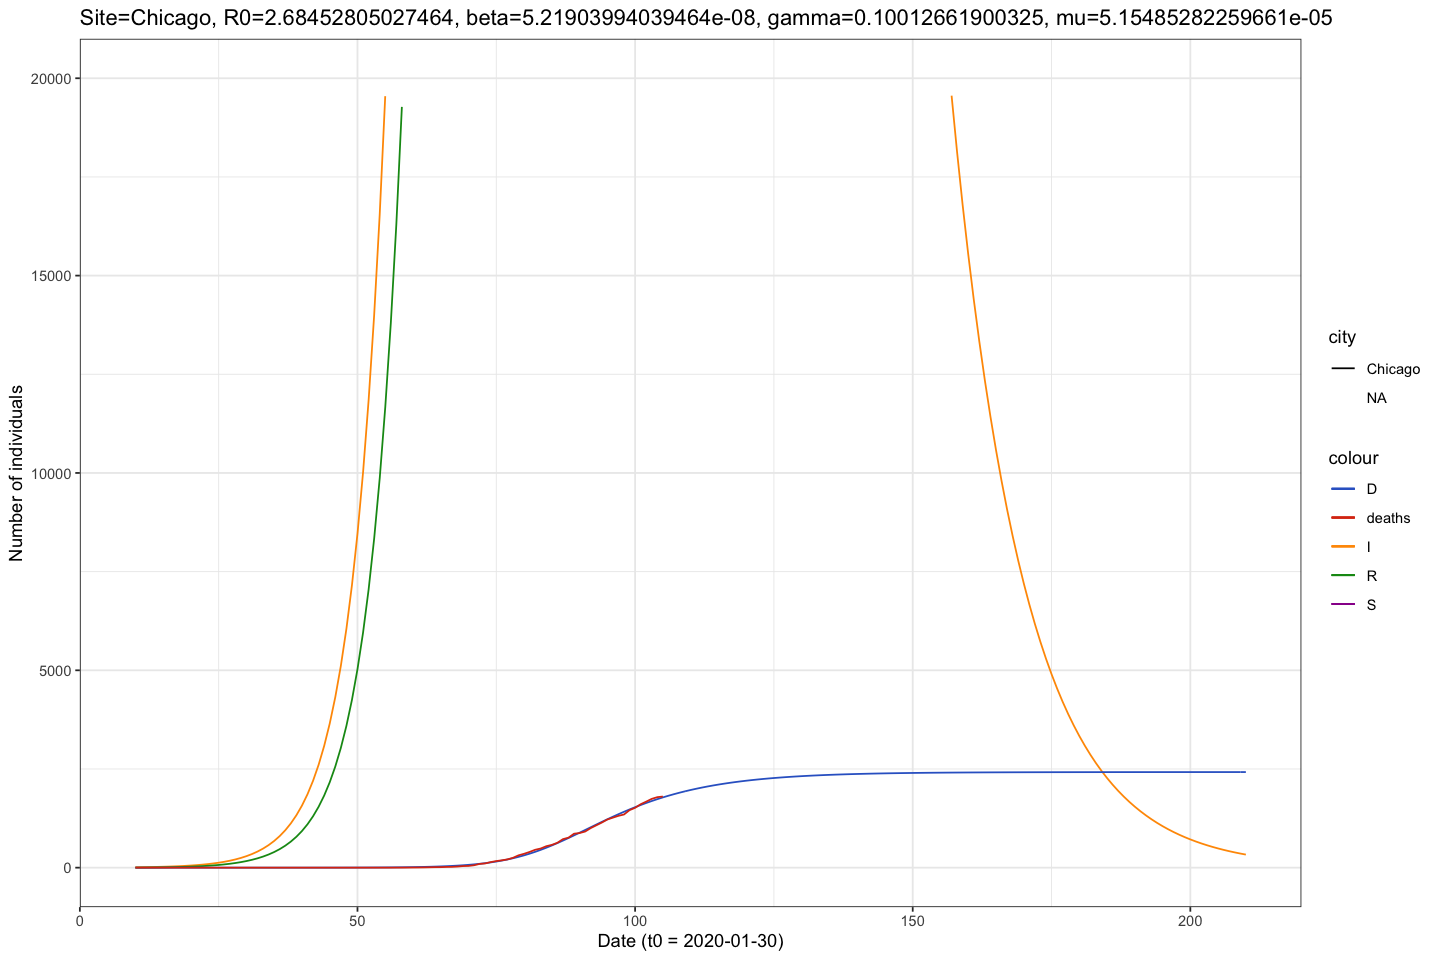

In [81]:
# run the optimization (recursively)

for (s in fips2.list) {
    city <- subset(usdat, fips2==s)[1, 'city']
    N <- pops[pops$fips2==s,]$pop

    R0 <- 2.5
    gamma0 <- 1e-1
    mu0 <- 1e-4
    beta0 <- R0*gamma0/N
    p.scale <- 1 # lambda scaling coefficient for Poisson distribution

    params = c(beta=beta0, gamma=gamma0, mu=mu0)

    fit6 <- optim(fn=f6, par=params, control=list(maxit=500))
    # fit6

    mle1 <- fit6$par

    # retrieve the optimum for t0
    beta.hat <- mle1[['beta']]
    gamma.hat <- mle1[['gamma']]
    mu.hat <- mle1[['mu']]

    f9 <- function(par.t_offset) {
        -poisson.loglik(dat = subset(usdat, fips2==s),
                   N = pops[pops$fips2==s,]$pop,
                   params = c(beta=beta.hat,
                              gamma=gamma.hat,
                              mu=mu.hat,
                              t_offset=par.t_offset,
                              p.scale=1))
    }

    fit9 <- optim(fn=f9,
                  par=t_offset0,
                  method='Brent',
                  lower=t_offset_min,
                  upper=t_offset_max)

    # fit9

    # simulation dataframe to model based on our input parameters

    beta.hat <- mle1[['beta']]
    gamma.hat <- mle1[['gamma']]
    mu.hat <- mle1[['mu']]
    R0.hat <- beta.hat*N/gamma.hat
    t_offset.hat <- floor(fit9$par)

    trajectory(
        model=m1,
        params=c(beta=beta.hat, gamma=gamma.hat, mu=mu.hat),
        times=times + t_offset.hat,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> pred

    #     join(pred, usdat, by='t') %>% print()

    # plot the simulated data compared to the observed data
    p <- ggplot(join(pred, subset(usdat, fips2==s), by='t'), aes(x=t))
    p <- p + theme_bw() + scale_color_gdocs()
    p <- p + geom_line(aes(y=S, col='S'))
    p <- p + geom_line(aes(y=I, col='I'))
    p <- p + geom_line(aes(y=R, col='R'))
    p <- p + geom_line(aes(y=D, col='D'))
    p <- p + geom_line(aes(y=deaths, col='deaths', linetype=city))
    p <- p + scale_y_continuous(limits=c(0,2e4))
    # p <- p + scale_y_continuous(trans='log10')
    p <- p + ggtitle(paste0('Site=', city, ', R0=', R0.hat, ', beta=', beta.hat, ', gamma=', gamma.hat, ', mu=', mu.hat))
    p <- p + xlab(paste0('Date (t0 = ', t0 + t_offset.hat, ')')) + ylab('Number of individuals')
    print(p)
}

## Fit 4: CEoptim - Estimating t0, beta, gamma, mu

In [83]:
# NOTE: CEoptim library overloads the `select` function from dplyr,
# so data loading steps will fail after this command
library('CEoptim')

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: msm

Loading required package: sna

Loading required package: statnet.common


Attaching package: ‘statnet.common’


The following object is masked from ‘package:base’:

    order


Loading required package: network

network: Classes for Relational Data
Version 1.16.0 created on 2019-11-30.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.



Attaching package: ‘network’


The following object is masked from ‘package:plyr’:

    is.discrete


sna: Tools for Soc

##### Functions

In [90]:
# optimization function
f8 <- function(par.cts, par.discrete, discrete.list) {
    -poisson.loglik(dat = subset(usdat, fips2==s),
               N = pops[pops$fips2==s,]$pop,
               params = c(beta=exp(par.cts[1]),
                          gamma=exp(par.cts[2]),
                          mu=exp(par.cts[3]),
                          t_offset=discrete.list[par.discrete+1],
                          p.scale=1))
}

##### Observed

In [92]:
# select cities
city.list <- c('Detroit', 'Boston', 'New York City', 'Philadelphia', 'New Orleans', 'Miami', 'Chicago')
fips2.list <- c('26163', '25025', 'nyc', '42101', '22071', '12086', '17031')

# join to nytimes data
cbind(city=city.list, fips2=fips2.list) %>%
as.data.frame() %>%
join(nyt, by='fips2') %>%
mutate(t=as.numeric(date - t0)) %>%
dplyr::select(t, date, fips2, city, county, state, cases, deaths) %>%
subset(t >=0 & t <= max_time) -> usdat

##### Variables

In [118]:
# Grid where to evaluate
max_time <- 150
resolution <- 1
times <- seq(0, max_time, by=resolution)

t_offset_min <- 0
t_offset_max <- 30
t_offset_list <- seq(t_offset_min, t_offset_max, 5)
d <- as.integer(c(length(t_offset_list)-1))

##### Optimization

Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 107 row(s) containing missing values (geom_path).”
Warning message:
“Removed 95 row(s) containing missing values (geom_path).”


[1] 0.001499576


Warning message:
“Removed 108 row(s) containing missing values (geom_path).”
Warning message:
“Removed 103 row(s) containing missing values (geom_path).”
Warning message:
“Removed 93 row(s) containing missing values (geom_path).”
Warning message:
“Removed 60 row(s) containing missing values (geom_path).”


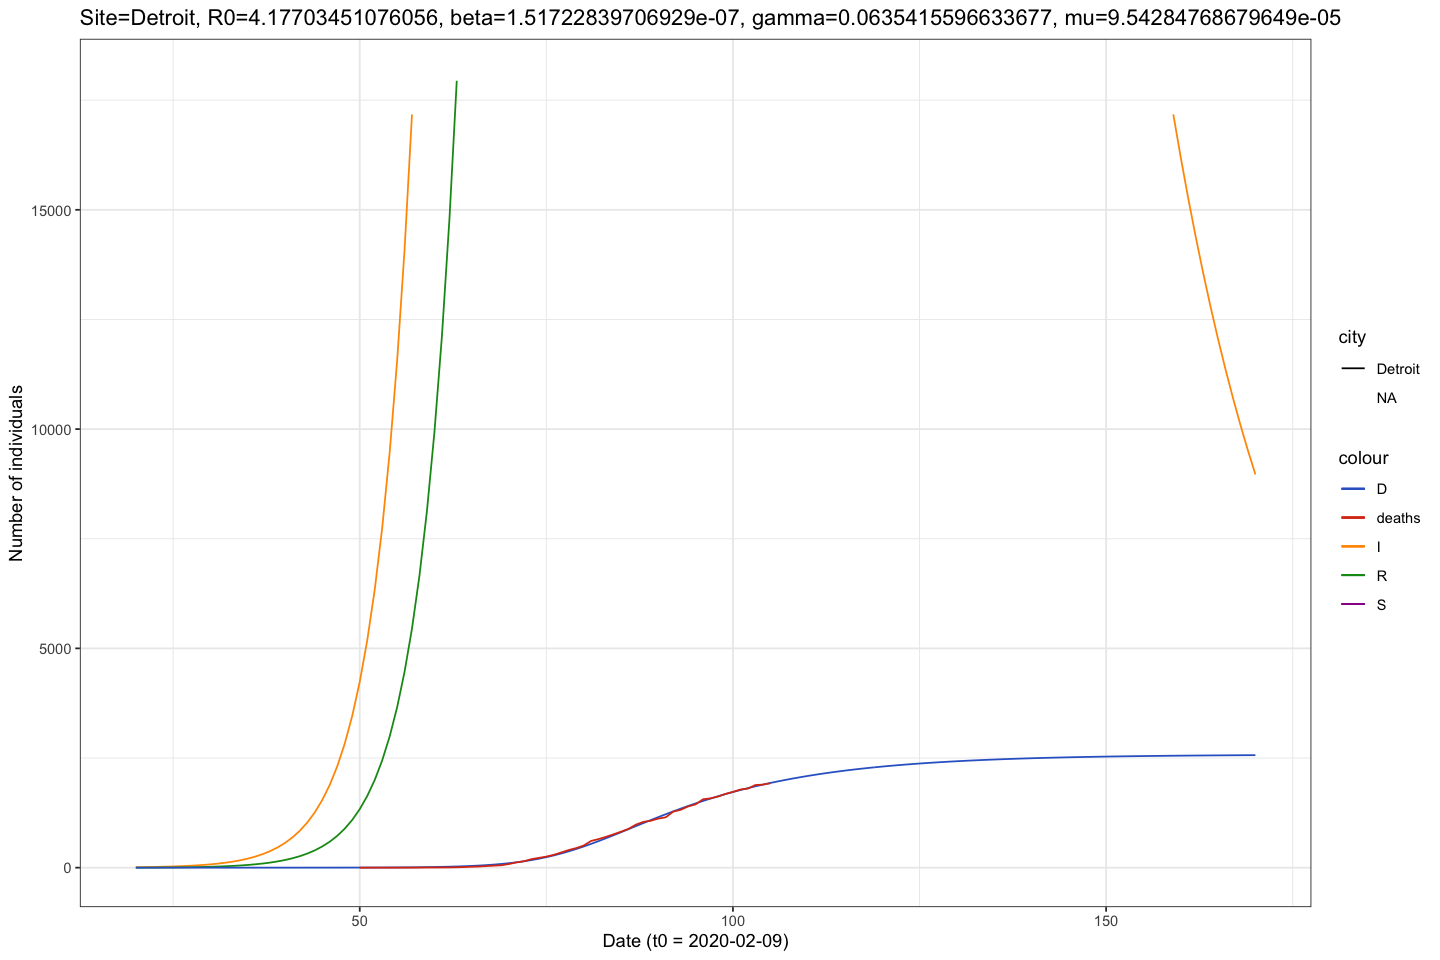

[1] 0.001720402


Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 116 row(s) containing missing values (geom_path).”
Warning message:
“Removed 111 row(s) containing missing values (geom_path).”
Warning message:
“Removed 86 row(s) containing missing values (geom_path).”


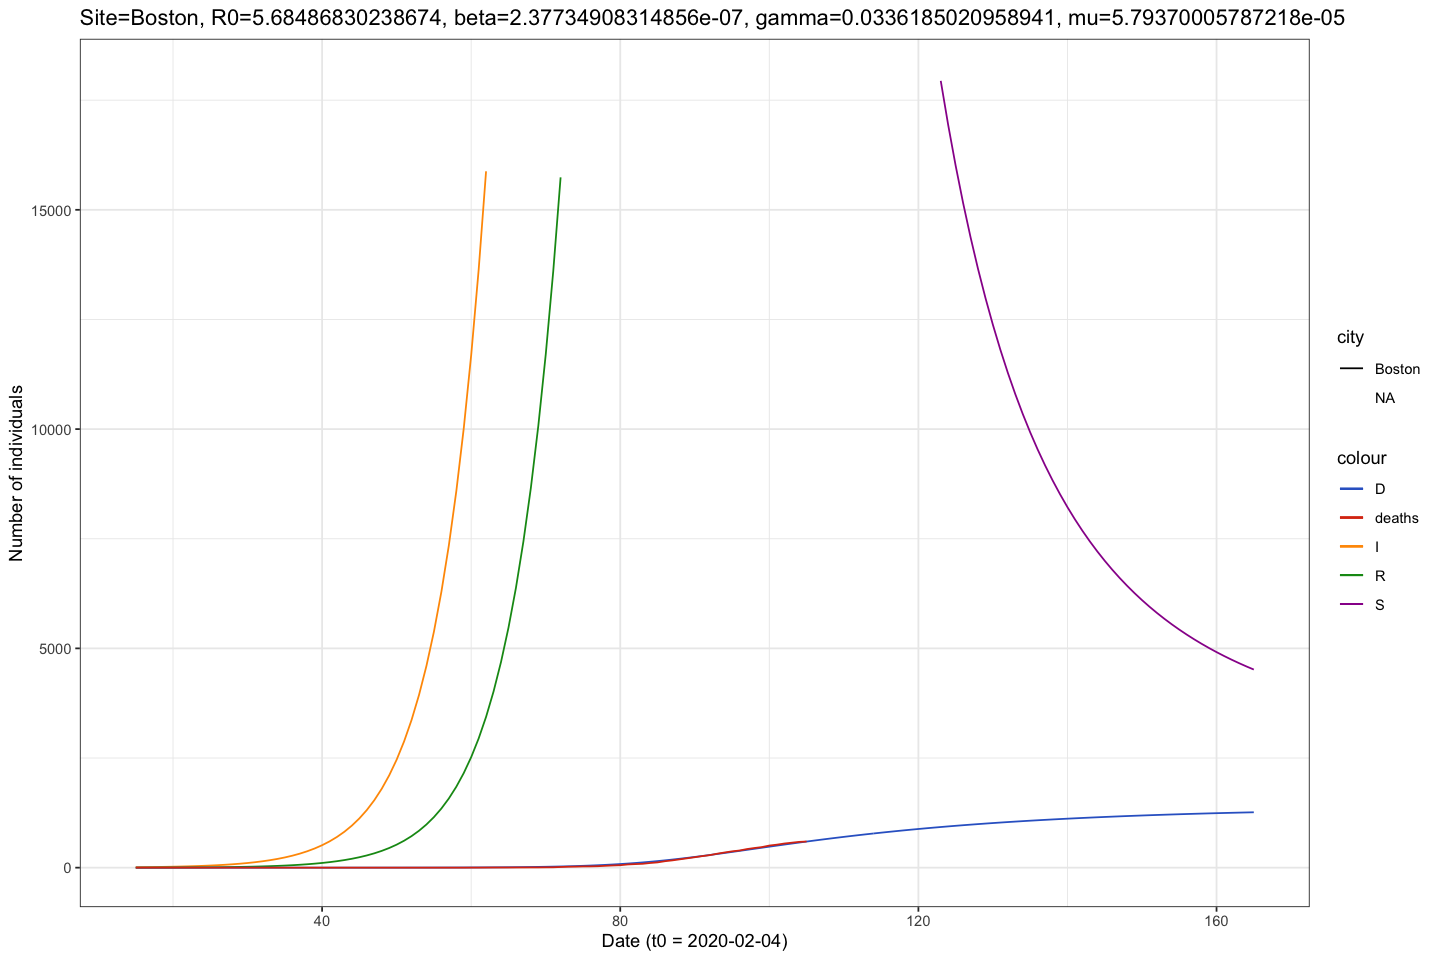

[1] 0.002052181


Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 98 row(s) containing missing values (geom_path).”
Warning message:
“Removed 93 row(s) containing missing values (geom_path).”
Warning message:
“Removed 95 row(s) containing missing values (geom_path).”


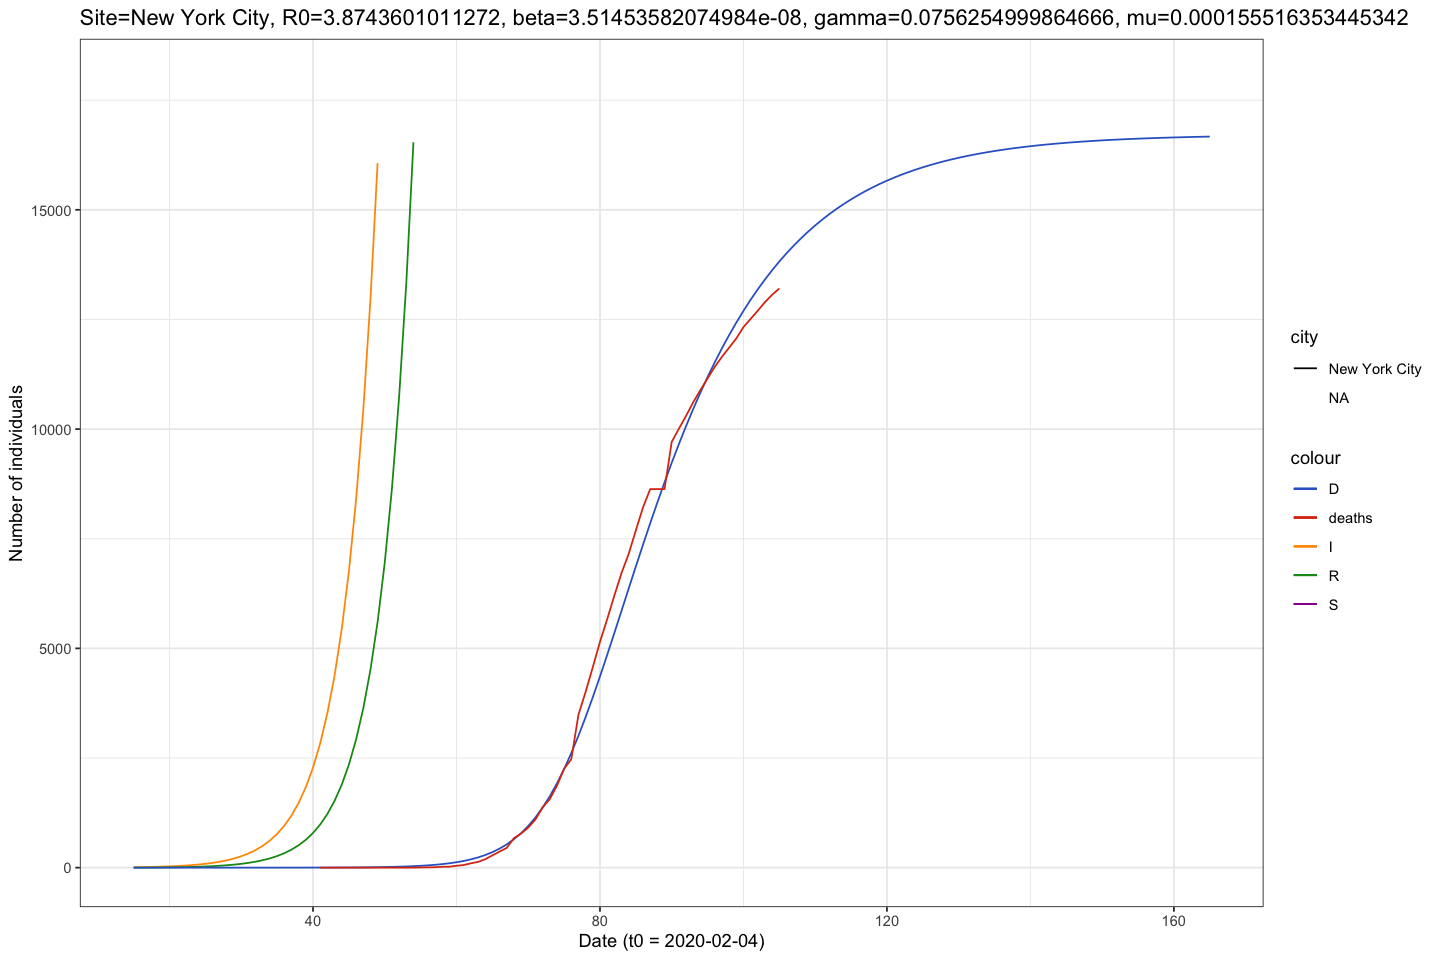

[1] 0.0009587642


Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 103 row(s) containing missing values (geom_path).”
Warning message:
“Removed 95 row(s) containing missing values (geom_path).”


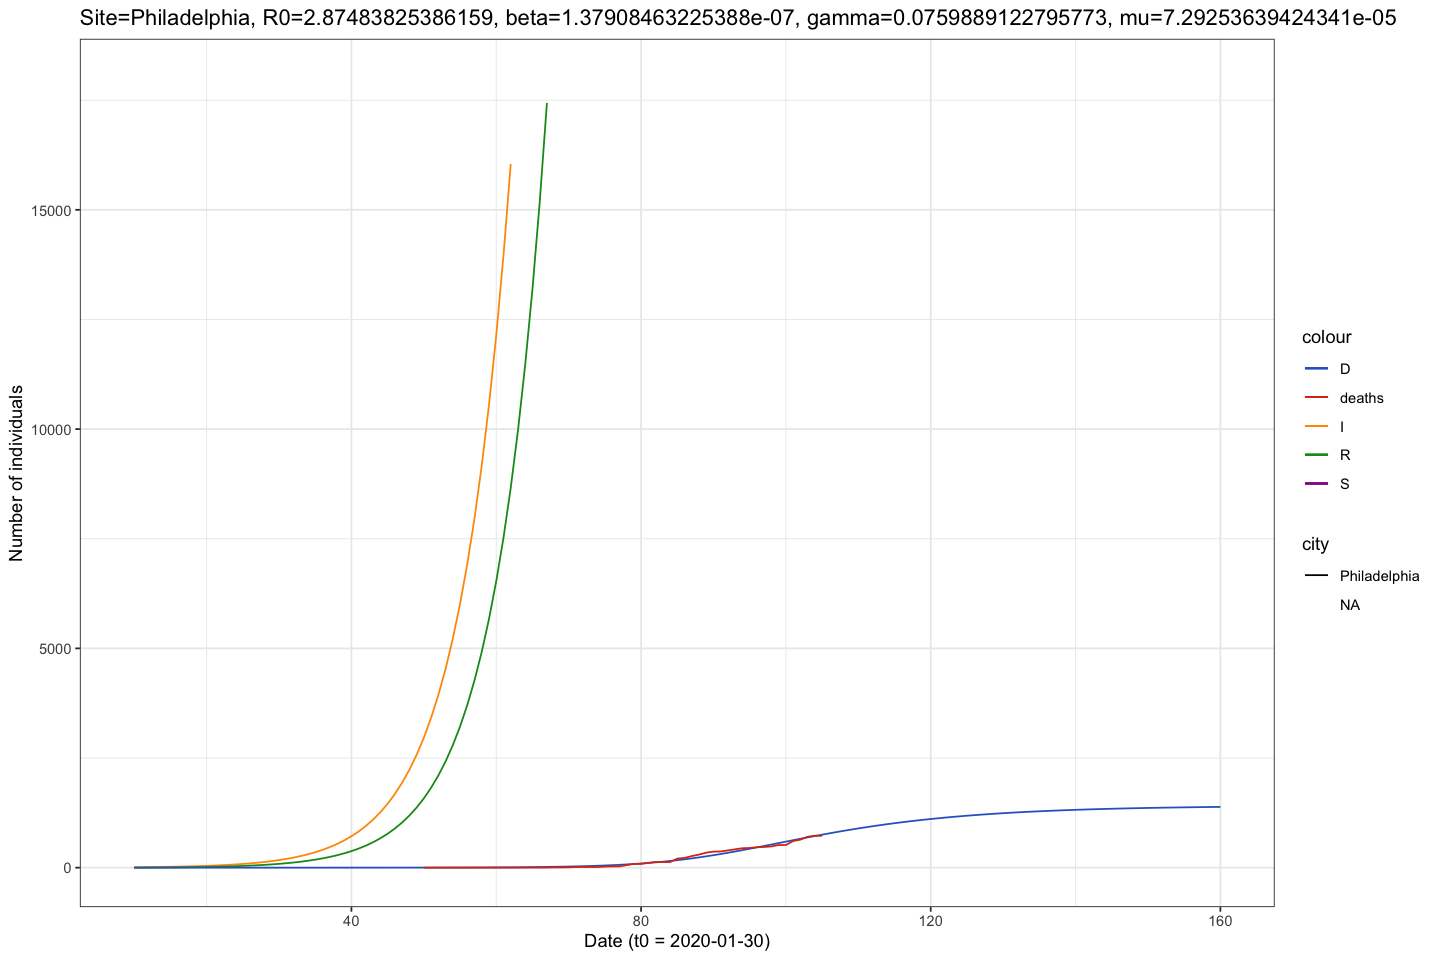

[1] 0.001424156


Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 68 row(s) containing missing values (geom_path).”
Warning message:
“Removed 54 row(s) containing missing values (geom_path).”
Warning message:
“Removed 31 row(s) containing missing values (geom_path).”
Warning message:
“Removed 96 row(s) containing missing values (geom_path).”


[1] 0.1234208


Warning message in dpois(x = dat$deaths, lambda = params[["p.scale"]] * s$D, log = TRUE):
“NaNs produced”


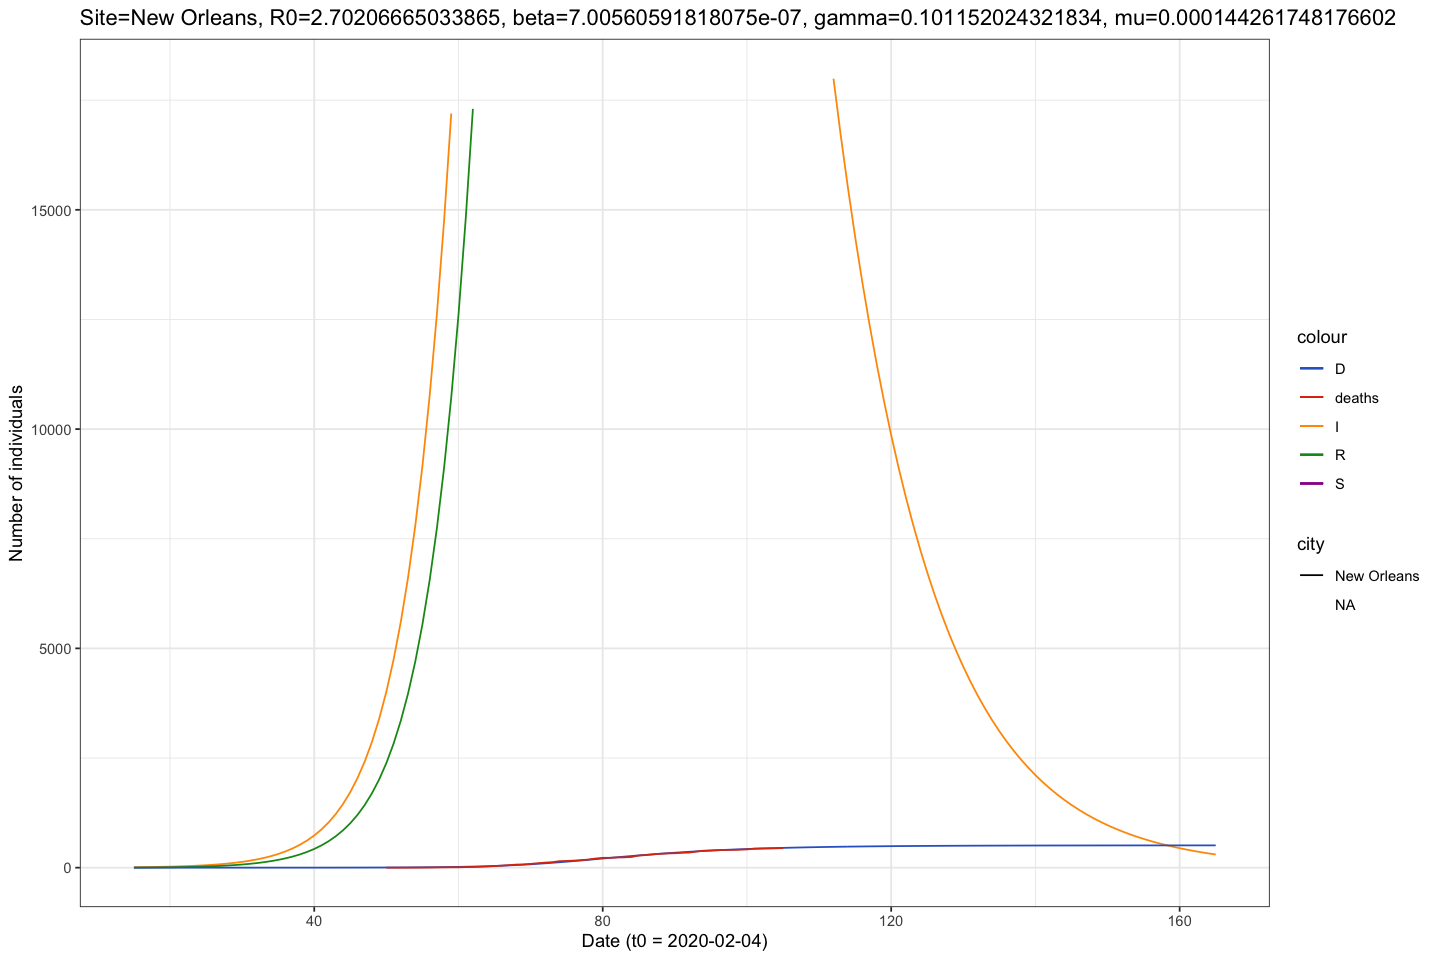

Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 103 row(s) containing missing values (geom_path).”
Warning message:
“Removed 55 row(s) containing missing values (geom_path).”


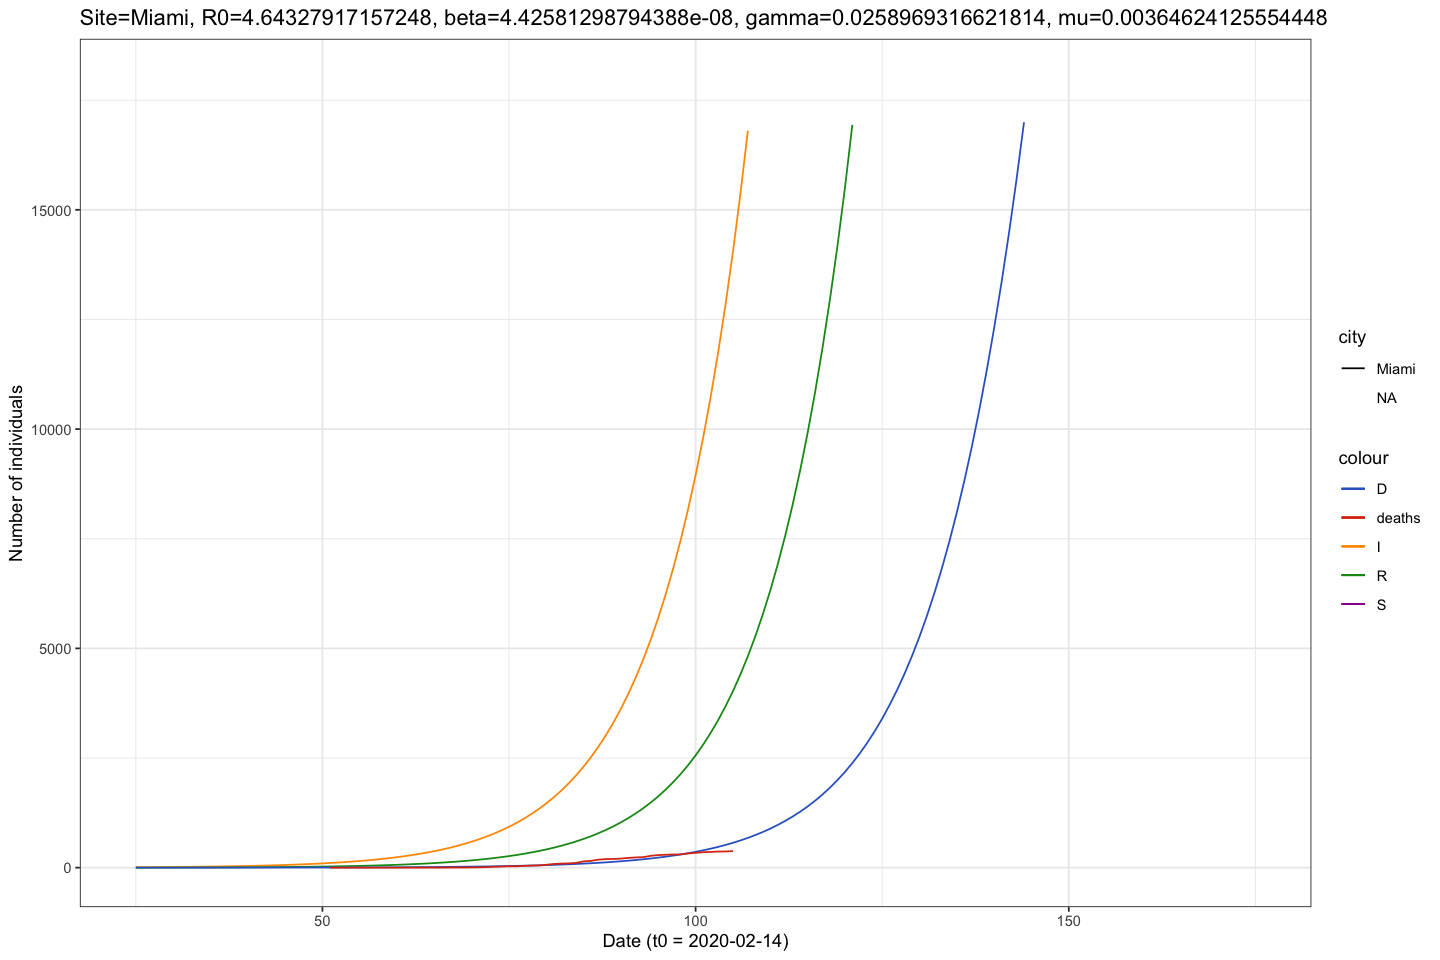

[1] 0.0005253245


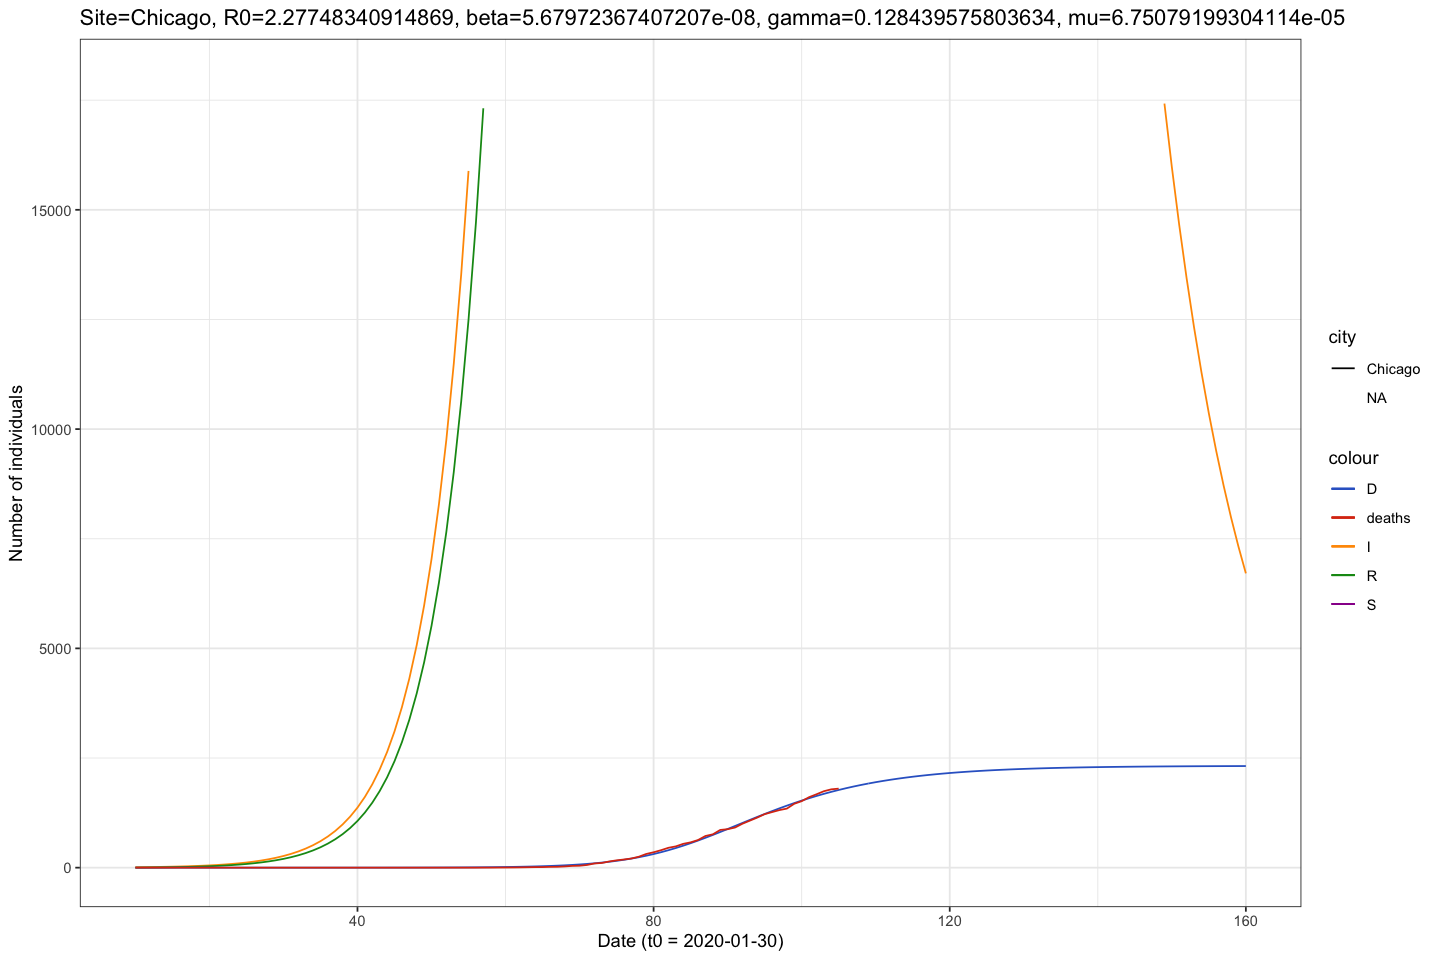

In [127]:
city.list <- c('Detroit', 'Boston', 'New York City', 'Philadelphia', 'New Orleans', 'Miami', 'Chicago')
fips2.list <- c('26163', '25025', 'nyc', '42101', '22071', '12086', '17031')

# s <- '25025' # boston
# s <- '42101' # philly
# s <- '17031' # chicago
# s <- 'nyc'
# s <- '22071'

for (s in fips2.list) {
    city <- subset(usdat, fips2==s)[1, 'city']
    N <- pops[pops$fips2==s,]$pop

    R0 <- 2.5
    gamma0 <- 1e-1
    mu0 <- 1e-3
    beta0 <- R0*gamma0/N

    # params
    mean0 <- c(log(beta0), log(gamma0), log(mu0))
    sigma0 <- c(1, 1, 1)

    fit8 <- CEoptim(f = f8,
                    f.arg = list(discrete.list=t_offset_list),
                    continuous = list(mean=mean0, sd=sigma0),
                    discrete = list(categories=d),
                    maximize = FALSE,
                    N=100L,
                    verbose=FALSE)

    # fit8

    mle1 <- c(exp(fit8$optimizer$continuous), t_offset_list[fit8$optimizer$discrete + 1])
    names(mle1) <- c('beta', 'gamma', 'mu', 't_offset')
    # mle1

    # simulation dataframe to model based on our input parameters
    beta.hat <- mle1[['beta']]
    gamma.hat <- mle1[['gamma']]
    mu.hat <- mle1[['mu']]
    R0.hat <- beta.hat*N/gamma.hat
    t_offset.hat <- mle1[['t_offset']]

    trajectory(
        model=m1,
        params=c(beta=beta.hat, gamma=gamma.hat, mu=mu.hat),
        times=times + t_offset.hat,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> pred

    # plot the simulated data compared to the observed data
    p <- ggplot(join(pred, subset(usdat, fips2==s), by='t'), aes(x=t))
    p <- p + theme_bw() + scale_color_gdocs()
    p <- p + geom_line(aes(y=S, col='S'))
    p <- p + geom_line(aes(y=I, col='I'))
    p <- p + geom_line(aes(y=R, col='R'))
    p <- p + geom_line(aes(y=D, col='D'))
    p <- p + geom_line(aes(y=deaths, col='deaths', linetype=city))
    # p <- p + geom_line(aes(y=cases, col='cases', linetype=city))
    p <- p + scale_y_continuous(limits=c(0,18e3))
    # p <- p + scale_y_continuous(trans='log10')
    p <- p + ggtitle(paste0('Site=', city, ', R0=', R0.hat, ', beta=', beta.hat, ', gamma=', gamma.hat, ', mu=', mu.hat))
    p <- p + xlab(paste0('Date (t0 = ', t0 + t_offset.hat, ')')) + ylab('Number of individuals')
    print(p)

    # get end of distribution, estimate mortality rate
    fin <- tail(pred, 1)
    # fin %>% print()
    (fin$D / (fin$R + fin$D)) %>% print()
}

## Fit 3: Global and local parameters

Here, we'll attempt to simultaneously estimate local and global parameters

##### Model

In [10]:
m1 <- function(t, y, params) {
    beta <- params['beta']
    gamma <- params['gamma']
    mu <- params['mu']
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [11]:
# Solve ODE system using Runge-Kutta numerical method.
trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Functions

In [12]:
# log likelihood function
poisson.loglik <- function (dat, N, params) {
    trajectory(
        model=m1,
        params=params,
        times=times + floor(params[["t_offset"]]),
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    s <- reconcile_sim(s, min(dat$t), max(dat$t))
    
#     tail(s) %>% print()
#     head(dat) %>% print()

#     subset(t >= min(dat$t) & t <= max(dat$t)) -> s
    
#     plot(dat$t, dat$deaths, type='o')
#     points(s$t, s$D, type='o', col='red')

#     plot(s$t, s$D, type='o', col='red')
    
#     dat %>% head() %>% print()
#     s %>% head() %>% print()
    
    dpois(x=dat$deaths,
      lambda=params[["p.scale"]]*s$D,
      log=TRUE) %>%
    sum()
}

In [13]:
# global loglik
global.loglik <- function(dat, pops, param.list) {
    r <- 0
    for (i in 1:length(levels(dat$fips2))) {
        myfips2 <- levels(dat$fips2)[i]
        myparams <- param.list[[myfips2]]
        names(myparams) <- row.names(param.list)
        
        # optimize t_offset
        myparams[['t_offset']] <- 0
#         myparams[['t_offset']] <- opt_t_offset(dat, N, myparams)
#         myparams %>% print()
        
#         poisson.loglik(subset(dat, fips2==myfips2), pops[pops$fips2==myfips2,]$pop, params=trans(myparams)) %>% print()
        
        r <- r + poisson.loglik(subset(dat, fips2==myfips2), pops[pops$fips2==myfips2,]$pop, params=myparams)
    }
    return(r)
}

In [14]:
# extend the simulated data to match length of observed data
reconcile_sim <- function(sim, obs_start_t, obs_end_t) {
    # trim sim to not extend beyond obs
    sim <- subset(sim, t >= obs_start_t & t <= obs_end_t)
    
    # extend sim to span entirety of obs
    sim_start_t <- sim[1,'t']
    sim_start_deaths <- sim[1,'D']
    sim_end_t <- tail(sim, 1)$t
    sim_end_deaths <- tail(sim, 1)$D
    
    append_start <- NULL
    append_end <- NULL
    
    if (sim_start_t > obs_start_t)
        append_start <- data.frame(t=obs_start_t:(sim_start_t-1), D=sim_start_deaths)
    if (sim_end_t < obs_end_t)
        append_end <- data.frame(t=(sim_end_t+1):obs_end_t, D=sim_end_deaths)
    
    return(rbind.fill(append_start, sim, append_end))
    
}

# reconcile_sim(pred, 10, 200) -> a
# a %>% head()
# a %>% tail()

In [15]:
# test global loglik
dat <- usdat
factors <- levels(usdat$fips2)
nfactors <- length(factors)

trans.par.local <- c(beta=log(beta))
trans.par.global <- c(gamma=log(gamma), mu=log(mu))
trans.par.fixed <- c(p.scale=p.scale)

par.local <- c(exp(trans.par.local['beta']))
par.global <- c(exp(trans.par.global['gamma']), exp(trans.par.global['mu']))
par.fixed <- trans.par.fixed


trans.params <- c(rep(trans.par.local, nfactors), trans.par.global)
params <- c(rep(par.local, nfactors), par.global)


param.list <- map.params(params, par.local, par.global, par.fixed, factors)

global.loglik(dat, pops, param.list)

ERROR: Error in log(beta): non-numeric argument to mathematical function


In [16]:
# transform and back-transform parameters

# beta, t_offset, gamma, mu, p.scale
trans <- function(x) {
    x[['beta']] <- exp(x[['beta']])
    x[['gamma']] <- exp(x[['gamma']])
    x[['mu']] <- exp(x[['mu']])
#     c(exp(x[1]), x[2], exp(x[3]), exp(x[4]), x[5])
    
    return(x)
}

back.trans <- function(x) {
    
}

In [17]:
# function to map a vector of parameters (some local, some global) amongst each site
# this allows some factors to be optimized globally (e.g. mu, gamma), while
# others are optimized locally (beta, t0)

map.params <- function(params, par.local, par.global, par.fixed, factors) {
    nfactors <- length(factors)

    # local params
    params[1:(nfactors*length(par.local))] %>%
    matrix(ncol=nfactors) %>%
    as.data.frame() %>%
    set_names(factors) -> a

    # global params
    params[-(1:(nfactors*length(par.local)))] %>%
    rep(nfactors) %>%
    matrix(ncol=nfactors) %>%
    as.data.frame() %>%
    set_names(factors) -> b

    # fixed params
    par.fixed %>%
    rep(nfactors) %>%
    matrix(ncol=nfactors) %>%
    as.data.frame() %>%
    set_names(factors) -> c

    param.list <- rbind(a, b, c)
    row.names(param.list) <- c(names(par.local), names(par.global), names(par.fixed))

    return(param.list)
}

In [18]:
# map the optimized output back to a dataframe with rows (sites) and columns (variables)
map.opt <- function(params, par.local, par.global, par.fixed, factors) {
    nfactors <- length(factors)
    local <- matrix(unname(params[1:(nfactors*length(par.local))]), nrow=nfactors, byrow=TRUE)
    global <- matrix(rep(params[-(1:(nfactors*length(par.local)))], nfactors), nrow=nfactors, byrow=TRUE)
    fixed <- matrix(rep(par.fixed, nfactors), nrow=nfactors, byrow=TRUE)

    as.data.frame(cbind(local, global, fixed)) %>%
    cbind(factors) -> a
    colnames(a) <- c(names(par.local), names(par.global), names(par.fixed), 'fips2')

    return(a)
}

In [19]:
# params <- c(beta=3e-08, gamma=0.1, mu=1e-04, t_offset=0, p.scale=1)

subst.params <- function(params, sub.names, sub.values) {
    names(sub.values) <- sub.names
    for (x in names(sub.values)) {
        params[[x]] <- sub.values[[x]]
    }
    return(params)
}

# subst.params(params, c('t_offset', 'gamma'), c(10, 0.2))

In [20]:
opt_t_offset <- function(dat, N, params) {
    fit <- optim(fn=function(par) -poisson.loglik(dat, N, params, 't_offset', par),
                 par=0,
                 method='Brent',
                 lower=-50,
                 upper=50)
    return(fit$par)
}

##### Variables

In [21]:
# Grid where to evaluate
max_time <- 150
resolution <- 1
times <- seq(0, max_time, by=resolution)

In [22]:
# Parameter initial values
N <- 1e7
R0 <- 3
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/10
mu <- 1e-4
# Infectious contact rate: beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta = R0/N*gamma

t0 <- as.Date('2020-01-20')
I0 <- 10

p.scale <- 1 # lambda scaling coefficient for Poisson distribution

# par.local <- c(beta=log(beta), t_offset=0)
# # par.local <- c(beta=beta)
# par.global <- c(gamma=log(gamma), mu=log(mu))
# par.fixed <- c(p.scale=p.scale)

trans.par.local <- c(beta=log(beta))
# trans.par.local <- c(beta=log(beta), t_offset=0)
# par.local <- c(beta=beta)
trans.par.global <- c(gamma=log(gamma), mu=log(mu))
trans.par.fixed <- c(p.scale=p.scale)

##### Observed

In [23]:
# select cities
# city.list <- c('Detroit', 'Boston', 'New York City', 'Philadelphia', 'New Orleans', 'Miami', 'Chicago')
# fips2.list <- c('26163', '25025', 'nyc', '42101', '22071', '12086', '17031')

city.list <- c('Boston', 'New York City', 'Chicago', 'Philadelphia')
fips2.list <- c('25025', 'nyc', '17031', '42101')

# city.list <- c('Boston', 'New York City')
# fips2.list <- c('25025', 'nyc')

# join to nytimes data
cbind(city=city.list, fips2=fips2.list) %>%
as.data.frame() %>%
join(nyt, by='fips2') %>%
mutate(t=as.numeric(date - t0)) %>%
select(t, date, fips2, city, county, state, cases, deaths) %>%
subset(t >=0 & t <= max_time) -> usdat

##### Optimization

In [24]:
f6 <- function (par) {
    # back transform variables
    par.local <- c(exp(trans.par.local['beta']))
    par.global <- c(exp(trans.par.global['gamma']), exp(trans.par.global['mu']))
    par.fixed <- trans.par.fixed
    
#     param.list <- map.opt(par, par.local, par.global, par.fixed, factors)
#     param.list %>% print()
    
#     bt.params <- c(rep(par.local, nfactors), par.global)
    
    bt.params <- exp(par)
#     map.params(bt.params, par.local, par.global, par.fixed, factors) %>% print()
    
    -global.loglik(usdat, pops, map.params(bt.params, par.local, par.global, par.fixed, factors))

}

In [25]:
# run it
factors <- levels(usdat$fips2)
nfactors <- length(factors)

# par.local.scale <- c(1,1)
# par.global.scale <- c(1,1)

# par.local.deps <- c(1e-3, 10)
# par.global.deps <- c(1e-3, 1e-3)

trans.params <- c(rep(trans.par.local, nfactors), trans.par.global)
# param.scale <- c(rep(par.local.scale, nfactors), par.global.scale)
# param.deps <- c(rep(par.local.deps, nfactors), par.global.deps)

fit6 <- optim(fn=f6, par=trans.params)

# fit6 <- optim(fn=f6, par=trans.params, method='SANN',
#               control=list(maxit=100, parscale=param.scale, temp=100, tmax=100))

In [26]:
fit6

par.local <- c(exp(trans.par.local['beta']))
par.global <- c(exp(trans.par.global['gamma']), exp(trans.par.global['mu']))
par.fixed <- trans.par.fixed

param.list <- map.params(exp(fit6$par), par.local, par.global, par.fixed, factors)
param.list

for (i in 1:length(levels(usdat$fips2))) {
    myfips2 <- levels(usdat$fips2)[i]
    myparams <- param.list[[myfips2]]
    names(myparams) <- row.names(param.list)

    # optimize t_offset
    myparams[['t_offset']] <- opt_t_offset(dat, N, myparams)
    
    print(myparams)

#         poisson.loglik(subset(dat, fips2==myfips2), pops[pops$fips2==myfips2,]$pop, params=trans(myparams)) %>% print()
}

$par
      beta       beta       beta       beta      gamma         mu 
-17.261115 -15.407105 -16.170554 -17.423299  -2.834564  -8.592947 

$value
[1] 26570.06

$counts
function gradient 
     501       NA 

$convergence
[1] 1

$message
NULL

17031        25025        42101        nyc         
beta    3.188547e-08 2.036007e-07 9.488942e-08 2.711173e-08
gamma   5.874416e-02 5.874416e-02 5.874416e-02 5.874416e-02
mu      1.854089e-04 1.854089e-04 1.854089e-04 1.854089e-04
p.scale 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00

ERROR: Error in poisson.loglik(dat, N, params, "t_offset", par): unused arguments ("t_offset", par)


In [661]:
# get MLE

map.opt(fit6$par, trans.par.local, trans.par.global, trans.par.fixed, levels(usdat$fips2)) %>%
join(select(pops, c('fips2', 'pop')), by='fips2') %>%
rename(N=pop) %>%
# mutate(R0=exp(beta)*N/exp(gamma), t_offset=round(t_offset,0)) -> mle1
mutate(R0=beta*N/gamma) -> mle1

# mle1$t_offset <- c(12, -38)

mle1

beta      gamma     mu        p.scale fips2 N       R0      
1 -17.16523 -2.885726 -8.970172 1       17031 5150233 30635244
2 -15.38643 -2.885726 -8.970172 1       25025  803907  4286361
3 -16.06330 -2.885726 -8.970172 1       42101 1584064  8817644
4 -17.38493 -2.885726 -8.970172 1       nyc   8336817 50224794

##### Trajectory with optimized beta

Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 76 row(s) containing missing values (geom_path).”
Warning message:
“Removed 70 row(s) containing missing values (geom_path).”
Warning message:
“Removed 51 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 51 row(s) containing missing values (geom_path).”


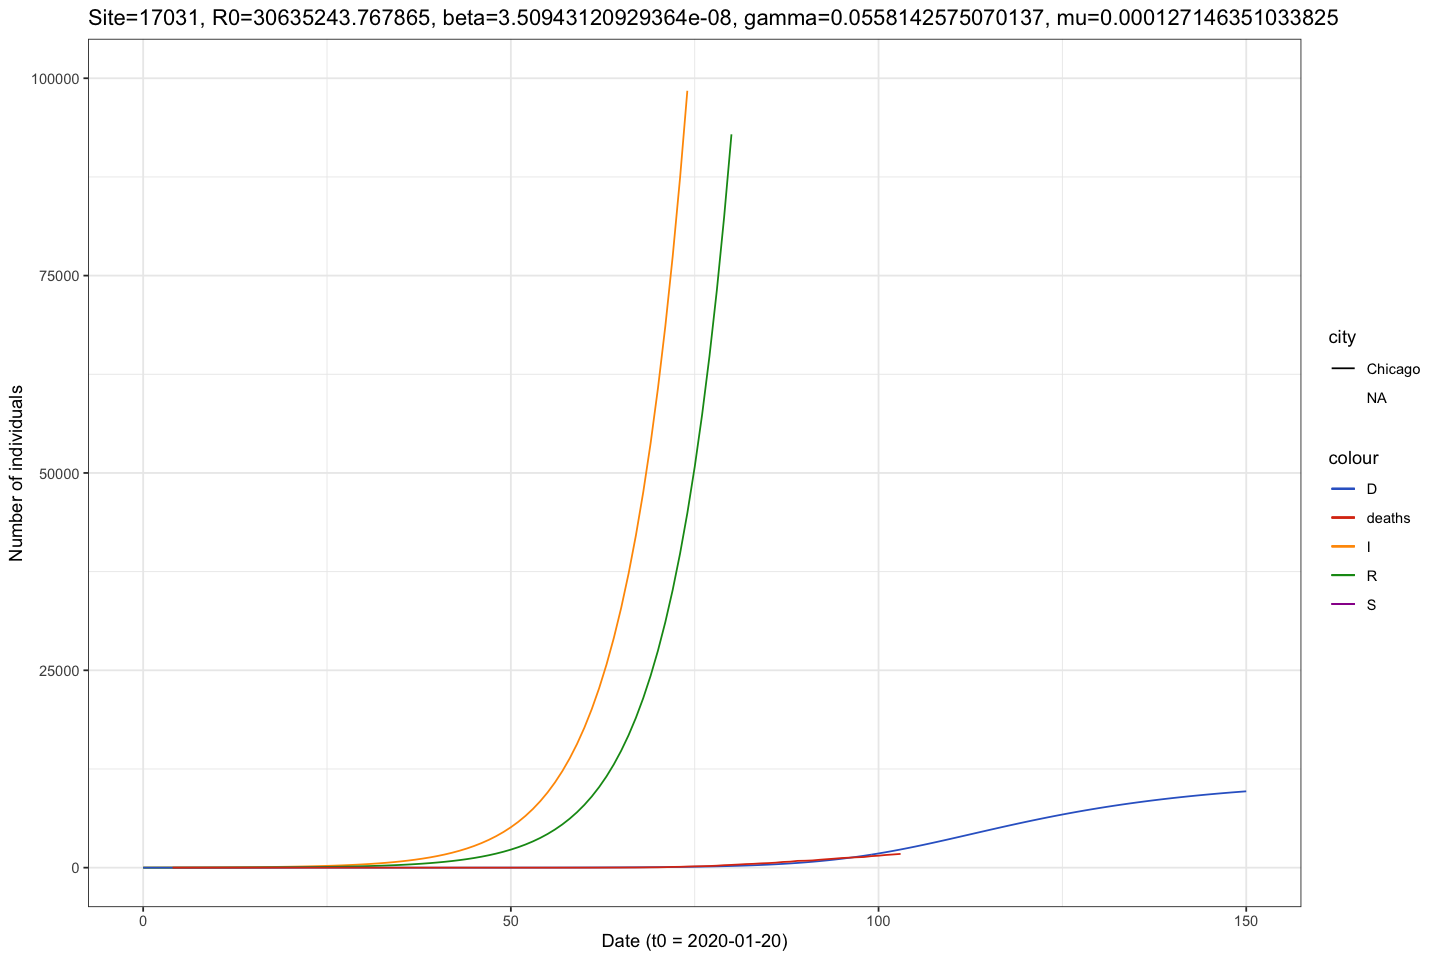

Warning message:
“Removed 133 row(s) containing missing values (geom_path).”
Warning message:
“Removed 59 row(s) containing missing values (geom_path).”
Warning message:
“Removed 59 row(s) containing missing values (geom_path).”


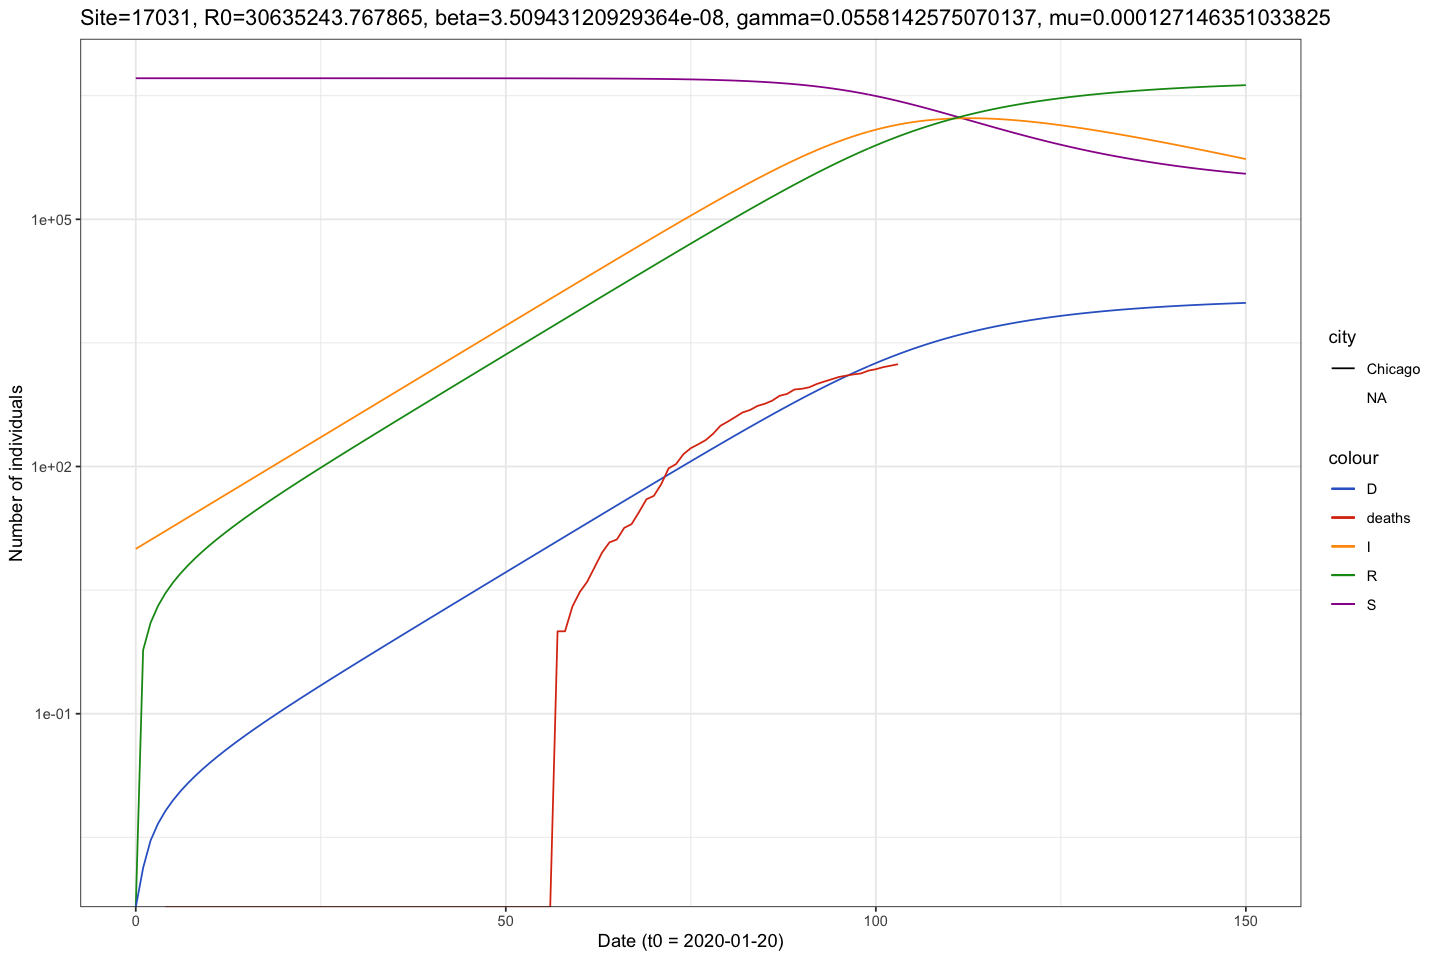

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 59 row(s) containing missing values (geom_path).”


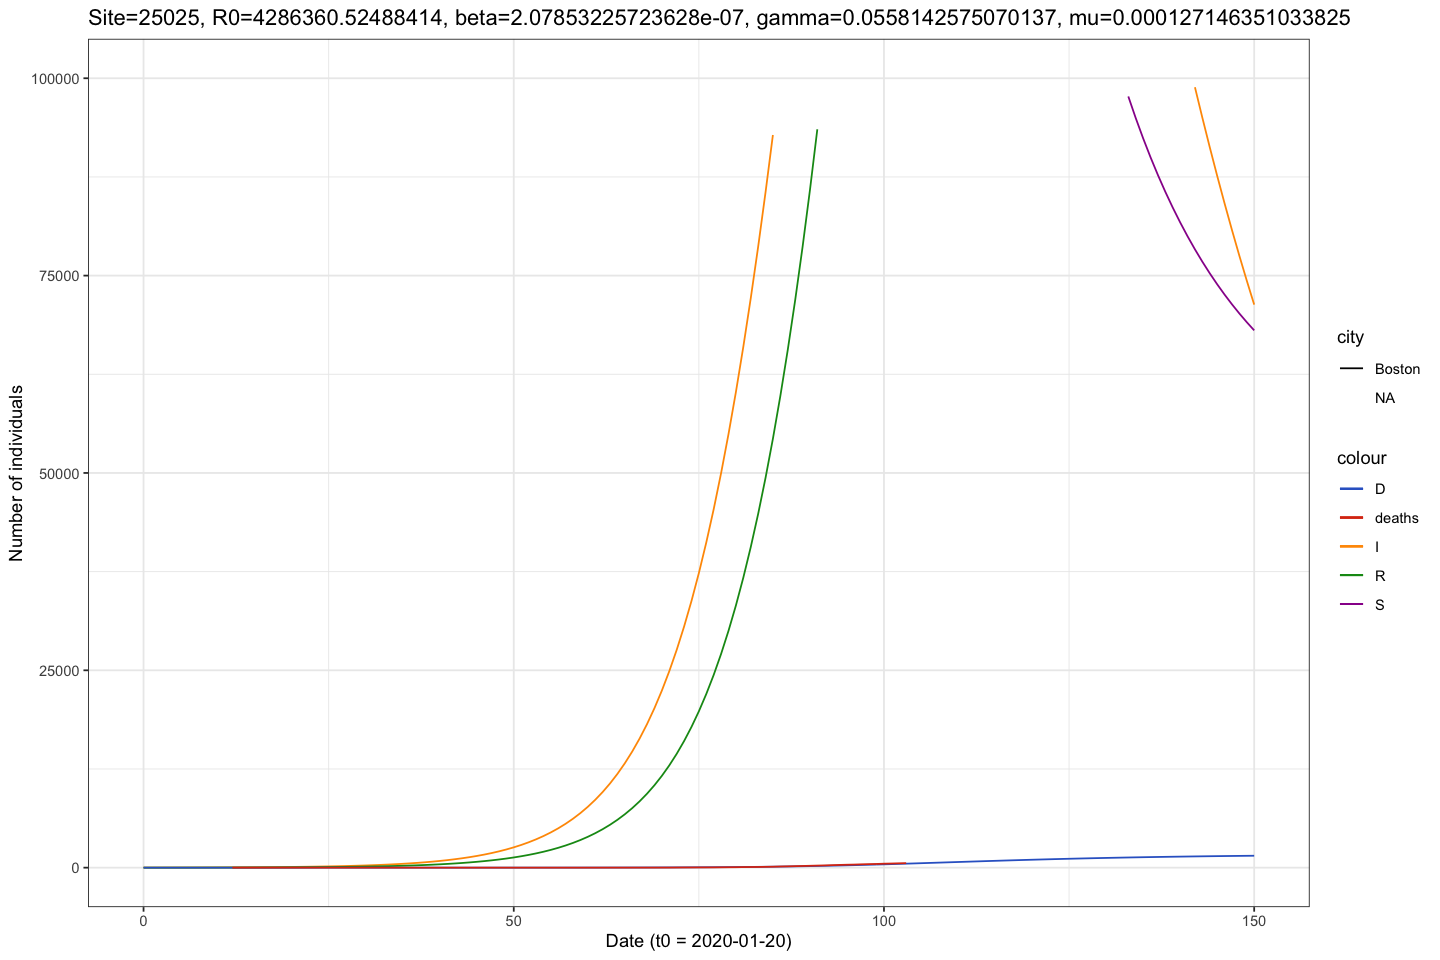

Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 66 row(s) containing missing values (geom_path).”
Warning message:
“Removed 60 row(s) containing missing values (geom_path).”
Warning message:
“Removed 97 row(s) containing missing values (geom_path).”


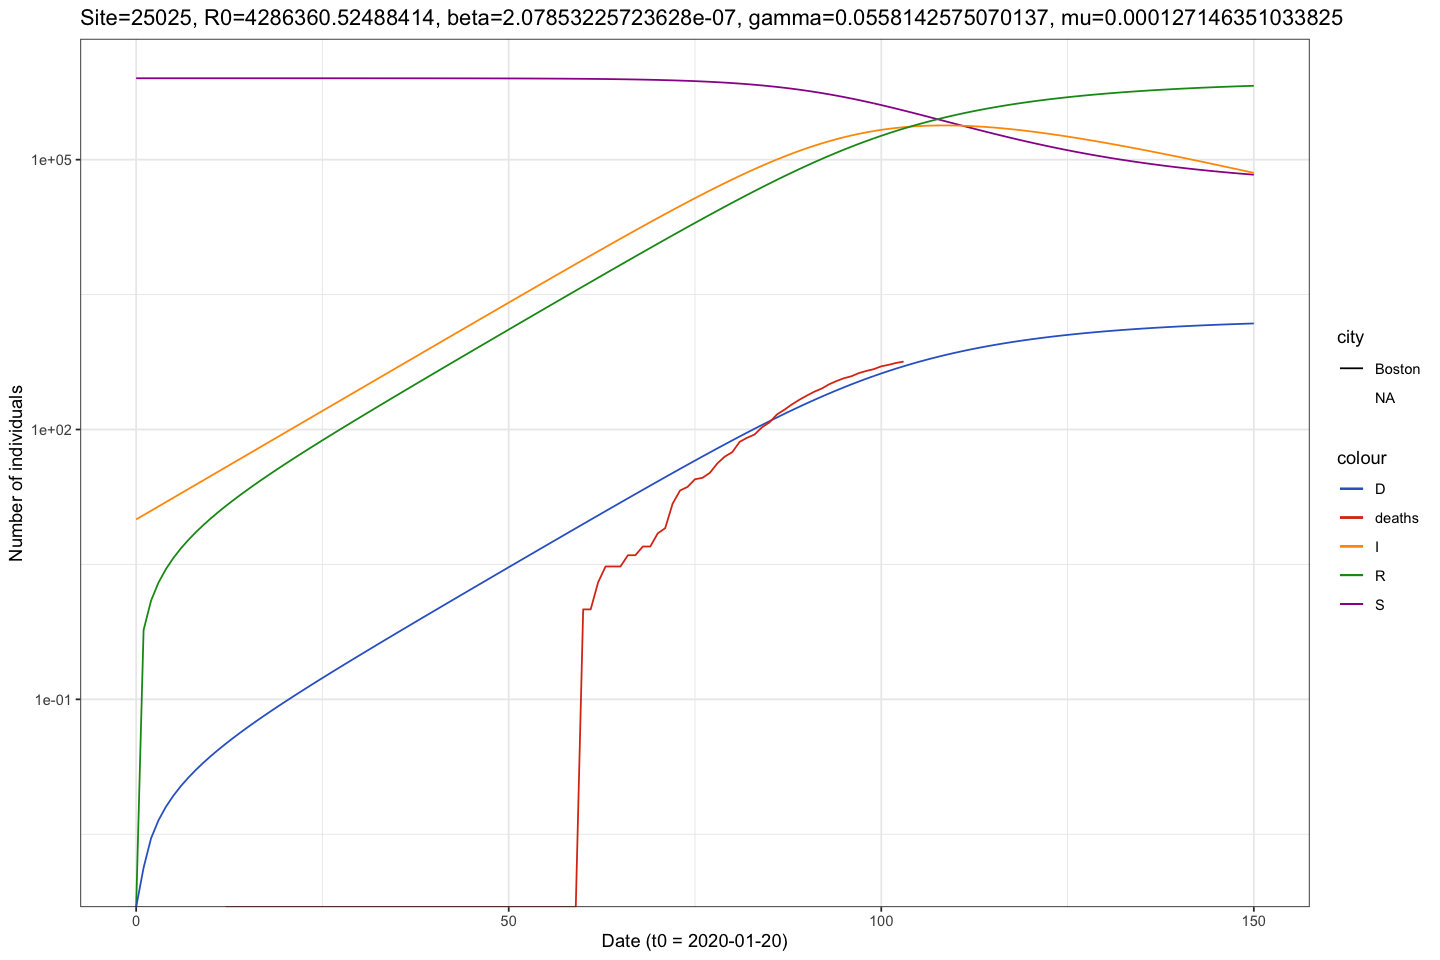

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 97 row(s) containing missing values (geom_path).”


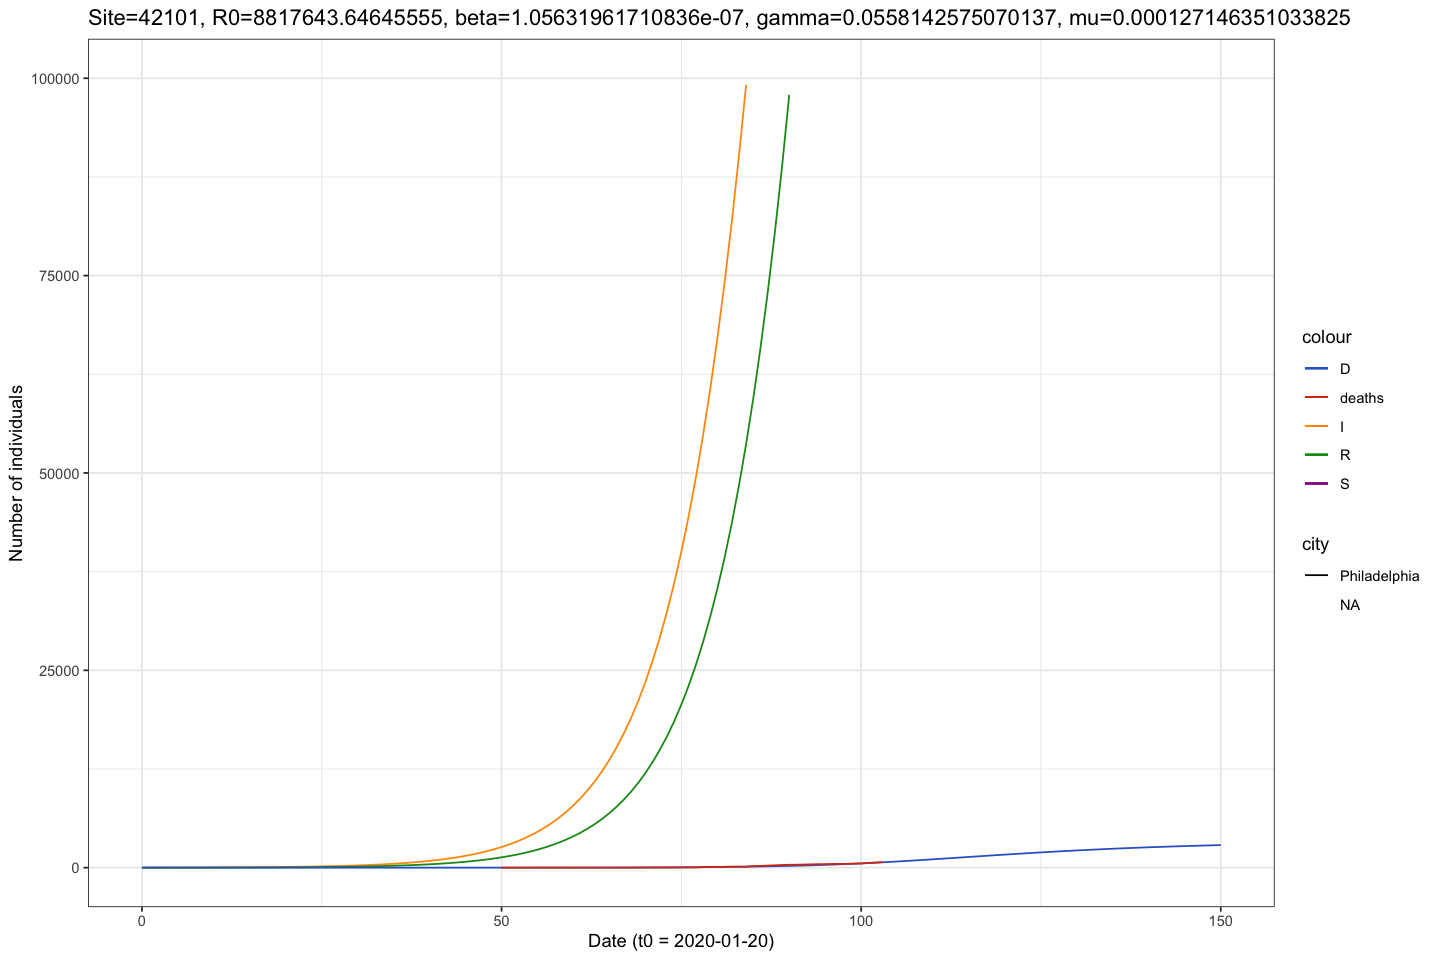

Warning message:
“Removed 151 row(s) containing missing values (geom_path).”
Warning message:
“Removed 99 row(s) containing missing values (geom_path).”
Warning message:
“Removed 92 row(s) containing missing values (geom_path).”
Warning message:
“Removed 88 row(s) containing missing values (geom_path).”


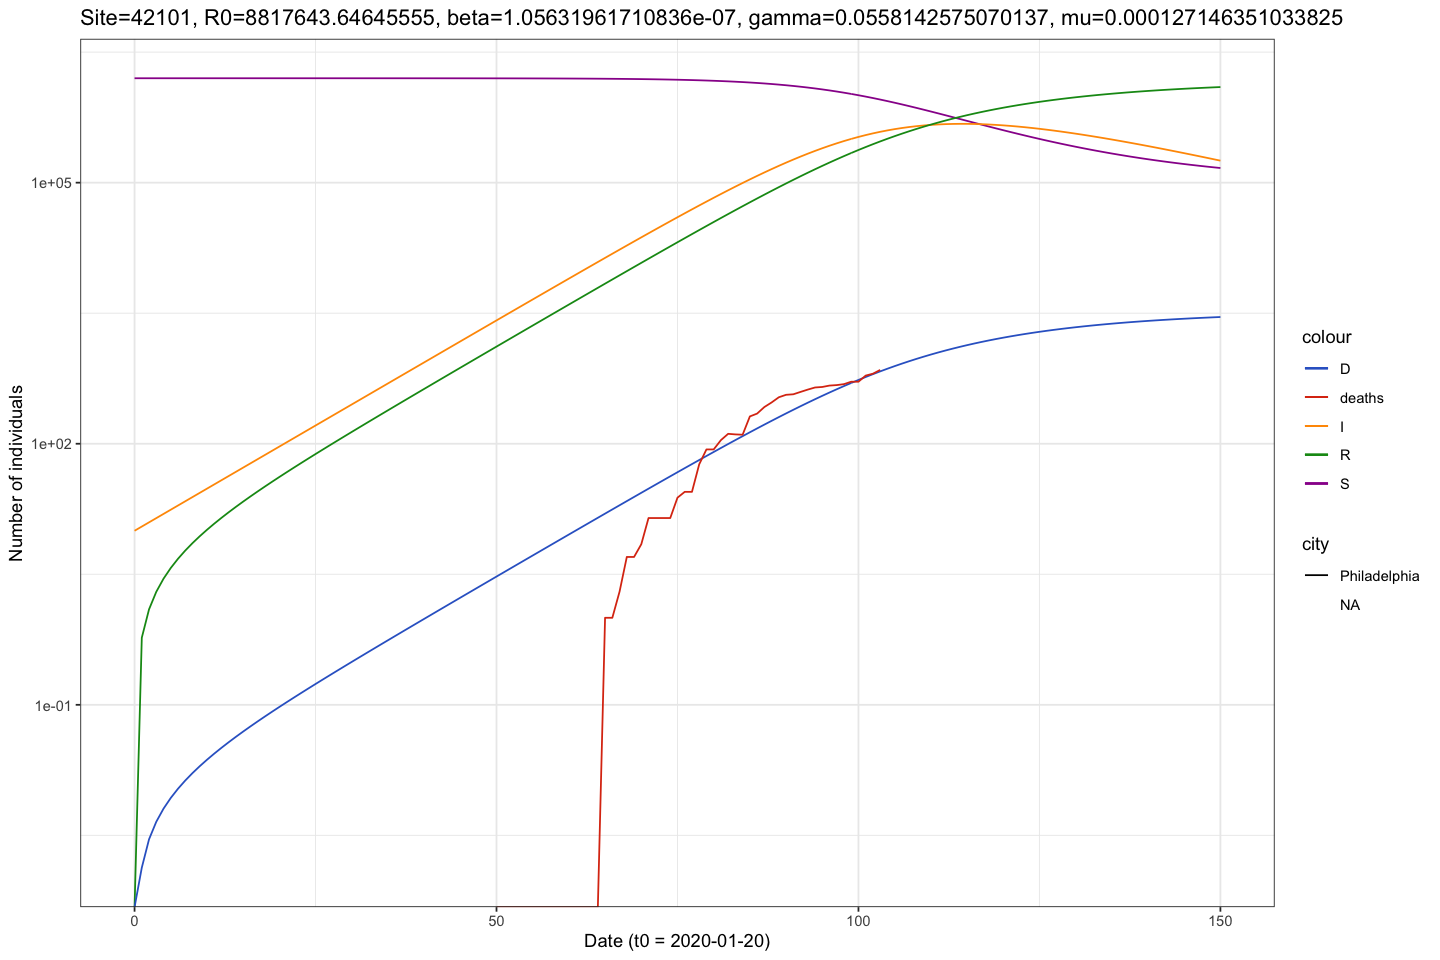

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 88 row(s) containing missing values (geom_path).”


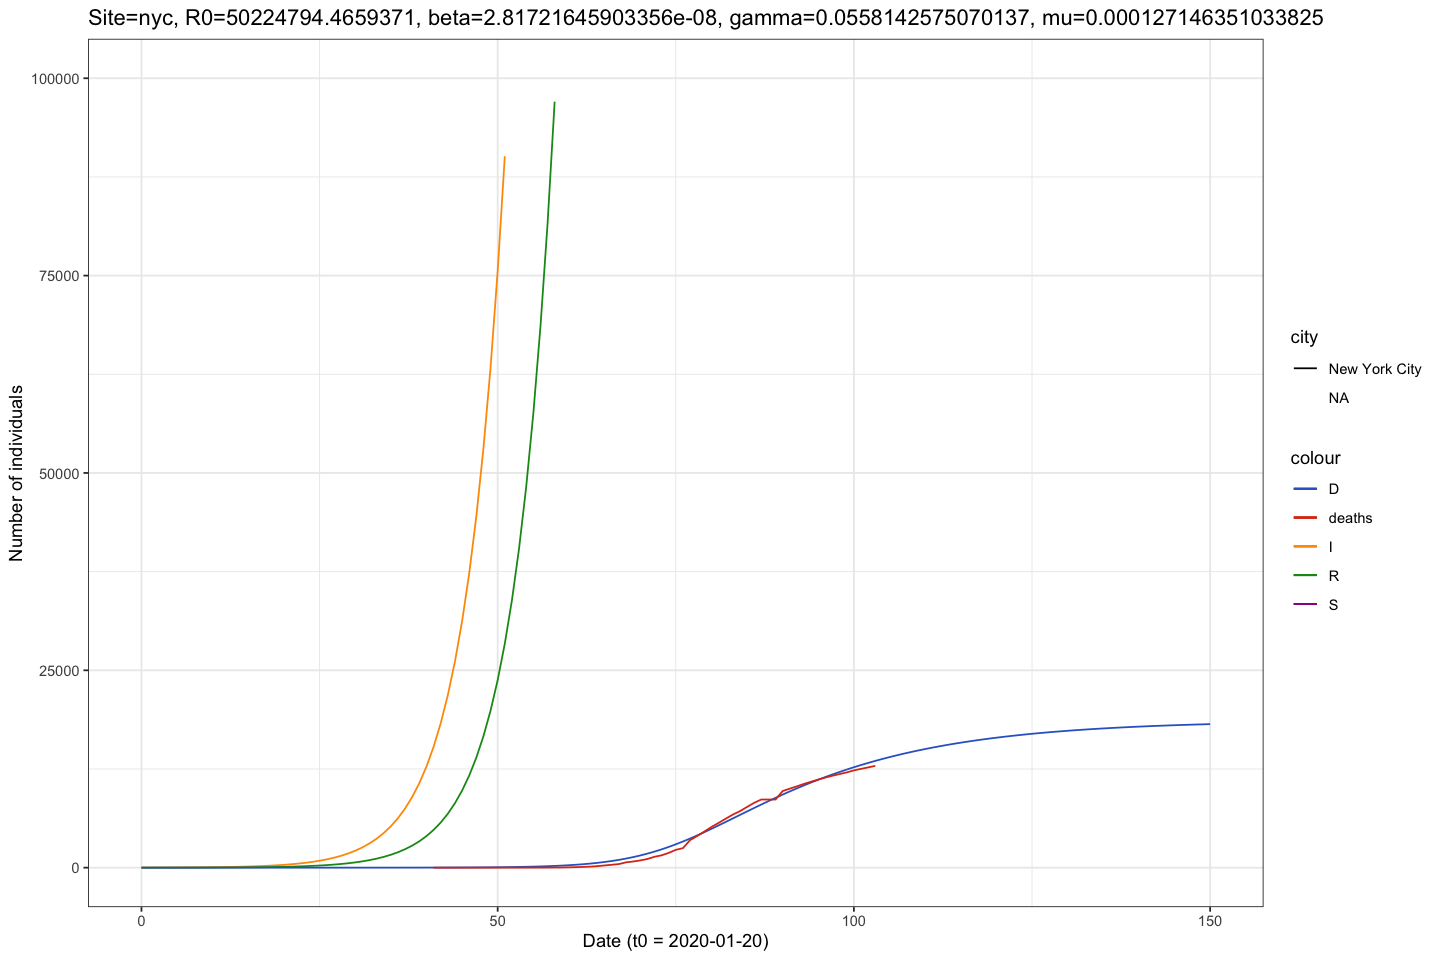

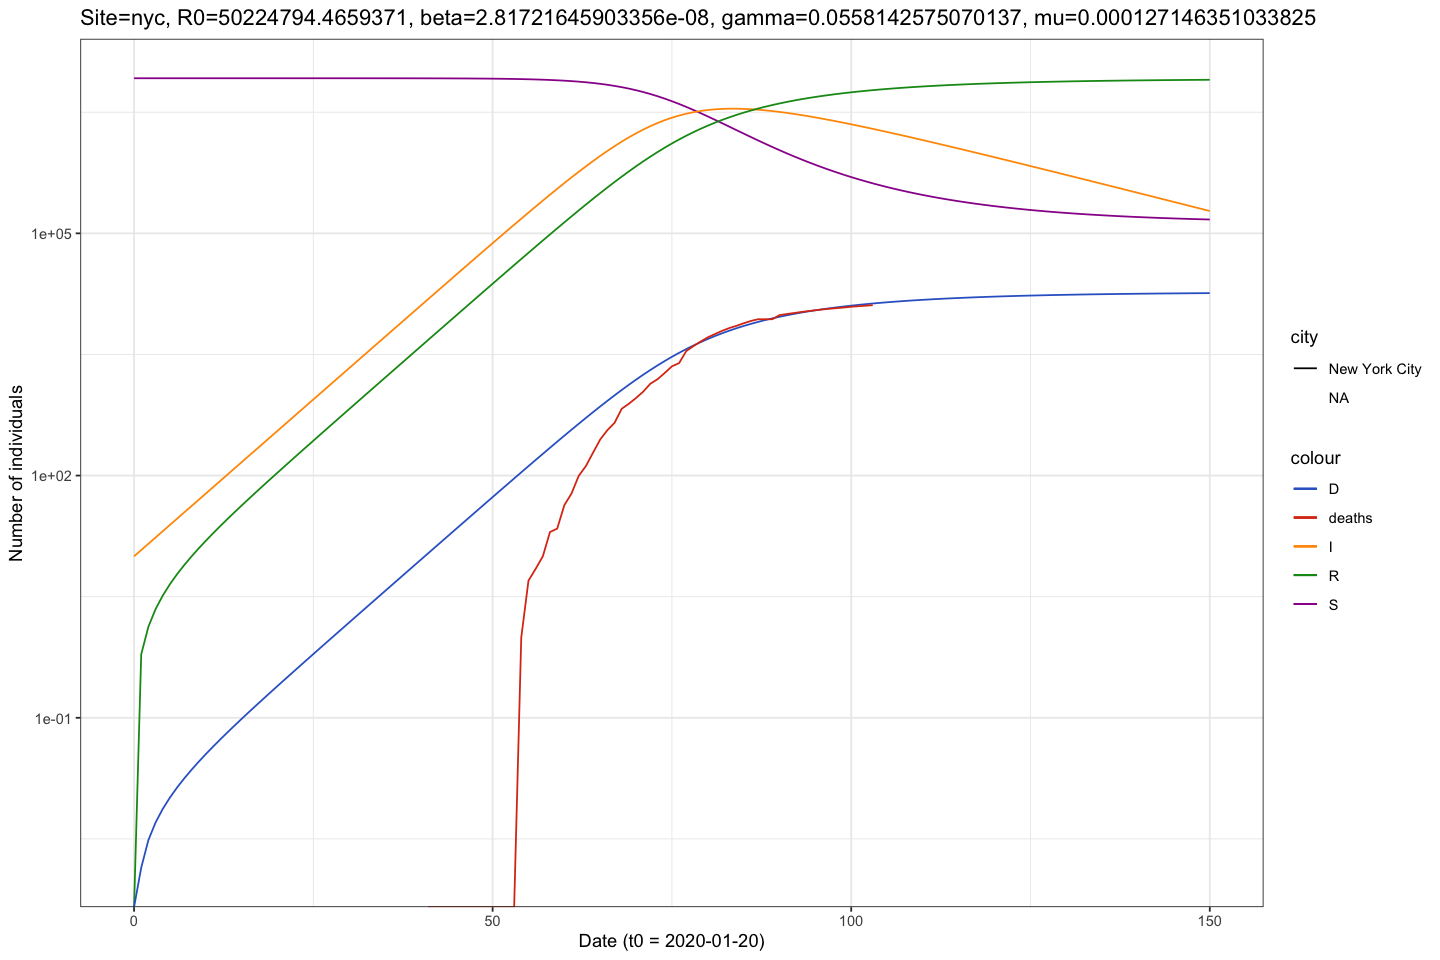

In [663]:
# simulation dataframe to model based on our input parameters

for (s in levels(mle1$fips2)) {
    site <- subset(mle1, fips2==s)
    beta.hat <- exp(site$beta)
    gamma.hat <- exp(site$gamma)
    mu.hat <- exp(site$mu)
    R0.hat <- site$R0
#     t_offset.hat <- site$t_offset
    t_offset.hat <- 0

    trajectory(
        model=m1,
        params=c(beta=beta.hat, gamma=gamma.hat, mu=mu.hat),
        times=times + t_offset.hat,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(site$N - I0, I0, 0, 0)) -> pred
    
#     join(pred, usdat, by='t') %>% print()
    
    # plot the simulated data compared to the observed data
    p <- ggplot(join(pred, subset(usdat, fips2==s), by='t'), aes(x=t))
    p <- p + theme_bw() + scale_color_gdocs()
    p <- p + geom_line(aes(y=S, col='S'))
    p <- p + geom_line(aes(y=I, col='I'))
    p <- p + geom_line(aes(y=R, col='R'))
    p <- p + geom_line(aes(y=D, col='D'))
    p <- p + geom_line(aes(y=deaths, col='deaths', linetype=city))
    p <- p + scale_y_continuous(limits=c(0,1e5))
    # p <- p + scale_y_continuous(trans='log10')
    p <- p + ggtitle(paste0('Site=', site$fips2, ', R0=', R0.hat, ', beta=', beta.hat, ', gamma=', gamma.hat, ', mu=', mu.hat))
    p <- p + xlab(paste0('Date (t0 = ', t0, ')')) + ylab('Number of individuals')
    print(p)
    
    # plot the simulated data compared to the observed data
    p <- ggplot(join(pred, subset(usdat, fips2==s), by='t'), aes(x=t))
    p <- p + theme_bw() + scale_color_gdocs()
    p <- p + geom_line(aes(y=S, col='S'))
    p <- p + geom_line(aes(y=I, col='I'))
    p <- p + geom_line(aes(y=R, col='R'))
    p <- p + geom_line(aes(y=D, col='D'))
    p <- p + geom_line(aes(y=deaths, col='deaths', linetype=city))
    # p <- p + scale_y_continuous(limits=c(0,3e4))
    p <- p + scale_y_continuous(trans='log10')
    p <- p + ggtitle(paste0('Site=', site$fips2, ', R0=', R0.hat, ', beta=', beta.hat, ', gamma=', gamma.hat, ', mu=', mu.hat))
    p <- p + xlab(paste0('Date (t0 = ', t0, ')')) + ylab('Number of individuals')
    print(p)
}

# Predictive accuracy

We'd like to assess the predictive utility of the model by running it on partial data and evaluating whether subsequent data agrees with the prediction.

- Poisson error model
- Maximize log-likelihood with simultaneous optimization of $\beta$, $\mu$, $\gamma$
- Generate predictions at $0 \le t \le u $

In [717]:
# to do

# To do

- [x] Multiple cities/locales
- [x] Assess sensitivity to $N$
    - Problematically sensitive to choice of $N$ on a countrywide-scale in Italy
    - Try assessing cities/counties instead of country data
- [ ] different $I_0$
- [ ] Use the Grand Princess cruise ship data
- [ ] Assess predictive power at different modeling endpoints
- [ ] Adjust for population demographic differences with age-scaled $\mu$
- [ ] Evaluate cases as a lower bound for infection prevalence
- [ ] Compare to preliminary serology reports
- [ ] Negative binomial model
- [ ] Use SEIR model

# References

1. https://kingaa.github.io/short-course/parest/parest.html
    - Methods are techniques derived heavily from this [excellent course](http://kingaa.github.io/short-course/) from Adam King at U Michigan